# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
unfiltered['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = unfiltered['uk12'].append(df)

L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
calls['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = calls['uk12'].append(df)
    
    
globalt0 = dt.datetime.now()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
calls['uk12']

ego         alter                time  uclock  aclock
0      aC07779270485  C01142661971 2007-03-06 14:40:00       1       0
1      aC07779270485  C01142661971 2007-03-17 19:19:00      12      11
2      aC07779270485  C01142661971 2007-03-30 17:21:00      25      24
3      aC07779270485  C01142661971 2007-04-02 19:28:00      28      27
4      aC07779270485  C01142661971 2007-04-05 11:43:00      30      29
...              ...           ...                 ...     ...     ...
12998  bC07999103487   C7964154172 2007-09-20 13:29:00      18       0
12999  bC07999103487   C7964154172 2007-09-20 14:46:00      18       0
13000  bC07999103487   C7964154172 2007-09-28 22:07:00      27       9
13001  bC07999103487   C7964154172 2007-10-04 23:37:00      33      15
13002  bC07999103487   C7964154172 2007-10-04 23:38:00      33      15

[24302 rows x 5 columns]

In [3]:
for c in ['uk', 'uk2', 'it', 'mit']:
    print(c, min(unfiltered[c]['time']), max(unfiltered[c]['time']), max(unfiltered[c]['uclock']) - min(unfiltered[c]['uclock']))

uk 2007-03-05 13:17:00 2008-08-31 20:13:00 545
uk2 2007-09-01 15:05:00 2008-08-31 20:13:00 365
it 2013-02-01 08:03:16 2014-12-31 23:46:21 698
mit 2010-02-27 17:05:20 2011-07-16 19:33:13 504


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [4]:
# with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
#     tmpdff = pickle.load(handle)
#     handle.close()
    
# with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
#     tmplives = pickle.load(handle)
#     handle.close()
    
# pikachu = {}
# for it in ['it1', 'it2']:
#     pikachu[it] = {}
#     for ego in tmpdff[it][60].keys():
#         thekey = {"it1": "a", "it2": "b"}
#         pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
#         pikachu['it'] = pikachu.get('it', {})
#         pikachu['it'][f'{thekey[it]}{ego}'] = {}
#         pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

# raichu = {}
# for it in ['it1', 'it2']:
#     raichu[it] = {}
#     for ego in tmplives[it][60].keys():
#         thekey = {"it1": "a", "it2": "b"}
#         raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
#         raichu['it'] = raichu.get('it', {})
#         raichu['it'][f'{thekey[it]}{ego}'] = {}
#         raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [5]:
# lives = {}
# forkey = {'uk1': 'a', 'uk2': 'b'}
# for c in ['uk1', 'uk2', 'mit', 'it', 'uk']:
#     if c in ['uk1', 'uk2']:
#         lf = pc.lives_dictionary(calls[''])
#         lives[c] = {}
#         for ego in lf.keys():
#             thekey = f'{forkey[c]}{ego}'
#             lives[c][thekey] = lf[ego]
#         lives['all'] = lives.get('all', {})
#         lives['all'].update(lives[c])
#     elif c == 'uk':
#         lives[c] = {}
#         for u in ['uk1', 'uk2']:
#             lives[c].update(lives[u])
#     else:
#         lives[c] = pc.lives_dictionary(calls[c])
#         lives['all'] = lives.get('all', {})
#         lives['all'].update(lives[c])

In [6]:
lives = {}
lives['all'] = {}
for c in ['uk2', 'it', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    lives['all'].update(lives[c])

In [7]:
# dffcomb = {}
# # for c in ['it', 'it1', 'it2']:
# #     dffcomb[c] = pikachu[c]

# dffcomb['uk'] = {}
# dffcomb['it'] = {}
# for c in ['uk1', 'uk2', 'it1', 'it2']:
#     cdf = calls[c].loc[calls[c]['aclock'] <= 300]
#     ddf = pc.get_f(cdf, 'all', 15, 10)
#     dffcomb[c] = {}
#     forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
#     for ego in ddf.keys():
#         dffcomb[c][f'{forkey[c]}{ego}'] = {}
#         for alter in ddf[ego].keys():
#             df1 = ddf[ego][alter]
#             df2 = df1.loc[(df1['alpha'] <= 20)]
#             dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
#             if c in ['uk1', 'uk2']:
#                 dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
#                 dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
#             else:
#                 dffcomb['it'][f'{forkey[c]}{ego}'] = dffcomb['it'].get(f'{forkey[c]}{ego}', {})
#                 dffcomb['it'][f'{forkey[c]}{ego}'][alter] = dffcomb['it'][f'{forkey[c]}{ego}'].get(alter, df2)
            
# dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [8]:
# limits = [(0, 50), (100, 150), (200, 250)]

In [9]:
# limits = [(0, 50), (100, 150), (200, 250)]
# limsit = [(0, 50), (200, 250), (300, 350)]

In [263]:
limits = {}
for c in ['uk2', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [194]:
# limits['it'] = [(0, 50), (150, 200), (270, 320)]

In [12]:
# t0 = dt.datetime.now()

# fig1 = {}
# for c in ['uk', 'uk2', 'it', 'mit']:
#     fig1[c] = {}
#     for i in range(3):
#         fig1[c][i] = {}
#         fig1[c][i]['f'] = pc.get_avgfa(dffcomb[c], lives[c], limits[i][0], limits[i][1])
#         fig1[c][i]['fi'] = {}
#         for ego in dffcomb[c].keys():
#             tmp = {ego: dffcomb[c][ego]}
#             fig1[c][i]['fi'][ego] = pc.get_avgfa(tmp, lives[c], limits[i][0], limits[i][1])
        
# print(f'Took {dt.datetime.now() - t0}')

In [13]:
t0 = dt.datetime.now()
fig1 = {}
for c in ['uk2', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15, countalters=True)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.807556


In [14]:
dashed = {}
for c in ['uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk2=====================
[[1, 2], [0.663175464631242, 0.663175464631242], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.663175464631242) -- (axis cs: 2, 0.663175464631242);
[[1, 9], [1.87373430853823, 1.87373430853823], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.87373430853823) -- (axis cs: 9, 1.87373430853823);
[[1, 16], [2.4968990752451297, 2.4968990752451297], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.448535988086695) -- (axis cs: 13, 2.448535988086695);
=======================it=====================
[[1, 2], [0.551795638030544, 0.551795638030544], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
[[1, 12], [0.7250957211167651, 0.7250957211167651], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.7250957211167651) -- (axis cs: 12, 0.7250957211167651);
[[1, 23], [2.341541665493771, 2.341541665493771], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2

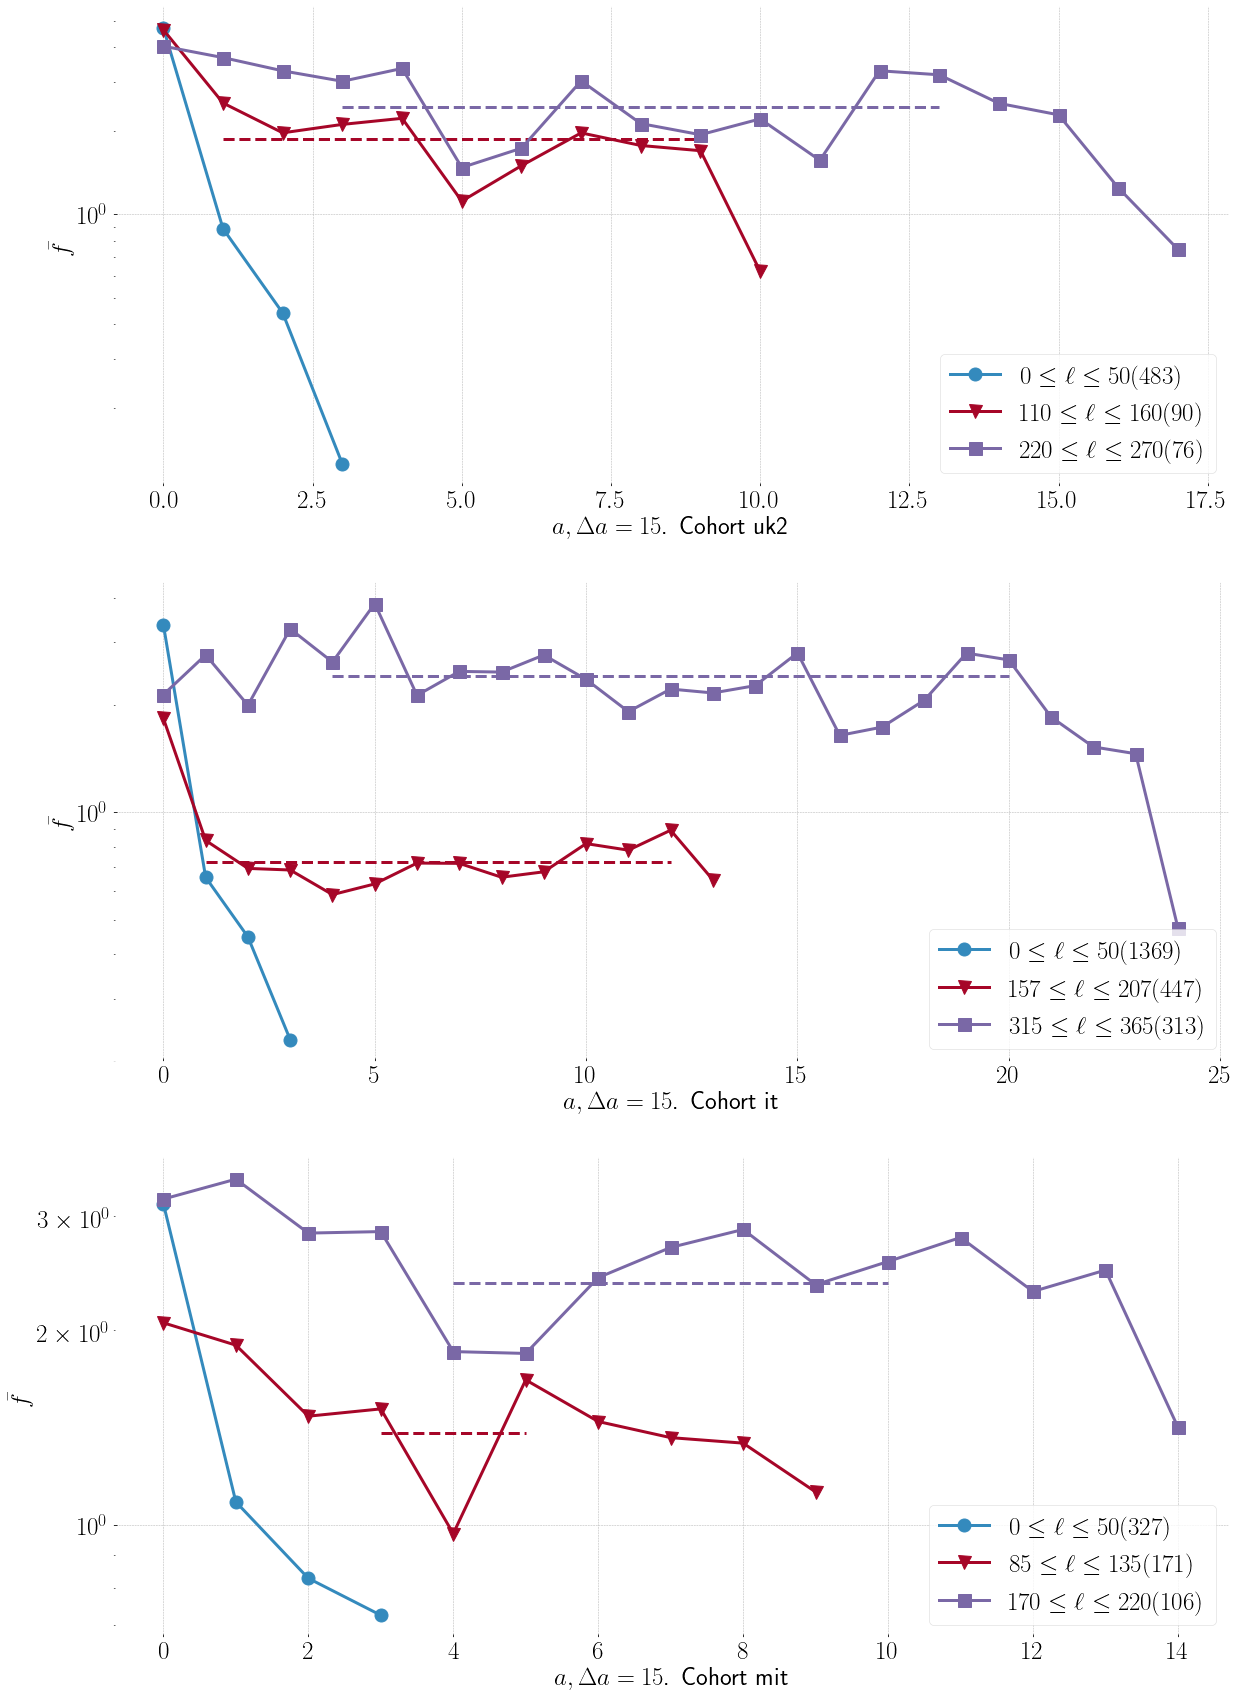

In [15]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in ['uk2', 'it', 'mit']:
    plt.subplot(3, 1, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]} ({fig1[c][i]["nalters"]})$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [16]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]['f']
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

# Fig 2

In [17]:
ksp = {}
for c in ['uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [18]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

In [19]:
for c in ksp.keys():
    for k in ksp[c].keys():
        lista = ksp[c][k]
        count = 0
        for i in lista:
            if i < 0.05:
                count += 1
        print(c, k, count/len(lista))

uk2 m 0.0
uk2 l 0.041666666666666664
it m 0.00847457627118644
it l 0.02247191011235955
mit m 0.0
mit l 0.01694915254237288


In [20]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [21]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [22]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

/Users/vsvh/Documents/research/comm_patterns_git/phonecalls.py:735: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [23]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [24]:
cols = ['uk2m', 'itm', 'mitm', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,1,4,7]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 3]
b = tmp2.loc[tmp2.index >= 3]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [25]:
a

c  pos      mean       sem
idx                               
0    uk2m    0  1.727530  1.765591
1     itm    3  0.871059  0.619334
2    mitm    6  1.546408  1.506293

In [26]:
dashed

{'uk2': {0: [[1, 2], [0.663175464631242, 0.663175464631242]],
  1: [[1, 9], [1.87373430853823, 1.87373430853823]],
  2: [[3, 13], [2.448535988086695, 2.448535988086695]]},
 'it': {0: [[1, 2], [0.551795638030544, 0.551795638030544]],
  1: [[1, 12], [0.7250957211167651, 0.7250957211167651]],
  2: [[4, 20], [2.410915817340646, 2.410915817340646]]},
 'mit': {0: [[1, 2], [0.9565583127190271, 0.9565583127190271]],
  1: [[3, 5], [1.3858107036852683, 1.3858107036852683]],
  2: [[4, 10], [2.365495875341885, 2.365495875341885]]}}

# Fig 3 with resampling

In [27]:
# dffsurv = {}
# dffsurv['all'] = {}
# for c in dffcomb.keys():
#     if c in ['it1', 'it2', 'uk1', 'uk2', 'mit']:
#         dffsurv['all'].update(dffcomb[c])
#     if c in ['uk', 'uk2', 'it', 'mit']:
#         dffsurv[c] = dffcomb[c]

In [28]:
# fig3 = {}
# for c in dffsurv.keys():
#     fig3[c] = pc.get_survival(dffsurv[c], alphafixed=(2,3), externalell=lives[c], lambdamax=25)

In [29]:
# plt.xlabel(r'$\ell, \Delta \ell = 10$')
# plt.ylabel(r'$P$')
# for i in range(5):
#     plt.plot(fig3['all'][i].index, fig3['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
# plt.legend()

In [30]:
# tmp = pd.DataFrame({'lc': list(fig3['all'][0].index)})
# for s in range(6):
#     df = fig3['all'][s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

## Using an alternative function

In [31]:
# callsurv = {}
# callsurv['all'] = pd.DataFrame()
# callsurv['uk'] = pd.DataFrame()
# callsurv['it'] = pd.DataFrame()
# for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
#     df = calls[c].loc[calls[c]['aclock'] <= 300]
#     if c != 'mit':
#         if c in ['uk1', 'it1']:
#             df['ego'] = df['ego'].map(lambda i: 'a'+str(i))
#         elif c in ['uk2', 'it2']:
#             df['ego'] = df['ego'].map(lambda i: 'b'+str(i))
#         callsurv[c] = df
#         if c in ['uk1', 'uk2']:
#             callsurv['uk'] = callsurv['uk'].append(df)
#         elif c in ['it1', 'it2']:
#             callsurv['it'] = callsurv['it'].append(df)
#         callsurv['all'] = callsurv['all'].append(df)
#     else:
#         callsurv[c] = df
#         callsurv['all'] = callsurv['all'].append(df)

In [32]:
calls['all'] = pd.DataFrame()
for c in calls.keys():
    if c in ['uk2', 'it', 'mit']:
        calls['all'] = calls['all'].append(calls[c])

In [33]:
len(calls['all']) == len(calls['uk2']) + len(calls['mit']) + len(calls['it'])

True

In [34]:
fig3b = {}
for c in ['all', 'uk2', 'it', 'mit']:
    fig3b[c] = pc.get_survival2(calls[c], 30, 60, maxell = 220, base = 3)

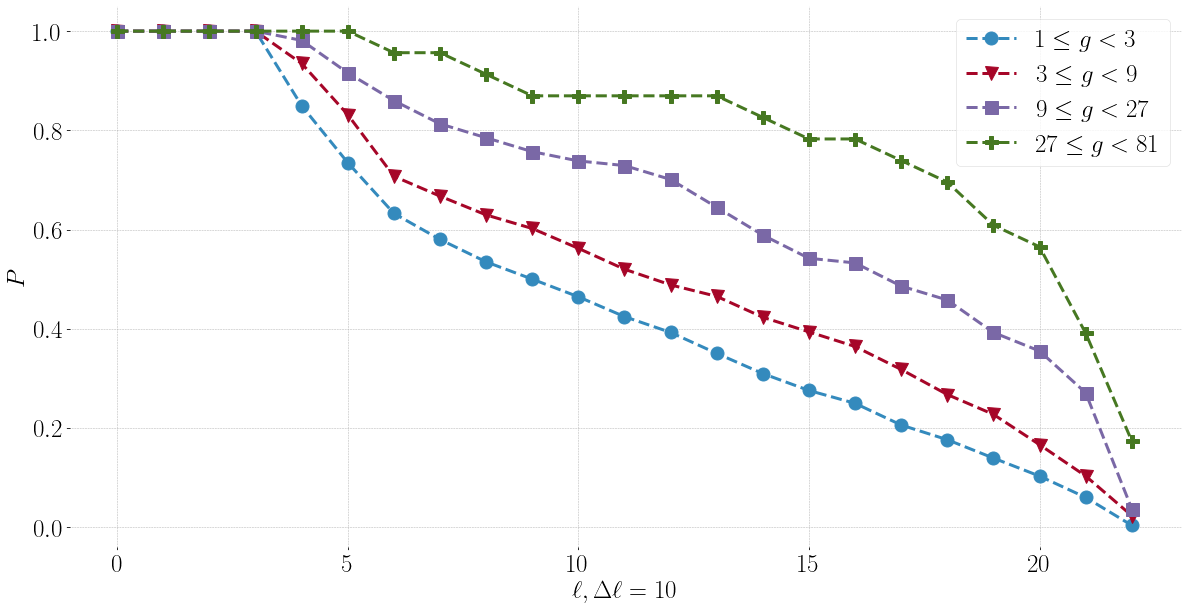

In [35]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(4):
    plt.plot(fig3b['all'][i].index, fig3b['all'][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${3**i} \leq g < {3**(i + 1)}$')
plt.legend()

In [36]:
tmp = pd.DataFrame({'lc': list(fig3b['all'][0].index)})
for s in range(4):
    df = fig3b['all'][s]
    tmp[f'p{int(s)}'] = df['p']
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

# Fig 4 with resampling

In [37]:
callsUM = pd.DataFrame()
for c in ['uk2', 'mit']:
    callsUM = callsUM.append(calls[c])
    
surv_cont = pc.get_survival2(callsUM, 30, 60, maxell=220, base = 3)

In [38]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [39]:
points_it = pc.get_survival2(calls['it'], 30, 60, binned=False, maxell=220)

tmp = pd.DataFrame()
for s in points_it.keys():
    if s < 3**4 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

# SI with resampling

## Using different values for $\Delta t_w$

In [40]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk2', 'it', 'mit']:
    S1[c] = {}
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    for tw in [10, 30, 50, 60, 90]:
        S1[c][tw] = {}
        cdf = pc.apply_filters(df, tw)
        for lamb in range(3):
            S1[c][tw][lamb] = pc.get_fal(cdf, limits[c][lamb][0], limits[c][lamb][1], 15)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:05.150204


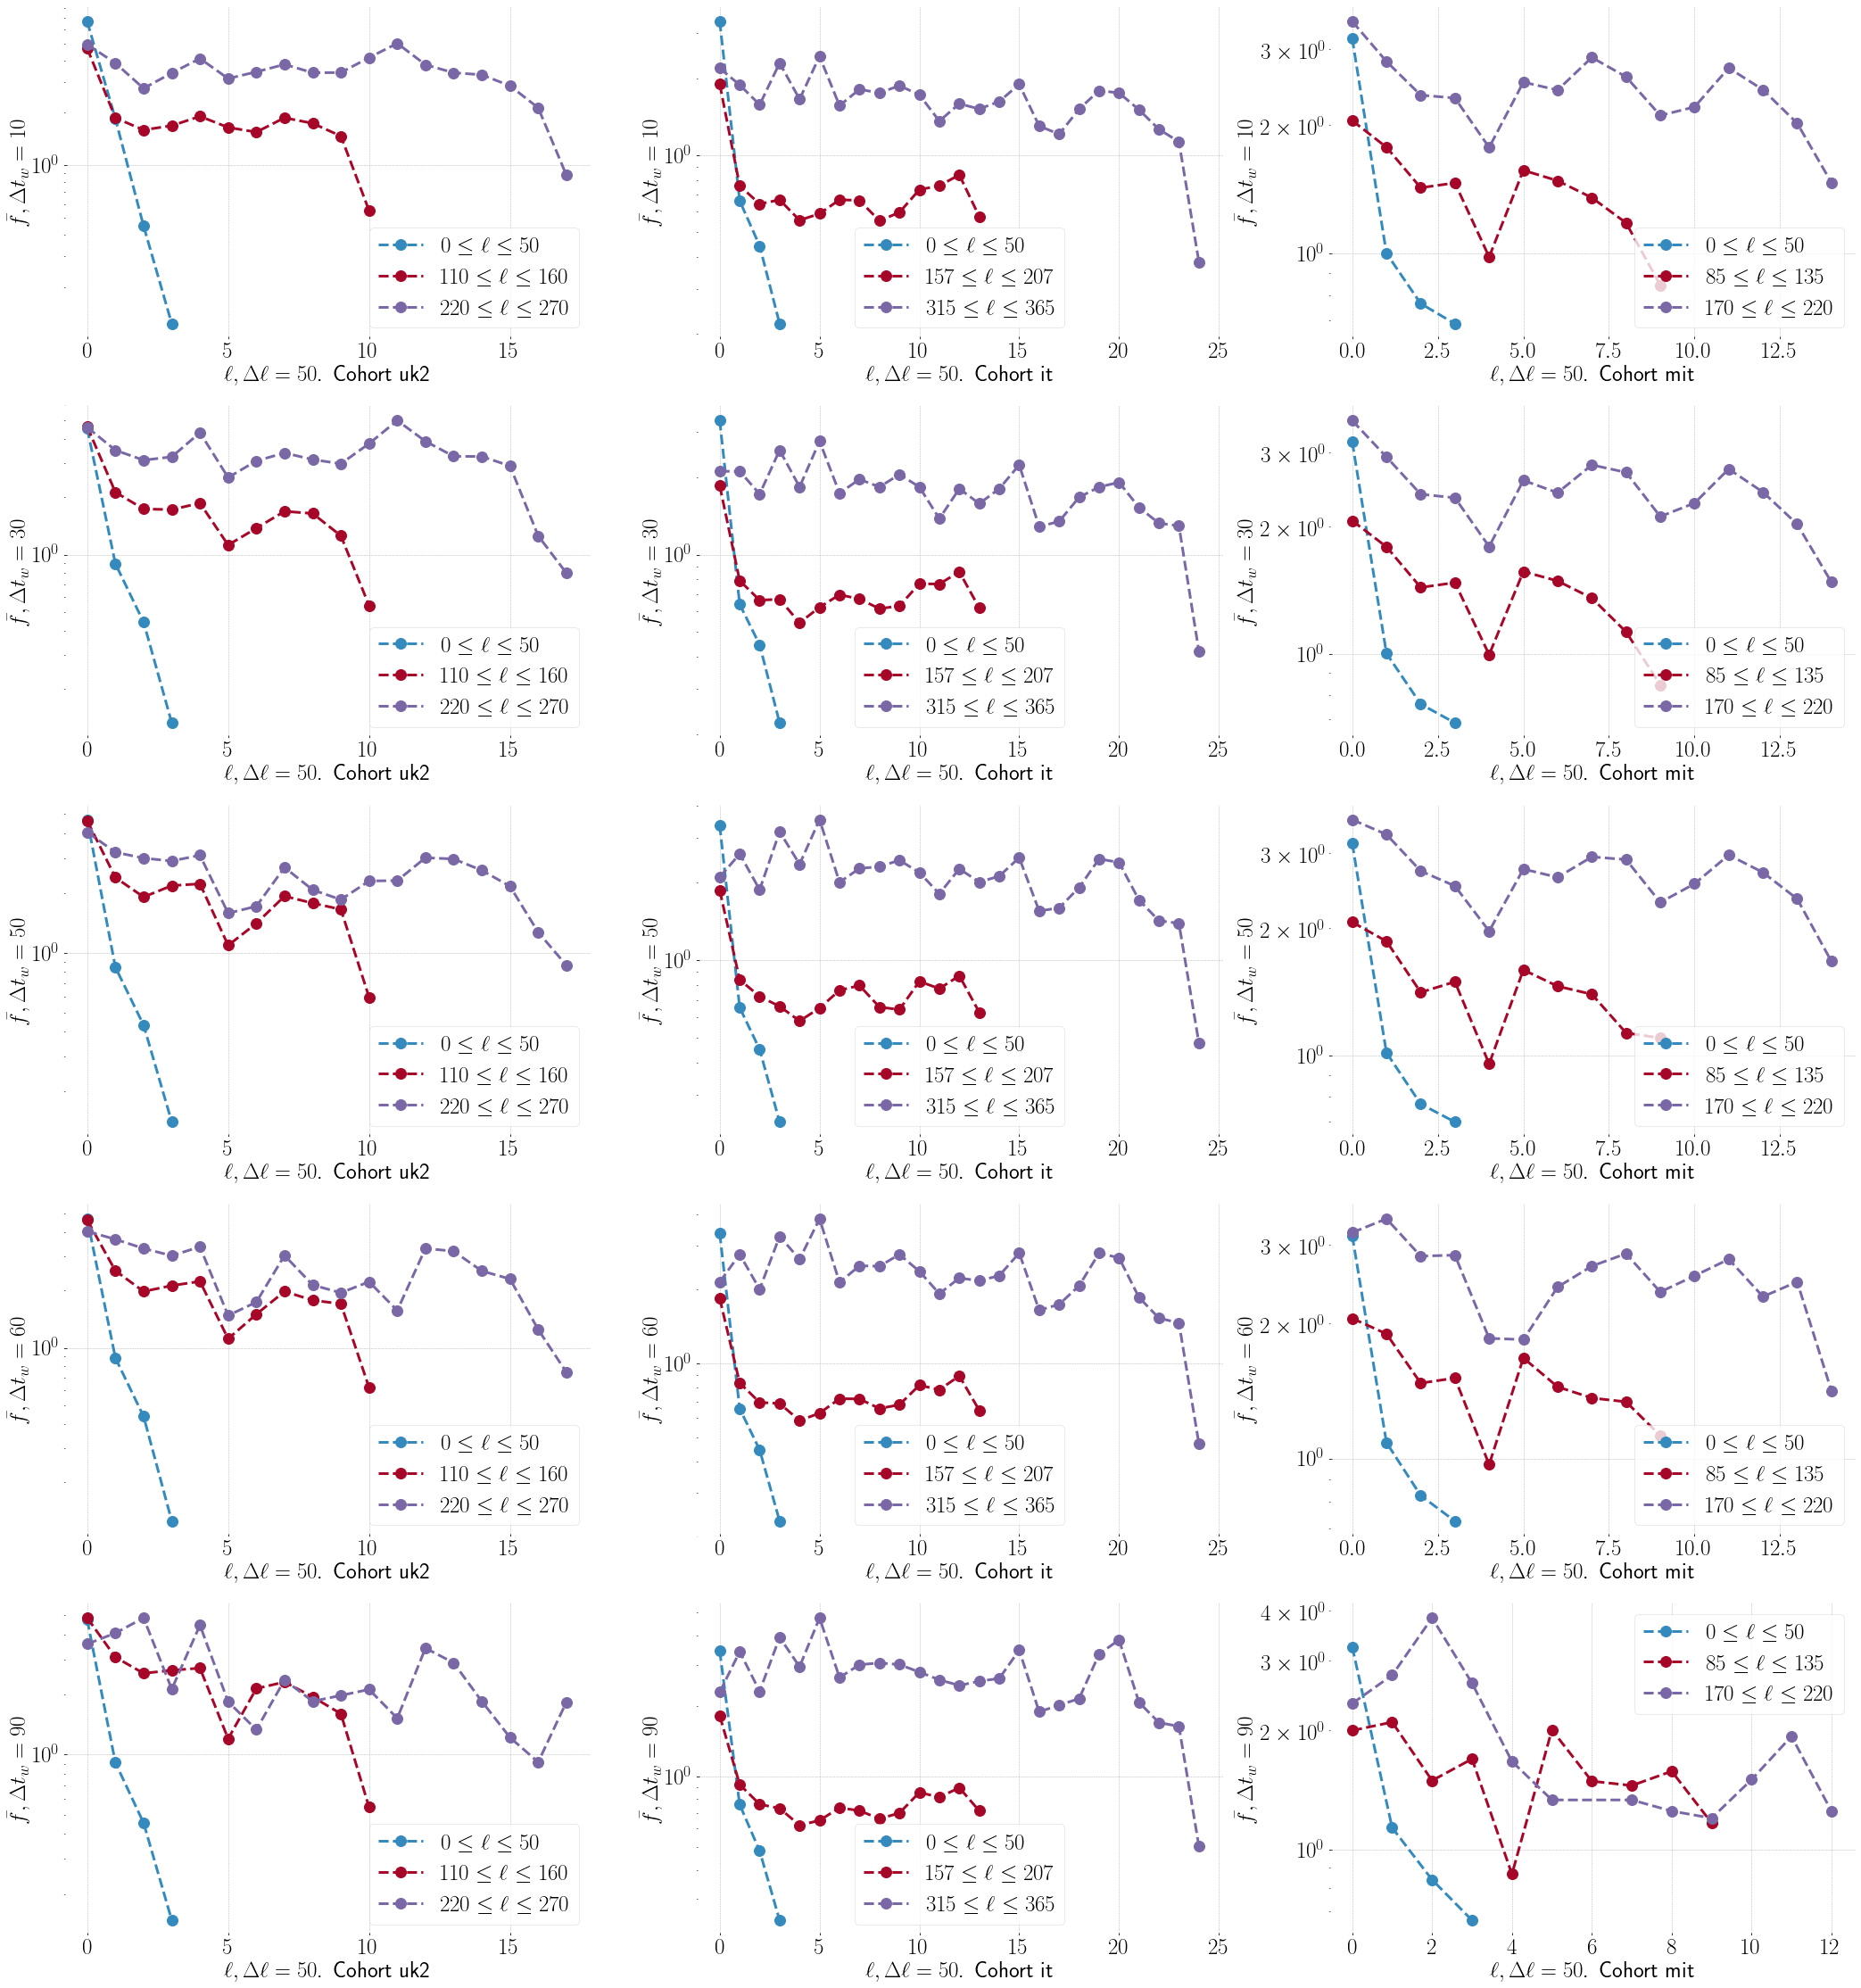

In [41]:
plt.figure(figsize=(12*3, 8*6))
p = 1
for Dt in S1['uk2'].keys():
    for c in S1.keys():
        plt.subplot(6, 3, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[c][lamb][0]}\leq \ell \leq {limits[c][lamb][1]}$')
        plt.legend()
        p += 1

In [42]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

## Different values for $\Delta \ell$

In [43]:
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [44]:
lims = {}
for c in limits.keys():
    lims[c] = {}
    for i in range(3):
        lims[c][i] = [limits[c][i]] + [(limits[c][i][0], limits[c][i][0] + Dl) for Dl in [10, 30, 70, 90]]
        
lims


{'uk2': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(110, 160), (110, 120), (110, 140), (110, 180), (110, 200)],
  2: [(220, 270), (220, 230), (220, 250), (220, 290), (220, 310)]},
 'it': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(157, 207), (157, 167), (157, 187), (157, 227), (157, 247)],
  2: [(315, 365), (315, 325), (315, 345), (315, 385), (315, 405)]},
 'mit': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(85, 135), (85, 95), (85, 115), (85, 155), (85, 175)],
  2: [(170, 220), (170, 180), (170, 200), (170, 240), (170, 260)]}}

In [45]:
S2 = {}
for c in ['uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            S2[c][i][j] = pc.get_fal(calls[c], lims[c][i][j][0], lims[c][i][j][1], 15)

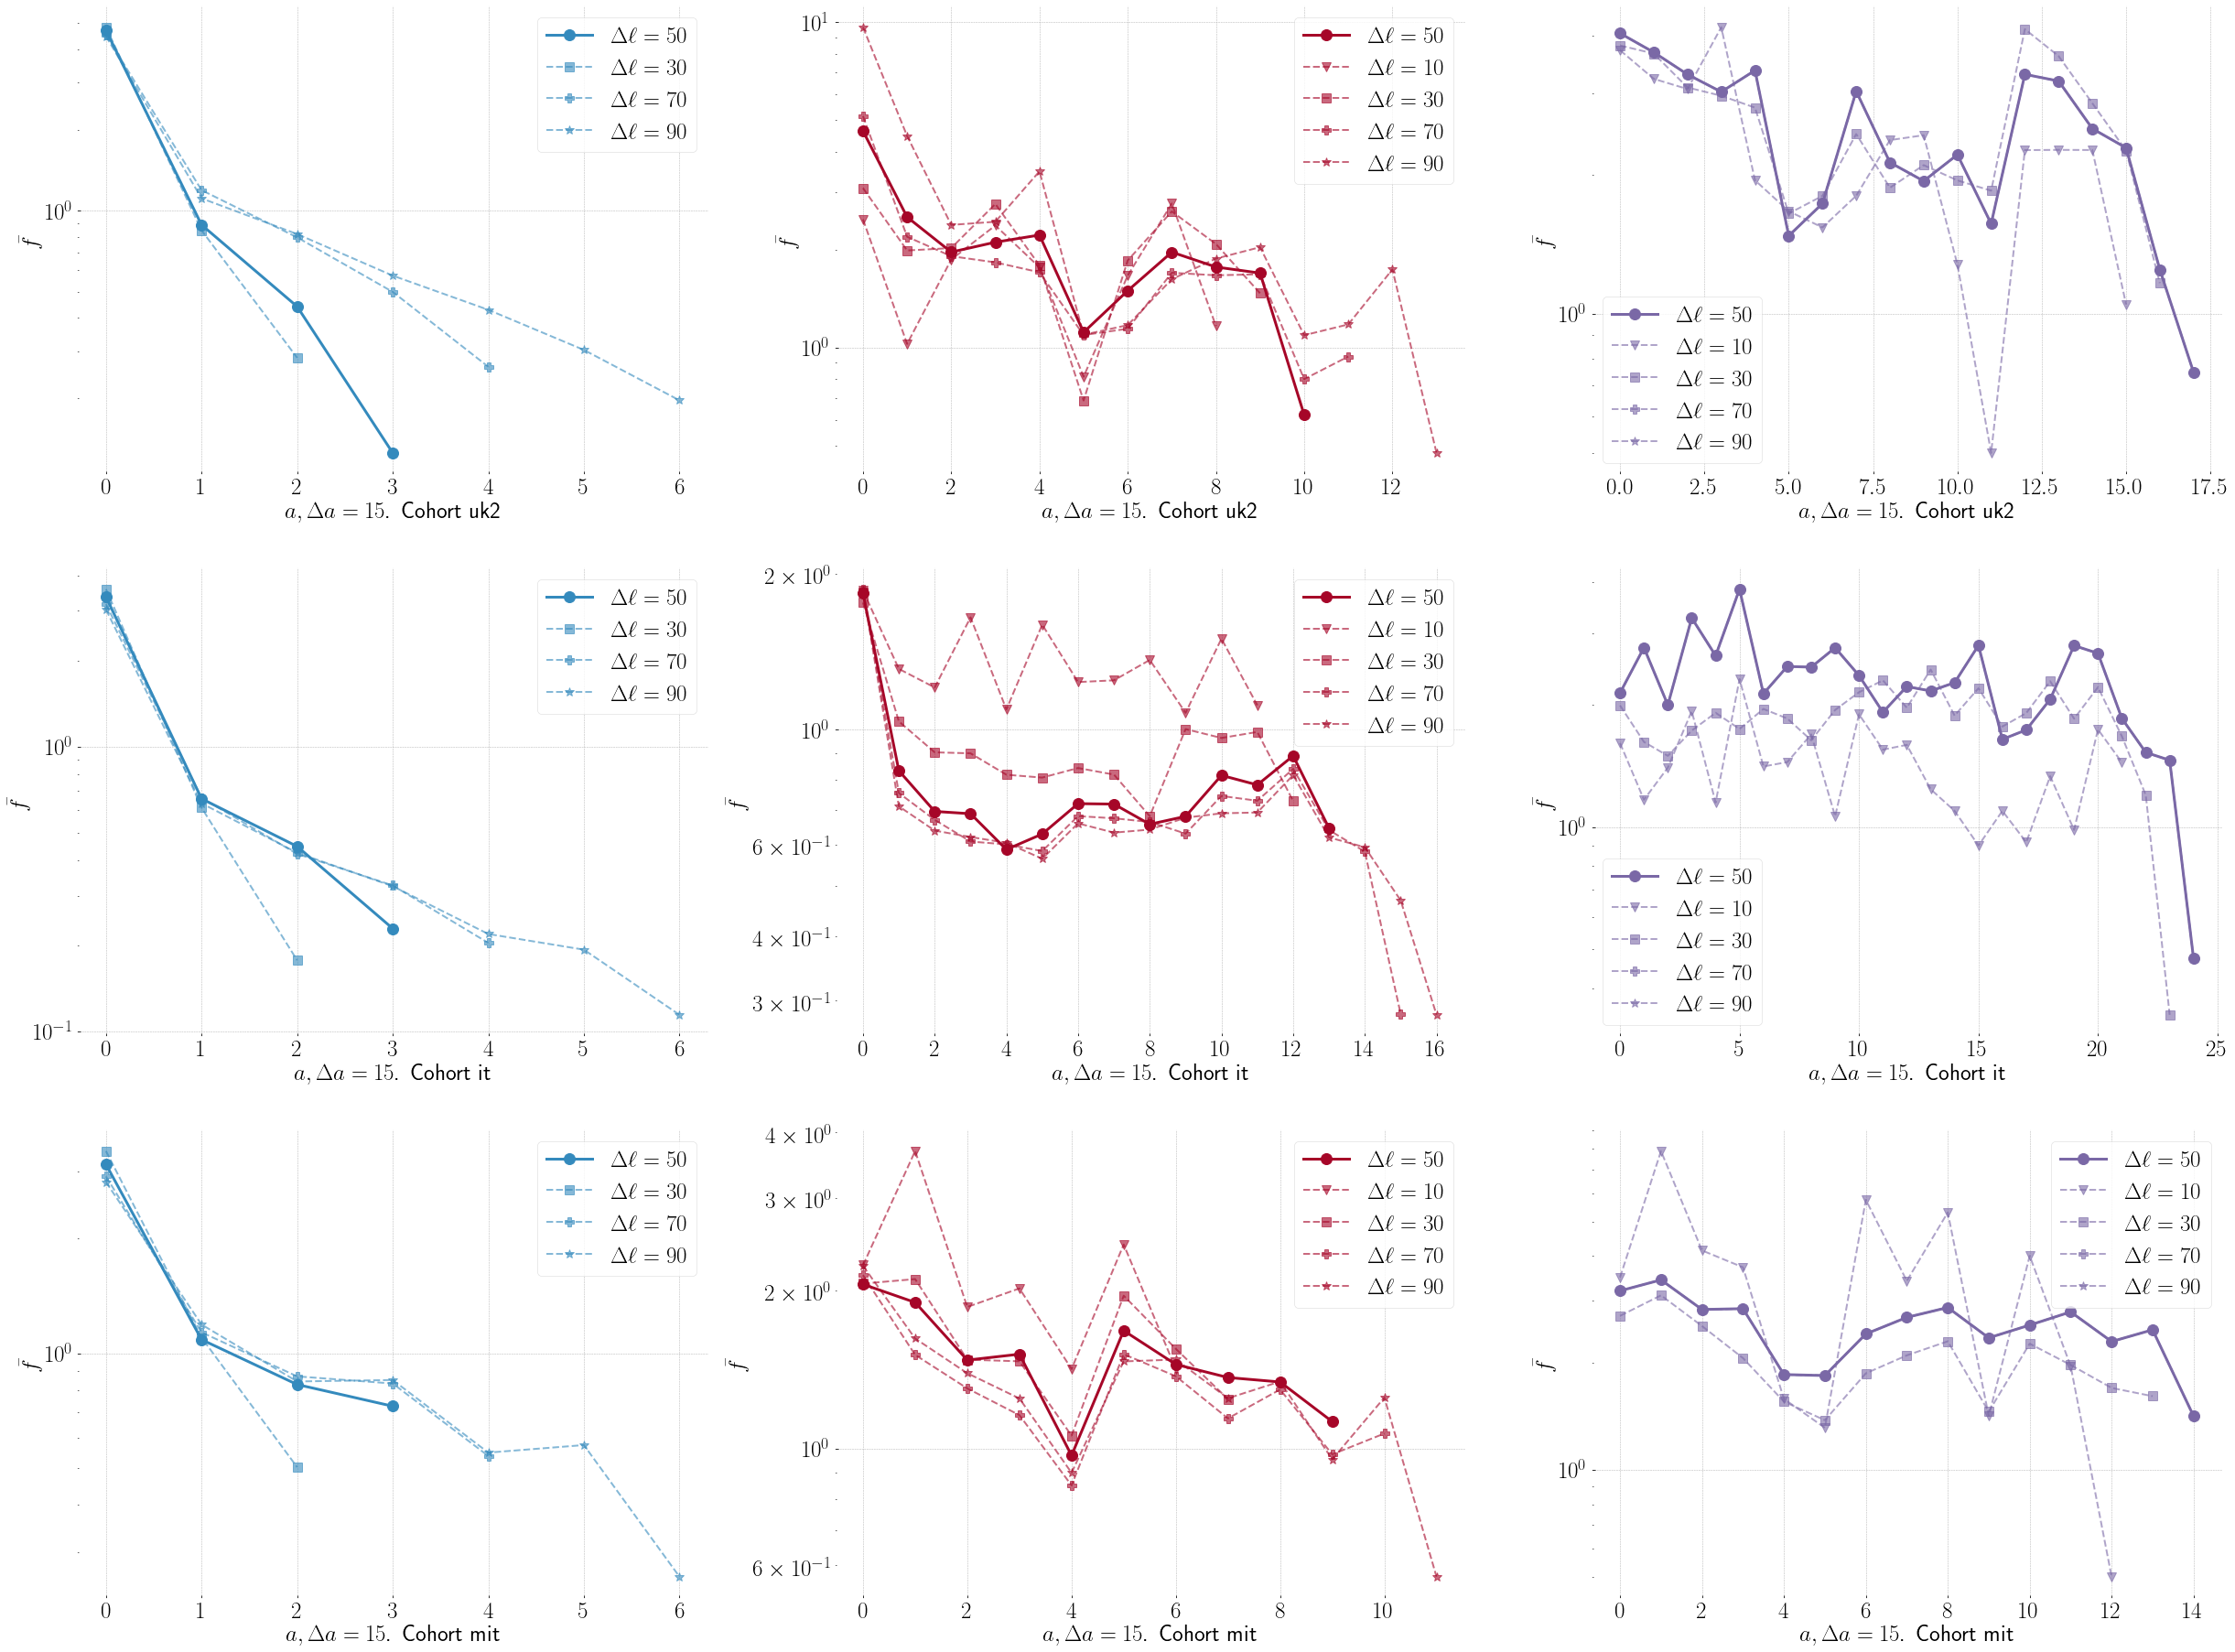

In [46]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(3, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [47]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1: variations of $\Delta a$

In [48]:
t0 = dt.datetime.now()
Deltaa = {}
for c in ['uk2', 'it', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            Deltaa[c][Da][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], Da)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:03.457911


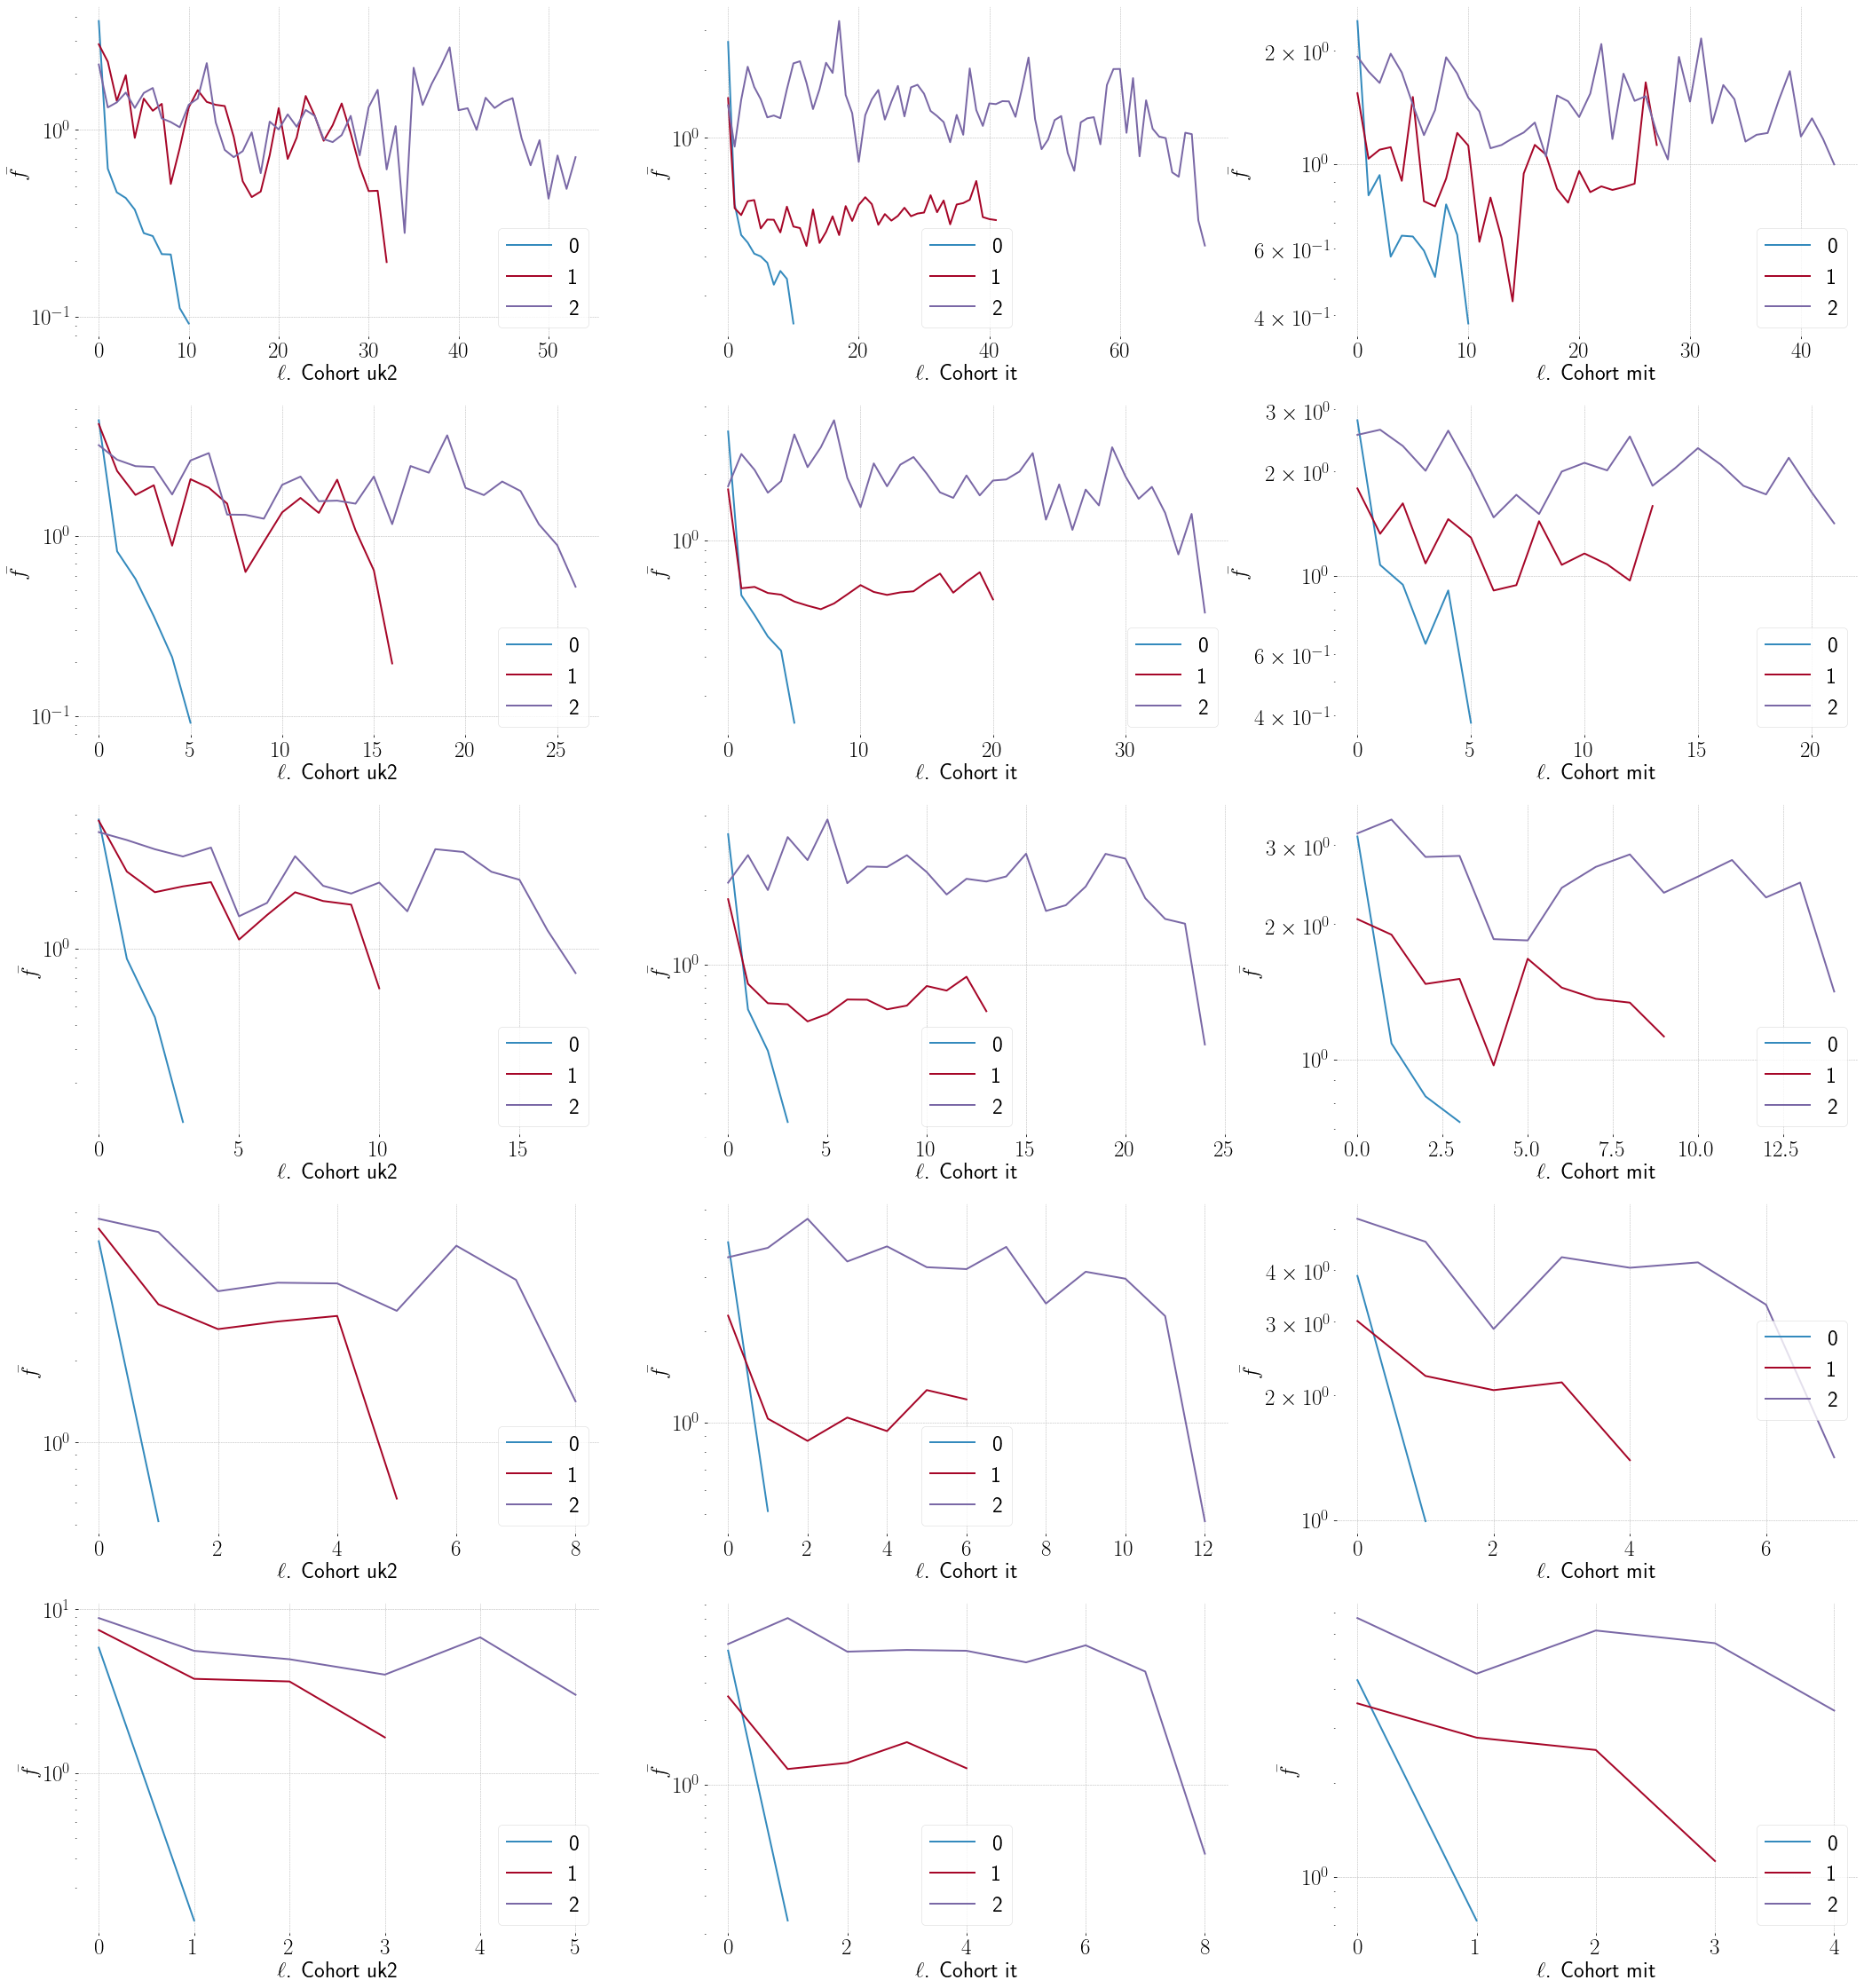

In [49]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk2', 'it', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(fr'$\ell$. Cohort {c}')
        plt.ylabel(r'$\bar{f}$')
        plt.semilogy()
        for i in range(3):
            plt.plot(Deltaa[c][Da][i]['f'].index, Deltaa[c][Da][i]['f']['f'], label=f'{i}')
        plt.legend()
        p += 1

In [50]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]['f']
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [51]:
useegos = []
for e in fig1['mit'][2]['fi'].keys():
    if len(fig1['mit'][2]['fi'][e].index) >= 10:
        useegos.append(e)

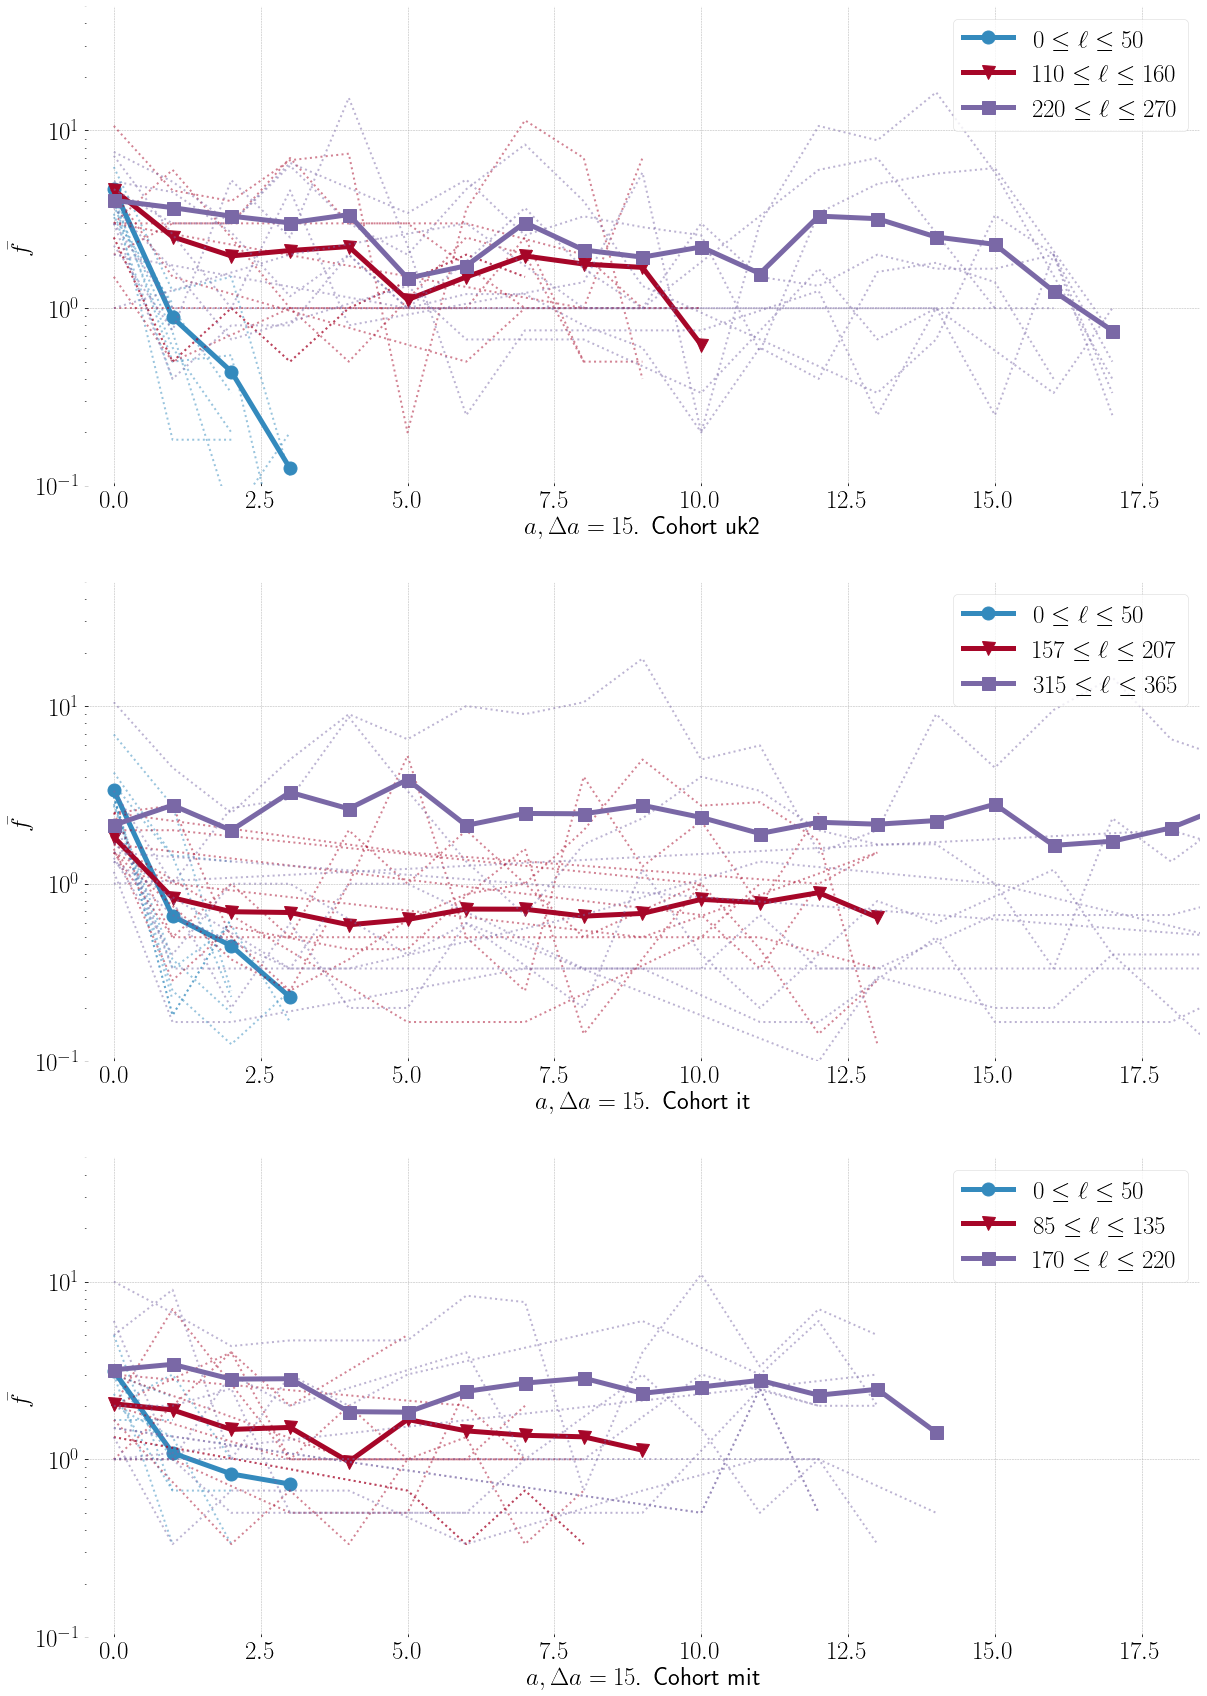

In [52]:
np.random.seed(0)
tmp = pd.DataFrame(index=range(18))
plt.figure(figsize=(20, 10*3))
p = 1
for c in ['uk2', 'it', 'mit']:
    plt.subplot(3, 1, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 18.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        if c != 'sss':
            egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        else:
            egos = np.random.choice(useegos, size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [53]:
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

In [54]:
tmp

uk20avg    uk20e1    uk20e2  uk20e3    uk20e4  uk20e5  uk20e6  uk20e7  \
0   4.701898  4.166667  4.304348     3.4  3.933333    14.0  3.2500    14.0   
1   0.886409  1.000000  0.500000     0.4  0.733333     NaN  1.0625     NaN   
2   0.439942  0.333333  0.543478     NaN  0.066667     NaN     NaN     NaN   
3   0.125345       NaN  0.021739     NaN  0.200000     NaN     NaN     NaN   
4        NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
5        NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
6        NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
7        NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
8        NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
9        NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
10       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
11       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
12       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
13       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
14       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
15       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
16       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
17       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
18       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
19       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
20       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
21       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
22       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
23       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   
24       NaN       NaN       NaN     NaN       NaN     NaN     NaN     NaN   

      uk20e8    uk20e9  ...  mit2e1  mit2e2  mit2e3  mit2e4  mit2e5  mit2e6  \
0   4.272727  6.227273  ...     1.5     6.0     1.0     1.0     1.5     5.0   
1   0.181818  1.250000  ...     NaN     1.0     1.0     NaN     NaN     9.0   
2   0.181818  1.500000  ...     NaN     3.0     0.5     NaN     NaN     1.0   
3        NaN  0.113636  ...     NaN     2.0     NaN     NaN     NaN     3.0   
4        NaN       NaN  ...     NaN     NaN     0.5     NaN     NaN     2.0   
5        NaN       NaN  ...     NaN     NaN     0.5     NaN     NaN     3.0   
6        NaN       NaN  ...     NaN     4.0     0.5     NaN     NaN     NaN   
7        NaN       NaN  ...     NaN     1.0     1.0     NaN     NaN     NaN   
8        NaN       NaN  ...     NaN     1.0     NaN     NaN     NaN     NaN   
9        NaN       NaN  ...     NaN     NaN     3.0     NaN     NaN     6.0   
10       NaN       NaN  ...     0.5     3.0     1.5     NaN     0.5     NaN   
11       NaN       NaN  ...     2.5     NaN     0.5     NaN     2.5     3.0   
12       NaN       NaN  ...     0.5     2.0     1.0     NaN     0.5     6.0   
13       NaN       NaN  ...     NaN     NaN     NaN     3.0     NaN     2.0   
14       NaN       NaN  ...     NaN     NaN     0.5     NaN     NaN     NaN   
15       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
16       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
17       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
18       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
19       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
20       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
21       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
22       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
23       NaN       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2

## $b(\ell)$ by cohort

Only when it converges. I may try to  bin the values of $b$ to make it smoother. Also, I will calculate the same measurement considering a combined cohort.

In [55]:
# dffcomb['all'] = {}
# for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
#     dffcomb['all'].update(dffcomb[c])

In [56]:
t0 = dt.datetime.now()
b = {}
b2 = {}
converge = {}
converge2 = {}
nalt = {}
nego = {}
for c in ['uk2', 'it', 'mit', 'all']:
    b[c] = {}
    b2[c] = {}
    converge[c] = {}
    converge2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(366):
        curve = pc.get_fal(calls[c], ell, ell + 50, 15, countalters=True)
        if (curve is not None) and (len(curve['f']) > 2):
            points = pc.get_b_slopes(curve['f'], FlagConverge=True)
            points2 = pc.get_b_mk(curve['f'], FlagConverge=True)
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            converge[c][ell] = points[2]
            converge2[c][ell] = points2[2]
            nalt[c][ell] = curve['nalters']
            nego[c][ell] = curve['egocount']
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmpb2 = pd.DataFrame.from_dict(b2[c], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
    tmpc2 = pd.DataFrame.from_dict(converge2[c], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmpb2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmpc2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
    b[c]['mas'] = b[c]['slopes'].rolling(window=50).mean()
    b[c]['mam'] = b[c]['mk'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:02:42.931982


In [57]:
for c in b.keys():
    print(c, b[c]['convm'].mean())

uk2 0.0
it 0.0
mit 0.0
all 0.0


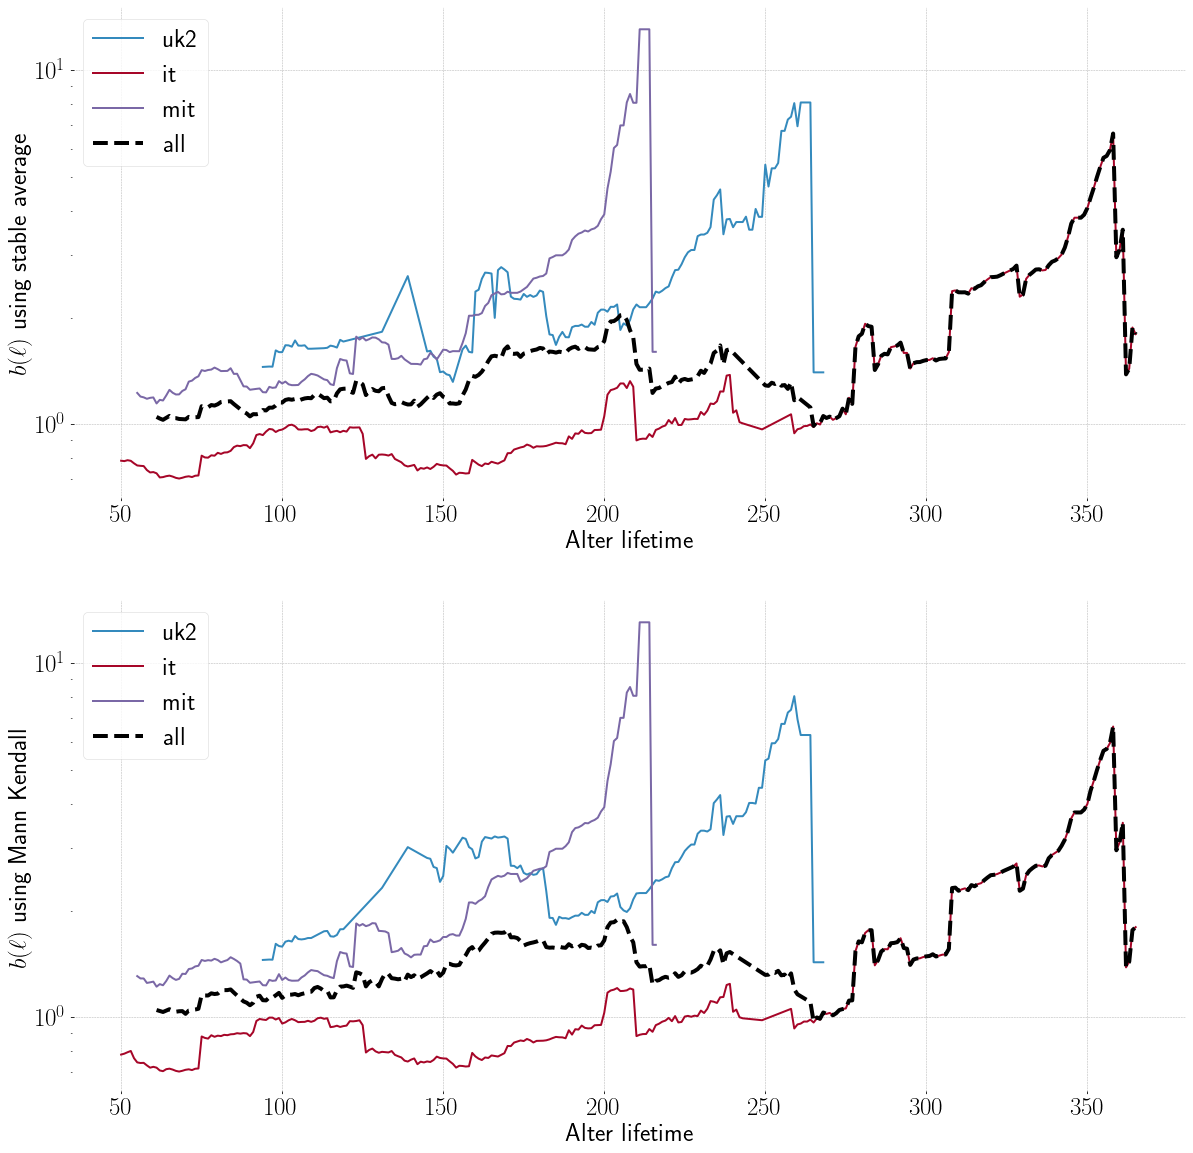

In [58]:
plt.figure(figsize=(20*1, 10*2))
plt.subplot(211)
plt.semilogy()
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using stable average")
for c in ['uk2', 'it', 'mit', 'all']:
    df = b[c].loc[b[c]['convs'] == True]
    if c != 'all':
        plt.plot(df.index, df['slopes'], label=c)
    else:
        plt.plot(df.index, df['slopes'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

plt.subplot(212)
plt.semilogy()
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using Mann Kendall")
for c in ['uk2', 'it', 'mit', 'all']:
    df = b[c].loc[b[c]['convs'] == True]
    if c != 'all':
        plt.plot(df.index, df['mk'], label=c)
    else:
        plt.plot(df.index, df['mk'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

In [59]:
binsize = 50
bbins = {}
for c in b.keys():
    df = b[c].loc[b[c]['convs'] == True]
    df2 = df[['slopes', 'mk']].copy()
    df2['lambda'] = df.index.map(lambda x: x // binsize)
    bbins[c] = df2.groupby('lambda').mean()
    bbins[c]['x'] = bbins[c].index.map(lambda x: (x * binsize) + (binsize // 2))

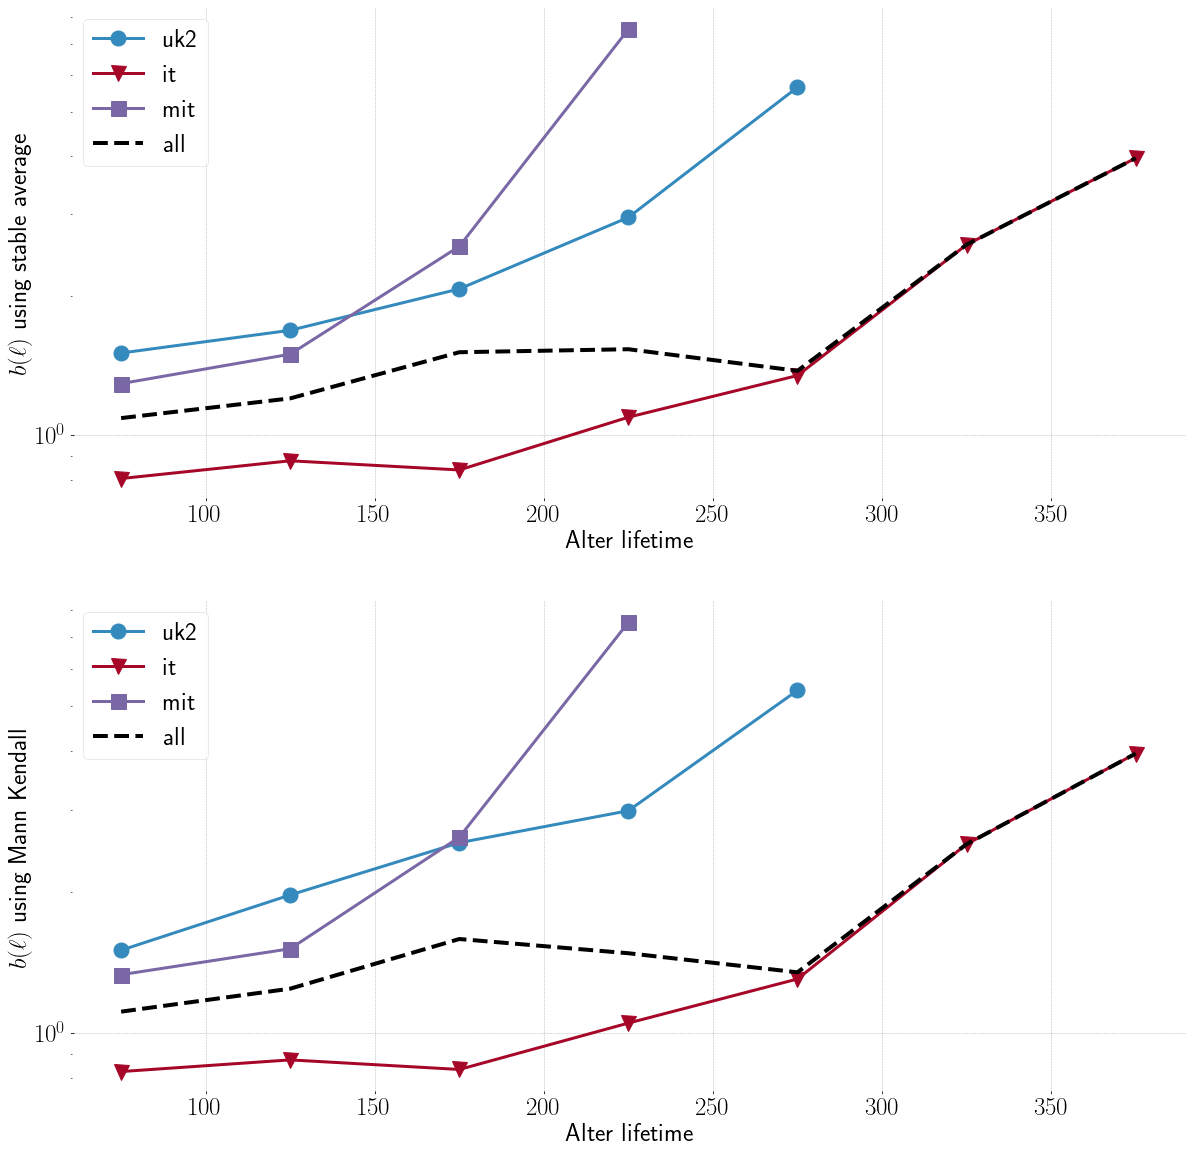

In [60]:
plt.figure(figsize=(20*1, 10*2))
plt.subplot(211)
plt.semilogy()
# plt.xlim(30, 370)
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using stable average")
m = -1
for c in ['uk2', 'it', 'mit', 'all']:
    if c != 'all':
        m += 1
        plt.plot(bbins[c]['x'], bbins[c]['slopes'], marker=markers[m], markersize=15, ls="solid", lw=3, 
                 c=colors[m], label=c)
    else:
        plt.plot(bbins[c]['x'], bbins[c]['slopes'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

plt.subplot(212)
plt.semilogy()
# plt.xlim(30, 370)
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using Mann Kendall")
m = -1
for c in ['uk2', 'it', 'mit', 'all']:
    if c != 'all':
        m += 1
        plt.plot(bbins[c]['x'], bbins[c]['mk'], marker=markers[m], markersize=15, ls="solid", lw=3, 
                 color=colors[m], label=c)
    else:
        plt.plot(bbins[c]['x'], bbins[c]['mk'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

In [61]:
tmp = pd.DataFrame()
for c in bbins.keys():
    # df = bbins[c].loc[bbins[c]['x'] < 300]
    df = bbins[c].copy(deep=True)
    df.columns = [f's{c}', f'm{c}', f'x{c}']
    tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", index=False, header=True, sep="\t")

In [62]:
tmp

suk2      muk2   xuk2       sit       mit  xit      smit  \
lambda                                                                 
1       1.503536  1.501200   75.0  0.805081  0.826060   75  1.291252   
2       1.683554  1.970657  125.0  0.879423  0.874879  125  1.494848   
3       2.068458  2.548559  175.0  0.840179  0.834625  175  2.555743   
4       2.952863  2.983570  225.0  1.092438  1.048774  225  7.529694   
5       5.642923  5.396441  275.0  1.344141  1.302970  275       NaN   
6            NaN       NaN    NaN  2.577591  2.531012  325       NaN   
7            NaN       NaN    NaN  3.964856  3.952774  375       NaN   

            mmit   xmit      sall      mall  xall  
lambda                                             
1       1.330928   75.0  1.087599  1.109490    75  
2       1.512192  125.0  1.199705  1.242235   125  
3       2.618488  175.0  1.509500  1.586389   175  
4       7.543845  225.0  1.532226  1.479085   225  
5            NaN    NaN  1.375976  1.346604   275  
6            NaN    NaN  2.577591  2.531012   325  
7            NaN    NaN  3.964856  3.952774   375

## Distribution of $b_i(\ell)$

In [63]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [64]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.665214233841685, 0.01) (0.665214233841685, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.1165376495425756, 0.01) (1.1165376495425756, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.775213675213675, 0.01) (1.775213675213675, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.3761609907120743, 0.01) (0.3761609907120743, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.5263636363636363, 0.01) (0.5263636363636363, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(0.7938339920948616, 0.01) (0.7938339920948616, 1)};
=====================mit========================
\addplot[dashed, charmander, line width = 4] coordinates {(1.1664197530864198, 0.01) (1.1664197530864198, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.7407407407407408, 0.01) (0.740740740

In [65]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", index=False, header=True, sep="\t")

### Now using mann kendall

In [66]:
bhist2 = {}
for c in fig1.keys():
    bhist2[c] = {}
    for lamb in fig1[c].keys():
        bhist2[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve2 = fig1[c][lamb]['fi'][ego]
            if len(curve2) > 1:
                b = pc.get_b_mk(curve2)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist2[c][lamb].append(b[1][1])

In [67]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist2[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5b.dat", index=False, header=True, sep="\t")

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.665214233841685, 0.01) (0.665214233841685, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.1165376495425756, 0.01) (1.1165376495425756, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.775213675213675, 0.01) (1.775213675213675, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.3761609907120743, 0.01) (0.3761609907120743, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.5263636363636363, 0.01) (0.5263636363636363, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(0.7938339920948616, 0.01) (0.7938339920948616, 1)};
=====================mit========================
\addplot[dashed, charmander, line width = 4] coordinates {(1.1664197530864198, 0.01) (1.1664197530864198, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.7679012345679012, 0.01) (0.767901234

## $p$-value distribution for the KS test

In [68]:
ksp = {}
for c in ['uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

============	UK2	=================
0.8440065681444993
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8174603174603173, 0.04) (0.8174603174603173, 1)};
0.7322388314171189
\addplot[ekans, dashed, line width = 4] coordinates{(0.7072727272727272, 0.04) (0.7072727272727272, 1)};
============	IT	=================
0.8456568384534486
\addplot[squirtle, dashed, line width = 4] coordinates{(0.811798371120405, 0.04) (0.811798371120405, 1)};
0.8644975892151536
\addplot[ekans, dashed, line width = 4] coordinates{(0.8344573748163687, 0.04) (0.8344573748163687, 1)};
============	MIT	=================
0.9361111111111112
\addplot[squirtle, dashed, line width = 4] coordinates{(0.9067857142857143, 0.04) (0.9067857142857143, 1)};
0.8748494443409697
\addplot[ekans, dashed, line width = 4] coordinates{(0.843990755007704, 0.04) (0.843990755007704, 1)};


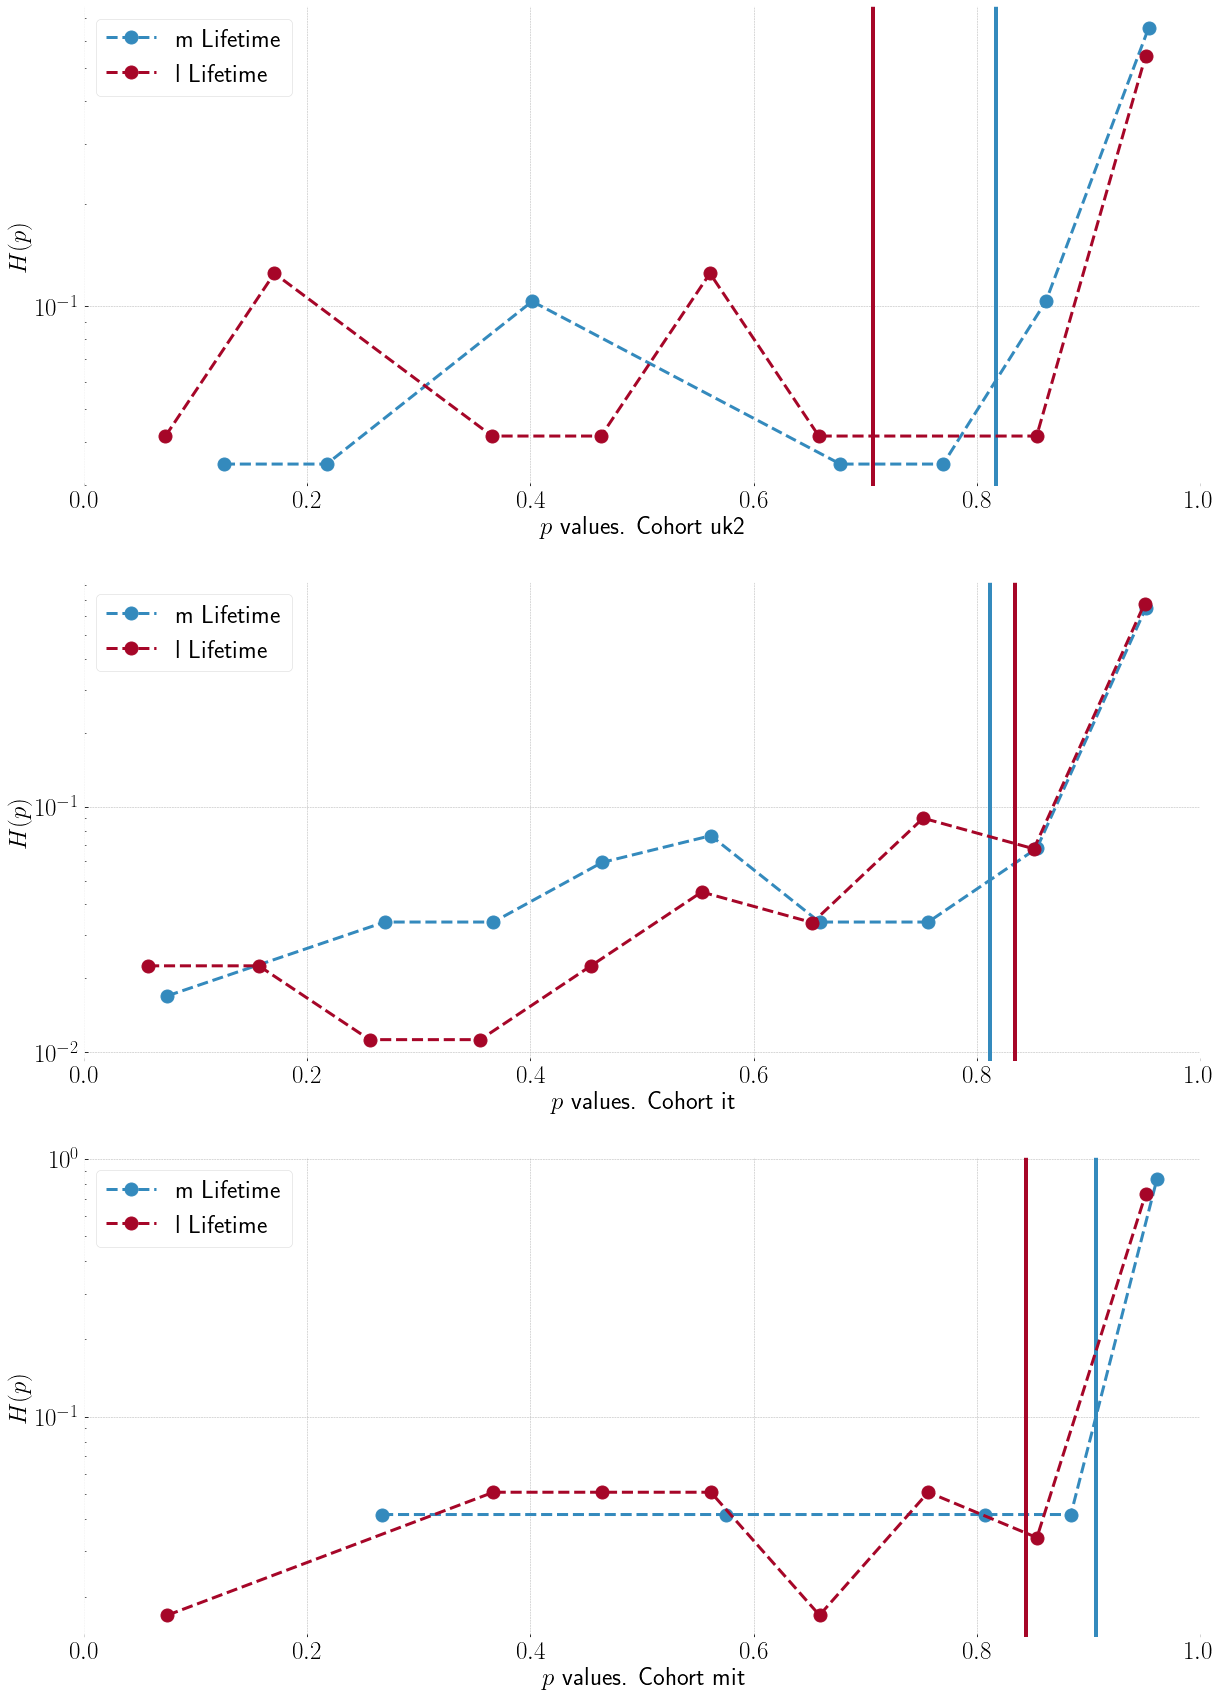

In [69]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20, 10*3))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(3,1, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        print(np.mean(ksp[c][s]))
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.04) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1

In [70]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S6.dat", index=False, header=True, sep="\t")

## Identify $\ell_s$ for each cohort



In [71]:
def get_ells(bdf, col, lookforward=15):
    df = bdf[[col]].rolling(lookforward).mean()
    df2 = df.loc[df[col] == 1]
    if len(df2) > 0:
        return min(df2.index)
    else:
        return None

In [72]:
egolist = {}
for c in ['uk2', 'it', 'mit']:
    egolist[c] = [ego for ego in calls[c]['ego'].unique()]

In [73]:
t0 = dt.datetime.now()
bi = {}
bi2 = {}
convergei = {}
convergei2 = {}
niter = {}
for c in ['uk2', 'it', 'mit']:
    bi[c] = {}
    bi2[c] = {}
    convergei[c] = {}
    convergei2[c] = {}
    niter[c] = {}
    dff = pc.get_f(calls[c], 'all', 15, 10)
    for ego in dff.keys():
        bi[c][ego] = {}
        bi2[c][ego] = {}
        convergei[c][ego] = {}
        convergei2[c][ego] = {}
        niter[c][ego] = {}
        dffl = {ego: dff[ego]}
        for ell in range(301):
            curve = pc.get_avgfa(dffl, lives[c], ell, ell + 50)
            if (curve is not None) and (len(curve) > 3):
                points = pc.get_b_slopes(curve, FlagConverge=True)
                points2 = pc.get_b_mk(curve, FlagConverge=True)
                bi[c][ego][ell] = points[1][1]
                bi2[c][ego][ell] = points2[1][1]
                convergei[c][ego][ell] = points[2]
                convergei2[c][ego][ell] = points2[2]
                niter[c][ego][ell] =  points2[3]
        if len(bi[c][ego].keys()) > 0:
            bi[c][ego] = pd.DataFrame.from_dict(bi[c][ego], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
            tmp = pd.DataFrame.from_dict(convergei[c][ego], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
            if ego in bi2[c].keys():
                tmpb2 = pd.DataFrame.from_dict(bi2[c][ego], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
                tmpc2 = pd.DataFrame.from_dict(convergei2[c][ego], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
            bi[c][ego] = bi[c][ego].merge(tmp, left_index=True, right_index=True, how='outer')
            if ego in bi2[c].keys():
                bi[c][ego] = bi[c][ego].merge(tmpb2, left_index=True, right_index=True, how='outer')
                bi[c][ego] = bi[c][ego].merge(tmpc2, left_index=True, right_index=True, how='outer')
                bi[c][ego]['mam'] = bi[c][ego]['mk'].rolling(window=50).mean()
            bi[c][ego]['mas'] = bi[c][ego]['slopes'].rolling(window=50).mean()
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:02:34.318851


In [74]:
for ego in bi['mit'].keys():
    if type(bi['mit'][ego]) == pd.core.frame.DataFrame:
        print(np.mean(bi['mit'][ego]['convs']))

0.0
0.4745762711864407
0.8058252427184466
0.8333333333333334
1.0
1.0
0.3221476510067114
0.839622641509434
0.6451612903225806
0.8855421686746988
0.0
1.0
0.7301587301587301
0.7738095238095238
0.6474358974358975
0.7132352941176471
0.22142857142857142
0.8023255813953488
0.4322916666666667
0.7584269662921348
0.6829268292682927
0.6214689265536724
0.6140350877192983
0.058333333333333334
0.0
0.6111111111111112
0.52
0.5588235294117647
0.9636363636363636
1.0
0.6984126984126984
0.7132867132867133
0.6859903381642513
0.0
1.0
1.0
1.0
0.4943181818181818
1.0
0.0
0.0
1.0
1.0
0.51
0.5188679245283019
0.6714285714285714
0.9119496855345912
0.6228571428571429
0.6888888888888889
0.0392156862745098
0.17777777777777778
0.9809523809523809
0.9444444444444444
1.0
0.37362637362637363
0.0
0.8717948717948718
0.796875
0.9230769230769231
1.0
1.0
0.4791666666666667
0.0
1.0
0.4117647058823529
0.6375
0.08928571428571429
0.6764705882352942
0.5730337078651685
0.0
1.0
0.49038461538461536
0.0
0.0
0.6197183098591549
0.7647058

In [75]:
bif = {}
bif['all'] = {}
for c in bi.keys():
    bif[c] = {}
    for ego in bi[c].keys():
        if type(bi[c][ego]) == pd.core.frame.DataFrame:
            bif[c][ego] = bi[c][ego]
            bif['all'].update(bif[c])

In [76]:
for c in ['uk2', 'it', 'mit']:
    for ego in bif[c].keys():
        if ego not in bif['all'].keys():
            print('problem with', c, ego)
    else:
        print('success!', c)

success! uk2
success! it
success! mit


In [77]:
ellsHs = {}
for c in bif.keys():
    ellsHs[c] = pc.histogram([get_ells(bif[c][ego], 'convs', lookforward=10) for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None], 10, log=False)

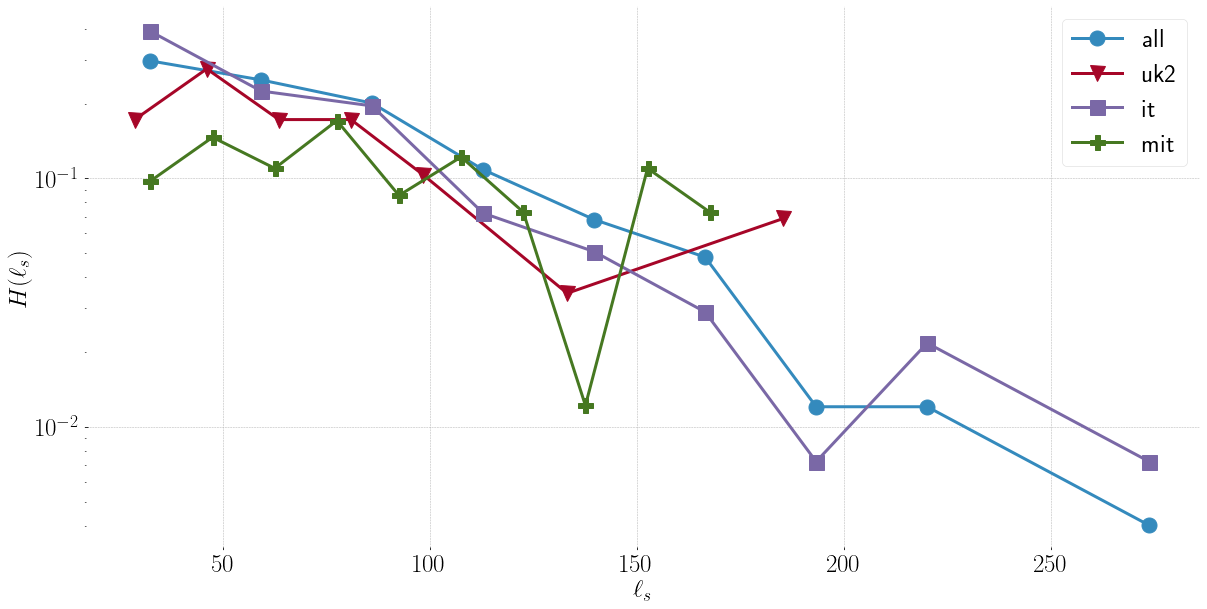

In [78]:
plt.semilogy()
plt.xlabel(r'$\ell_s$')
plt.ylabel(r'$H(\ell_s)$')
m = 0
for c in ellsHs.keys():
    plt.plot(ellsHs[c]['label'], ellsHs[c]['pmf'], marker=markers[m], ls="solid", markersize=15, lw=3, label=f'{c}')
    m += 1
plt.legend()

In [79]:
ellsHm = {}
for c in bif.keys():
    listells = [get_ells(bif[c][ego], 'convm') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convm') is not None]
    if len(listells) > 0:
        ellsHm[c] = pc.histogram(listells, 10, log=False)

In [80]:
tmp = pd.DataFrame()
for c in ellsHs.keys():
    print(f'================{c}=====================')
    H = ellsHs[c].copy(deep=True)
    H['tmp'] = H['label'] * H['h']
    avg = sum(H['tmp']) / sum(H['h'])
    print(avg)
    H = H[['label', 'pmf']]
    H = H.rename({'label': f'x{c}', 'pmf': f'y{c}'}, axis='columns')
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S9.dat", index=False, header=True, sep="\t")

================all=====================
77.49718875502008
================uk2=====================
70.1
================it=====================
71.04637681159421
================mit=====================
90.85365853658537


In [81]:
tmp

xall      yall   xuk2      yuk2    xit       yit   xmit      ymit
0   32.4  0.297189   28.7  0.172414   32.4  0.391304   32.5  0.097561
1   59.2  0.248996   46.1  0.275862   59.2  0.224638   47.5  0.146341
2   86.0  0.200803   63.5  0.172414   86.0  0.195652   62.5  0.109756
3  112.8  0.108434   80.9  0.172414  112.8  0.072464   77.5  0.170732
4  139.6  0.068273   98.3  0.103448  139.6  0.050725   92.5  0.085366
5  166.4  0.048193    NaN       NaN  166.4  0.028986  107.5  0.121951
6  193.2  0.012048  133.1  0.034483  193.2  0.007246  122.5  0.073171
7  220.0  0.012048    NaN       NaN  220.0  0.021739  137.5  0.012195
8    NaN       NaN    NaN       NaN    NaN       NaN  152.5  0.109756
9  273.6  0.004016  185.3  0.068966  273.6  0.007246  167.5  0.073171

### Estimation from a regression

In [82]:
ellsHs['all']['logp'] = np.log(ellsHs['all']['pmf'])
ellsHs['all']

h       pmf  label      logp
0  74  0.297189   32.4 -1.213388
1  62  0.248996   59.2 -1.390319
2  50  0.200803   86.0 -1.605430
3  27  0.108434  112.8 -2.221616
4  17  0.068273  139.6 -2.684240
5  12  0.048193  166.4 -3.032546
6   3  0.012048  193.2 -4.418841
7   3  0.012048  220.0 -4.418841
9   1  0.004016  273.6 -5.517453

In [83]:
Y = np.array(ellsHs['all']['logp'])
X = np.array(ellsHs['all']['label'])
X = sm.add_constant(X)

In [84]:
model = sm.OLS(Y, X)
result = model.fit()
result.summary()

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     189.2
Date:                Tue, 15 Feb 2022   Prob (F-statistic):           2.53e-06
Time:                        09:49:15   Log-Likelihood:                -1.0797
No. Observations:                   9   AIC:                             6.159
Df Residuals:                       7   BIC:                             6.554
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2177      0.223     -0.974      0.362      -0.746       0.311
x1            -0.0191      0.001    -13.754      0.000      -0.022      -0.016
==============================================================================
Omnibus:                        0.972   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                0.718
Skew:                          -0.570   Prob(JB):                        0.698
Kurtosis:                       2.215   Cond. No.                         348.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
result.params

array([-0.21768728, -0.01912678])

In [86]:
np.exp(result.params[0])

0.8043769434278797

In [87]:
-1 / result.params[1]

52.28271034314185

In [88]:
for c in bif.keys():
    thelist = [get_ells(bif[c][ego], 'convs') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None]
    print(c, np.mean(thelist), min(thelist))

all 84.63855421686748 24
uk2 76.34482758620689 25
it 79.94927536231884 24
mit 95.46341463414635 30


## Fig 3 separated by country

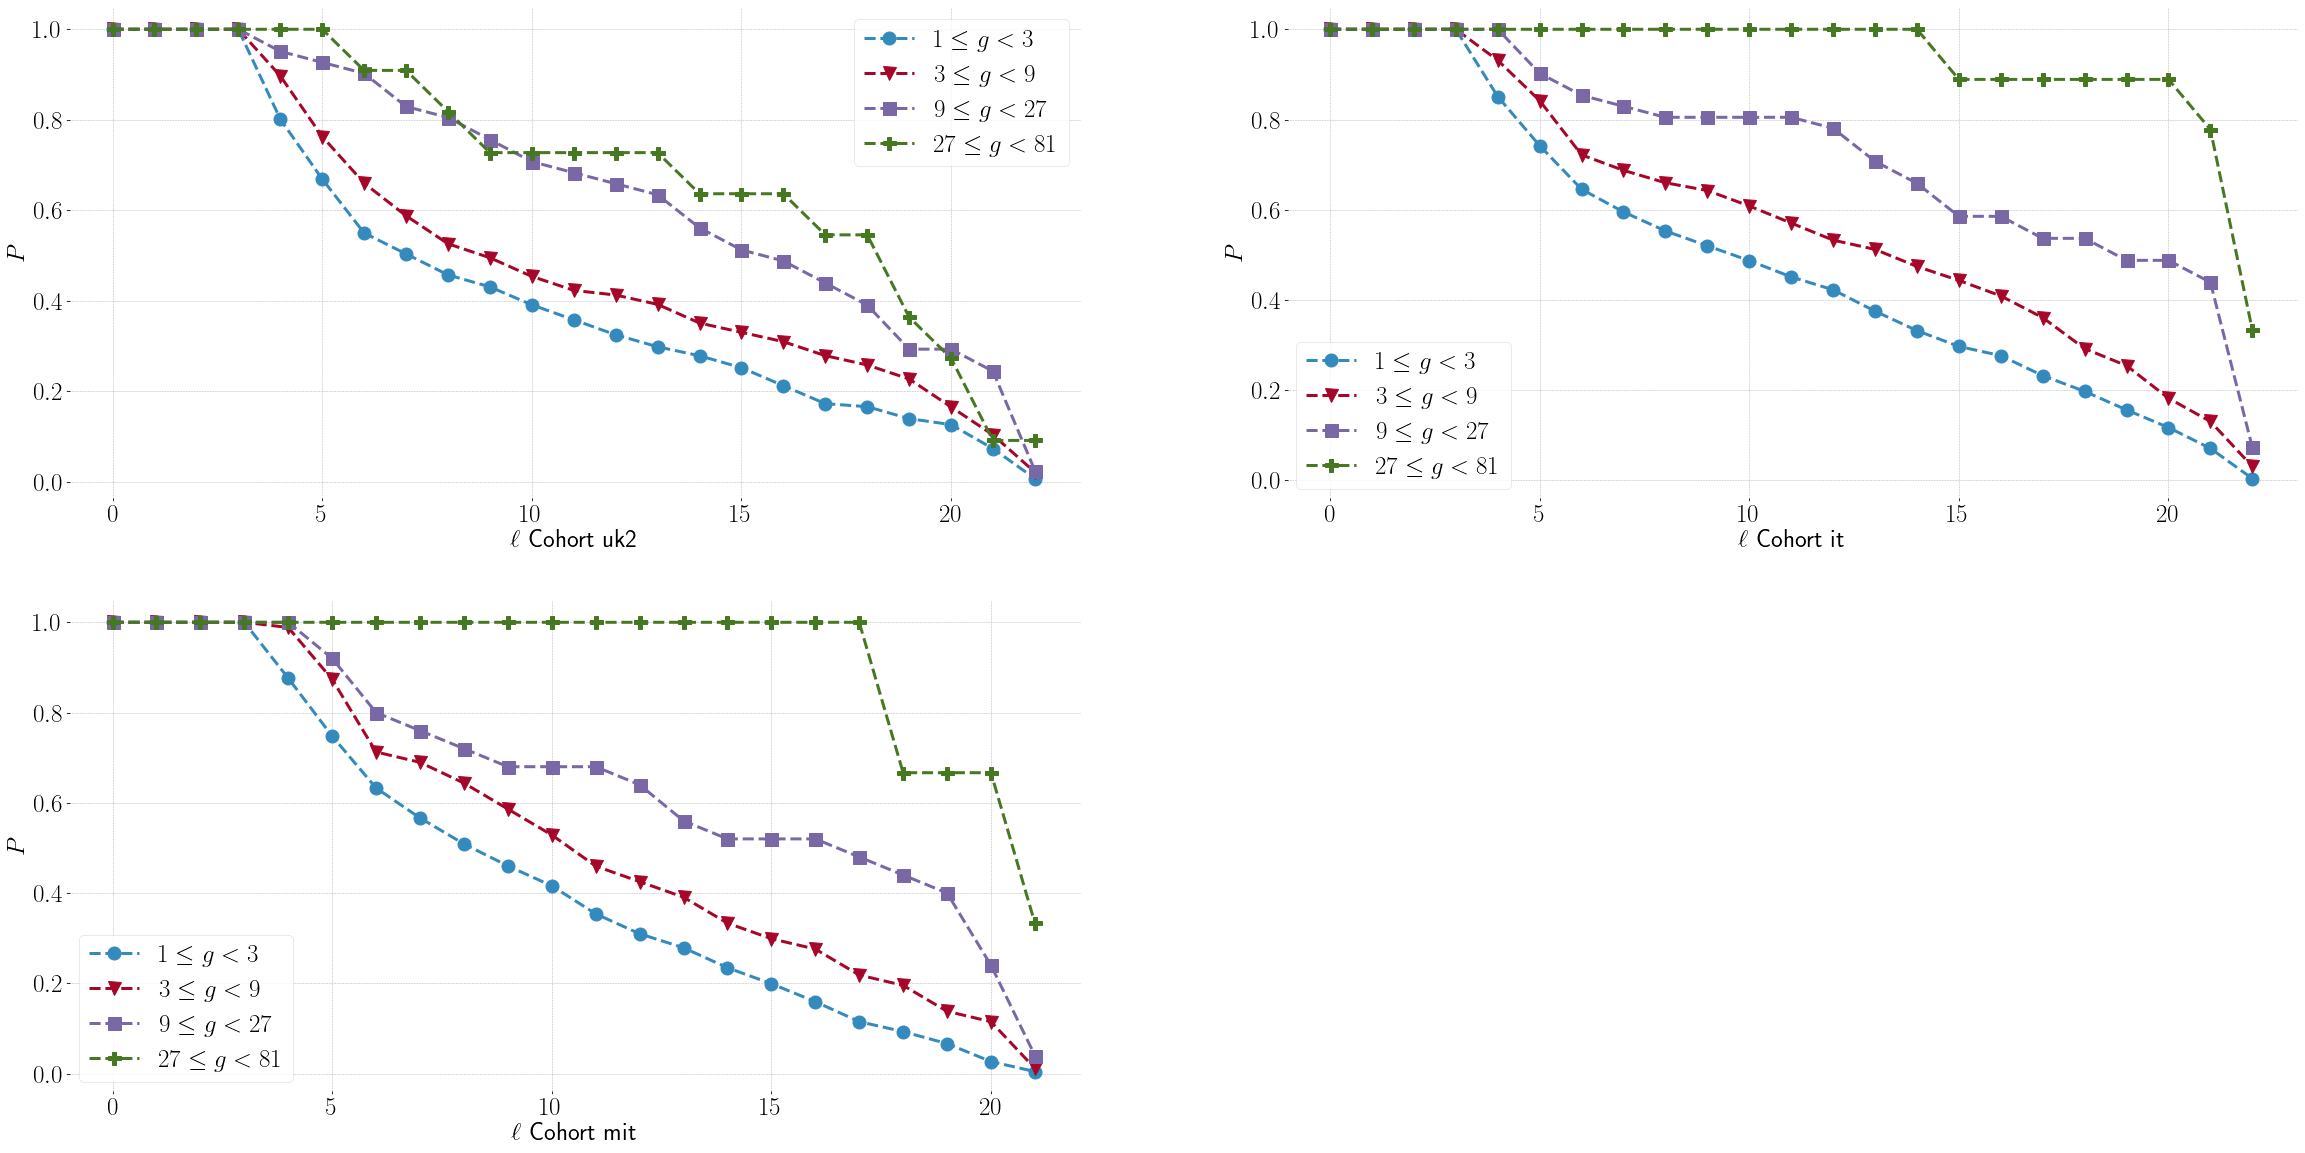

In [89]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(4):
        plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${3**i} \leq g < {3**(i + 1)}$')
    plt.legend()
    p += 1

In [90]:
tmp = pd.DataFrame()
for c in ['uk2', 'mit', 'it']:
    for i in range(4):
        tmp[f'{c}{i}'] = fig3b[c][i]
        
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
tmp = tmp.fillna('nan')
tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S7.dat", index=True, header=True, sep="\t")

In [91]:
tmp

uk20      uk21      uk22      uk23      mit0      mit1  mit2  \
a                                                                       
0    1.000000  1.000000  1.000000  1.000000       1.0       1.0   1.0   
10   1.000000  1.000000  1.000000  1.000000       1.0       1.0   1.0   
20   1.000000  1.000000  1.000000  1.000000       1.0       1.0   1.0   
30   1.000000  1.000000  1.000000  1.000000       1.0       1.0   1.0   
40   0.801325  0.896907  0.951220  1.000000  0.876106  0.988506   1.0   
50   0.668874  0.762887  0.926829  1.000000  0.747788  0.873563  0.92   
60   0.549669  0.659794  0.902439  0.909091  0.632743  0.712644   0.8   
70   0.503311  0.587629  0.829268  0.909091  0.566372  0.689655  0.76   
80   0.456954  0.525773  0.804878  0.818182   0.50885  0.643678  0.72   
90   0.430464  0.494845  0.756098  0.727273  0.460177  0.586207  0.68   
100  0.390728  0.453608  0.707317  0.727273  0.415929  0.528736  0.68   
110  0.357616  0.422680  0.682927  0.727273  0.353982   0.45977  0.68   
120  0.324503  0.412371  0.658537  0.727273  0.309735  0.425287  0.64   
130  0.298013  0.391753  0.634146  0.727273  0.278761  0.390805  0.56   
140  0.278146  0.350515  0.560976  0.636364  0.234513  0.333333  0.52   
150  0.251656  0.329897  0.512195  0.636364  0.199115  0.298851  0.52   
160  0.211921  0.309278  0.487805  0.636364  0.159292  0.275862  0.52   
170  0.172185  0.278351  0.439024  0.545455  0.115044  0.218391  0.48   
180  0.165563  0.257732  0.390244  0.545455   0.09292  0.195402  0.44   
190  0.139073  0.226804  0.292683  0.363636  0.066372  0.137931   0.4   
200  0.125828  0.164948  0.292683  0.272727  0.026549  0.114943  0.24   
210  0.072848  0.103093  0.243902  0.090909  0.004425  0.011494  0.04   
220  0.006623  0.020619  0.024390  0.090909       nan       nan   nan   

         mit3       it0       it1       it2       it3  
a                                                      
0         1.0  1.000000  1.000000  1.000000  1.000000  
10        1.0  1.000000  1.000000  1.000000  1.000000  
20        1.0  1.000000  1.000000  1.000000  1.000000  
30        1.0  1.000000  1.000000  1.000000  1.000000  
40        1.0  0.850976  0.931271  1.000000  1.000000  
50        1.0  0.742035  0.841924  0.902439  1.000000  
60        1.0  0.645427  0.721649  0.853659  1.000000  
70        1.0  0.595067  0.687285  0.829268  1.000000  
80        1.0  0.552929  0.659794  0.804878  1.000000  
90        1.0  0.520041  0.642612  0.804878  1.000000  
100       1.0  0.487153  0.608247  0.804878  1.000000  
110       1.0  0.451182  0.570447  0.804878  1.000000  
120       1.0  0.422405  0.532646  0.780488  1.000000  
130       1.0  0.375128  0.512027  0.707317  1.000000  
140       1.0  0.331963  0.474227  0.658537  1.000000  
150       1.0  0.297020  0.443299  0.585366  0.888889  
160       1.0  0.276465  0.408935  0.585366  0.888889  
170       1.0  0.232271  0.360825  0.536585  0.888889  
180  0.666667  0.197328  0.292096  0.536585  0.888889  
190  0.666667  0.156218  0.254296  0.487805  0.888889  
200  0.666667  0.117163  0.182131  0.487805  0.888889  
210  0.333333  0.070915  0.130584  0.439024  0.777778  
220       nan  0.004111  0.030928  0.073171  0.333333

### Alternative function

In [92]:
# plt.figure(figsize=(20*2, 10*2))
# p = 1
# for c in ['uk', 'uk2', 'it', 'mit']:
#     plt.subplot(2,2,p)
#     plt.xlabel(fr"$\ell$ Cohort {c}")
#     plt.ylabel(r"$P$")
#     for i in range(1,6):
#         plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
#     plt.legend()
#     p += 1

## Change values of $a_o$ and $a_f$ for fig3

In [93]:
elements = [(0, 15), (30, 45), (60, 75), (0, 30), (30, 60), (60, 90), (0, 45), (30, 75), (60, 105), (0, 60), (30, 90), (60, 120)]

In [94]:
t0 = dt.datetime.now()
Ssva = {}
for p in range(len(elements)):
    Ssva[p + 1] = pc.get_survival2(calls['all'], elements[p][0], elements[p][1], maxell=220, base=3)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.543238


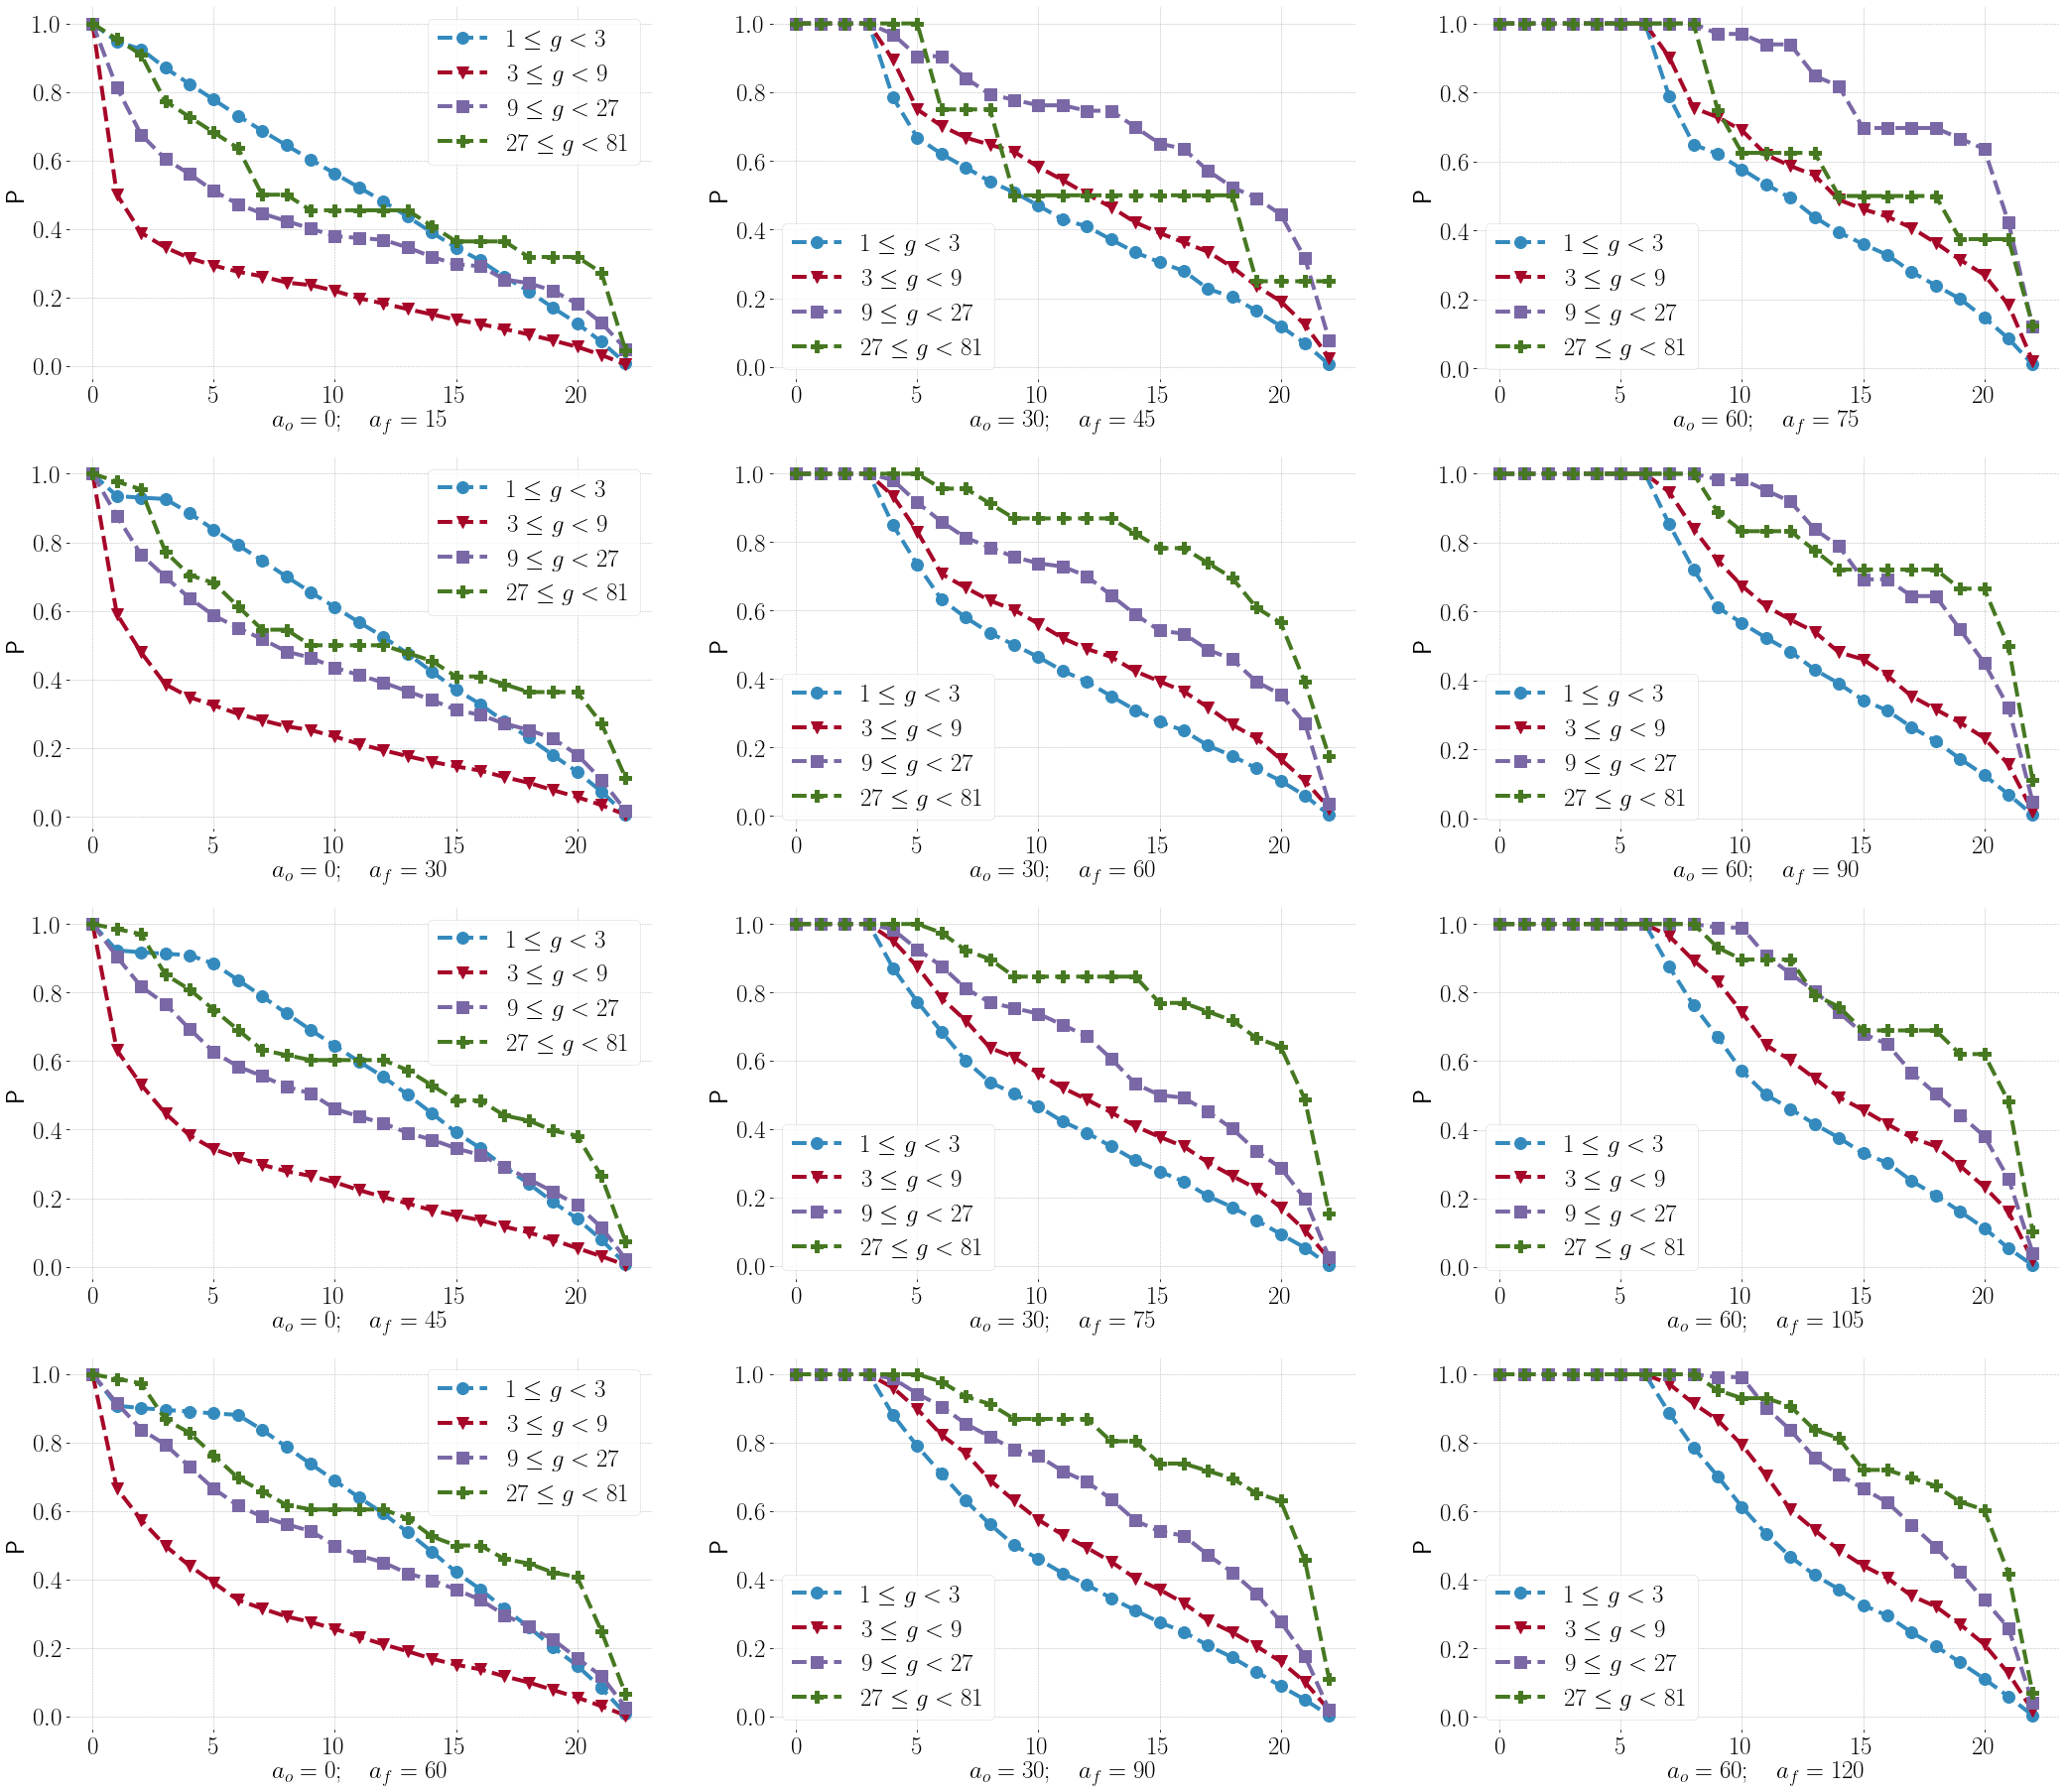

In [95]:
plt.figure(figsize=(12*3, 8*4))
for p in Ssva.keys():
    plt.subplot(4,3,p)
    plt.xlabel(fr'$a_o = {elements[p-1][0]}; \quad a_f = {elements[p-1][1]}$')
    plt.ylabel(r'P')
    for i in range(4):
        plt.plot(Ssva[p][i].index, Ssva[p][i]['p'], marker=markers[i], ls="dashed", lw=4, markersize=12, label=fr'${3**i} \leq g < {3**(i + 1)}$')
    plt.legend()

In [96]:
tmp = pd.DataFrame()
for p in Ssva.keys():
    for i in range(4):
        df = Ssva[p][i].copy(deep=True)
        df.columns=[f'p{p}s{i}']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S8.dat", index=True, header=True, sep='\t')

In [97]:
tmp

p1s0      p1s1      p1s2      p1s3      p2s0      p2s1      p2s2  \
a                                                                           
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10   0.947115  0.501101  0.813187  0.954545  1.000000  1.000000  1.000000   
20   0.924880  0.388815  0.675824  0.909091  1.000000  1.000000  1.000000   
30   0.870192  0.346103  0.604396  0.772727  1.000000  1.000000  1.000000   
40   0.823317  0.314839  0.560440  0.727273  0.784043  0.893836  0.968254   
50   0.777644  0.293263  0.510989  0.681818  0.668085  0.750000  0.904762   
60   0.730769  0.275209  0.472527  0.636364  0.620213  0.702055  0.904762   
70   0.686599  0.261559  0.445055  0.500000  0.580851  0.667808  0.841270   
80   0.644231  0.243505  0.423077  0.500000  0.540426  0.647260  0.793651   
90   0.602764  0.236019  0.401099  0.454545  0.508511  0.626712  0.777778   
100  0.561599  0.219287  0.379121  0.454545  0.470213  0.582192  0.761905   
110  0.521034  0.197710  0.373626  0.454545  0.429787  0.544521  0.761905   
120  0.480469  0.182299  0.368132  0.454545  0.409574  0.503425  0.746032   
130  0.435998  0.166006  0.346154  0.454545  0.371277  0.465753  0.746032   
140  0.389724  0.150594  0.318681  0.409091  0.334043  0.421233  0.698413   
150  0.345553  0.134742  0.296703  0.363636  0.305319  0.390411  0.650794   
160  0.307993  0.122413  0.291209  0.363636  0.279787  0.363014  0.634921   
170  0.260216  0.107882  0.252747  0.363636  0.227660  0.335616  0.571429   
180  0.218149  0.092030  0.241758  0.318182  0.204255  0.291096  0.523810   
190  0.170072  0.074417  0.219780  0.318182  0.163830  0.236301  0.492063   
200  0.124399  0.055923  0.181319  0.318182  0.119149  0.191781  0.444444   
210  0.070613  0.032144  0.126374  0.272727  0.069149  0.123288  0.317460   
220  0.007812  0.003963  0.049451  0.045455  0.007447  0.027397  0.079365   

     p2s3      p3s0      p3s1  ...     p10s2     p10s3     p11s0     p11s1  \
a                              ...                                           
0    1.00  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
10   1.00  1.000000  1.000000  ...  0.915842  0.986842  1.000000  1.000000   
20   1.00  1.000000  1.000000  ...  0.839109  0.973684  1.000000  1.000000   
30   1.00  1.000000  1.000000  ...  0.794554  0.868421  1.000000  1.000000   
40   1.00  1.000000  1.000000  ...  0.730198  0.828947  0.880869  0.960510   
50   1.00  1.000000  1.000000  ...  0.665842  0.763158  0.789906  0.898089   
60   0.75  1.000000  1.000000  ...  0.616337  0.697368  0.708920  0.822930   
70   0.75  0.788146  0.902174  ...  0.584158  0.657895  0.630282  0.769427   
80   0.75  0.649433  0.755435  ...  0.561881  0.618421  0.561620  0.690446   
90   0.50  0.621690  0.728261  ...  0.542079  0.605263  0.500587  0.630573   
100  0.50  0.577554  0.690217  ...  0.500000  0.605263  0.460094  0.574522   
110  0.50  0.533417  0.619565  ...  0.470297  0.605263  0.418427  0.531210   
120  0.50  0.494325  0.586957  ...  0.450495  0.605263  0.384977  0.492994   
130  0.50  0.438840  0.559783  ...  0.418317  0.578947  0.345657  0.452229   
140  0.50  0.394704  0.489130  ...  0.398515  0.526316  0.309859  0.403822   
150  0.50  0.360656  0.461957  ...  0.371287  0.500000  0.275235  0.370701   
160  0.50  0.329130  0.440217  ...  0.341584  0.500000  0.247066  0.331210   
170  0.50  0.279950  0.407609  ...  0.297030  0.460526  0.207160  0.280255   
180  0.50  0.240858  0.364130  ...  0.262376  0.447368  0.172535  0.245860   
190  0.25  0.201765  0.315217  ...  0.225248  0.421053  0.130282  0.205096   
200  0.25  0.147541  0.271739  ...  0.170792  0.407895  0.088615  0.160510   
210  0.25  0.087011  0.184783  ...  0.118812  0.250000  0.048709  0.100637   
220  0.25  0.011349  0.021739  ...  0.027228  0.065789  0.002934  0.017834   

        p11s2     p11s3     p12s0     p12s1     p12s2     p12s3  
a                                                                


## Distribution of $g$

In [98]:
# dffsurv.keys()

In [99]:
gcount = {}
for c in ['uk2', 'it', 'mit']:
    gcount[c] = {}
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    tot = df.groupby('ea')[['time']].count().rename({'time': 'tot'}, axis='columns')
    gcount[c]['all'] = list(tot['tot'])
    df1 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    samp = df1.groupby('ea')[['time']].count().rename({'time': 'samp'}, axis='columns')
    gcount[c]['sample'] = list(samp['samp'])

In [100]:
gcount.keys()

dict_keys(['uk2', 'it', 'mit'])

In [101]:
ghist = {}
for c in gcount.keys():
    ghist[c] = {}
    for s in gcount[c].keys():
        ghist[c][s] = {}
        glist = gcount[c][s]
        for n in glist:
            gamma = int(math.log(n, 3))
            ghist[c][s][gamma] = ghist[c][s].get(gamma, 0) + 1
        ghist[c][s] = pd.DataFrame.from_dict(ghist[c][s], orient='index').sort_index()
        ghist[c][s]['pmf'] = ghist[c][s][0].div(sum(ghist[c][s][0]))
        ghist[c][s]['label'] = 3**ghist[c][s].index

In [102]:
ghist['uk2']['sample']

0       pmf  label
0  151  0.500000      1
1   97  0.321192      3
2   41  0.135762      9
3   11  0.036424     27
4    2  0.006623     81

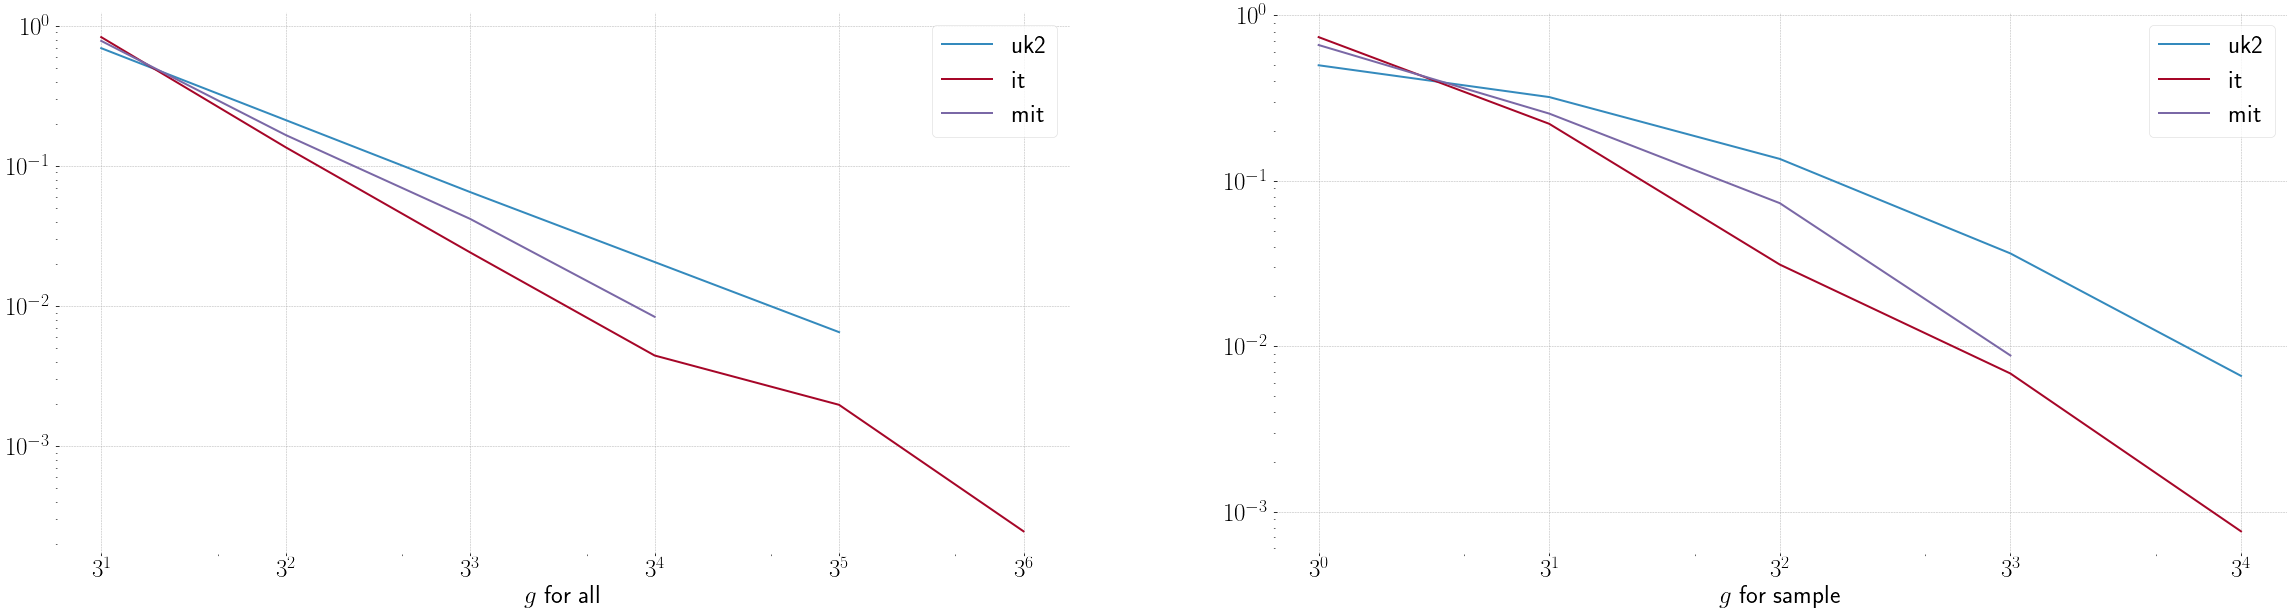

In [103]:
tmp = pd.DataFrame()
plt.figure(figsize=(20*2, 10*1))
p = 1
for s in ['all', 'sample']:
    plt.subplot(1,2,p)
    plt.xscale("log", base=3)
    plt.yscale("log")
    plt.xlabel(fr'$g$ for {s}')
    for c in ghist.keys():
        df = ghist[c][s]
        df2 = df[['pmf', 'label']]
        df2.columns = [f'p{dict({"all": "a", "sample": "s"})[s]}{c}', f'x{dict({"all": "a", "sample": "s"})[s]}{c}']
        tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
        plt.plot(df['label'], df['pmf'], label=c)
    plt.legend()
    p += 1
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S10.dat", index=False, header=True, sep="\t")

In [104]:
for c in gcount.keys():
    print(c, max(gcount[c]['all']), max(gcount[c]['sample']))

uk2 532 190
it 820 125
mit 243 48


In [105]:
3**6

729

## Fig 2 using Mann Kendall Estimation

In [106]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist2.keys():
    for ell in [1, 2]:
        thelist = bhist2[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2downb.dat", index=False, header=True, sep="\t")

In [107]:
cols = ['uk2m', 'itm', 'mitm', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,1,4,7]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 3]
b = tmp2.loc[tmp2.index >= 3]
a.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bmdownb.dat", index=True, header=True, sep="\t")
b.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bldownb.dat", index=True, header=True, sep="\t")

## Variations on fig4

In [108]:
callsUI = pd.DataFrame()
for c in ['uk2', 'it']:
    callsUI = callsUI.append(calls[c])
    
surv_cont = pc.get_survival2(callsUI, 30, 60, maxell=220, base=3)

In [109]:
len(callsUI) == len(calls['uk2']) + len(calls['it'])

True

In [110]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4ac.dat", header=False, index=False, sep="\t")

In [111]:
points_mit = pc.get_survival2(calls['mit'], 30, 60, maxell=220, binned=False)

tmp = pd.DataFrame()
for s in points_mit.keys():
    if s <= 3**3 + 1:
        df = points_mit[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4ap{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

In [112]:
callsMI = pd.DataFrame()
for c in ['mit', 'it']:
    callsMI = callsMI.append(calls[c])
    
surv_cont = pc.get_survival2(callsMI, 30, 60, maxell=220, base=3)

In [113]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4bc.dat", header=False, index=False, sep="\t")

In [114]:
points_uk = pc.get_survival2(calls['uk'], 30, 60, maxell=220, binned=False)

tmp = pd.DataFrame()
for s in points_uk.keys():
    if s <= 3**3 + 1:
        df = points_uk[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4bp{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

# Check for distribution of days between last contact and end of data

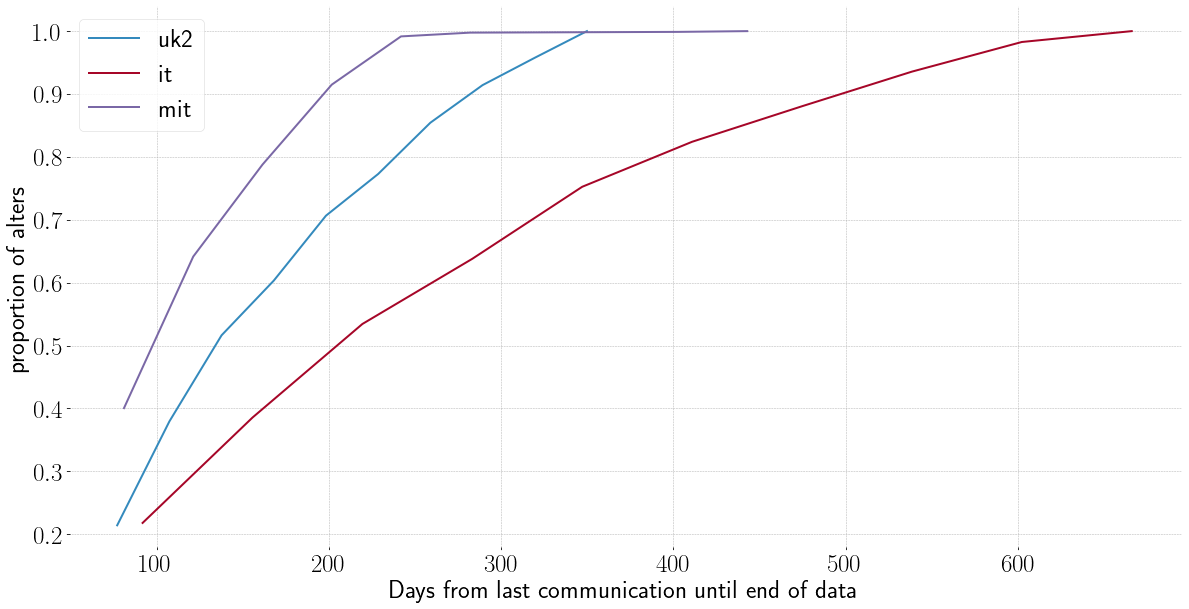

In [115]:
plt.xlabel("Days from last communication until end of data")
plt.ylabel("proportion of alters")
for c in ['uk2', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    last = df.groupby('ea')[['uclock']].max()
    last['days'] = max(unfiltered[c]['uclock']) - last['uclock']
    H = pc.histogram(last['days'], 10, log=False)
    y = H['pmf'].cumsum()
    plt.plot(H['label'], y, label=c)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/A.pdf", dpi=150)

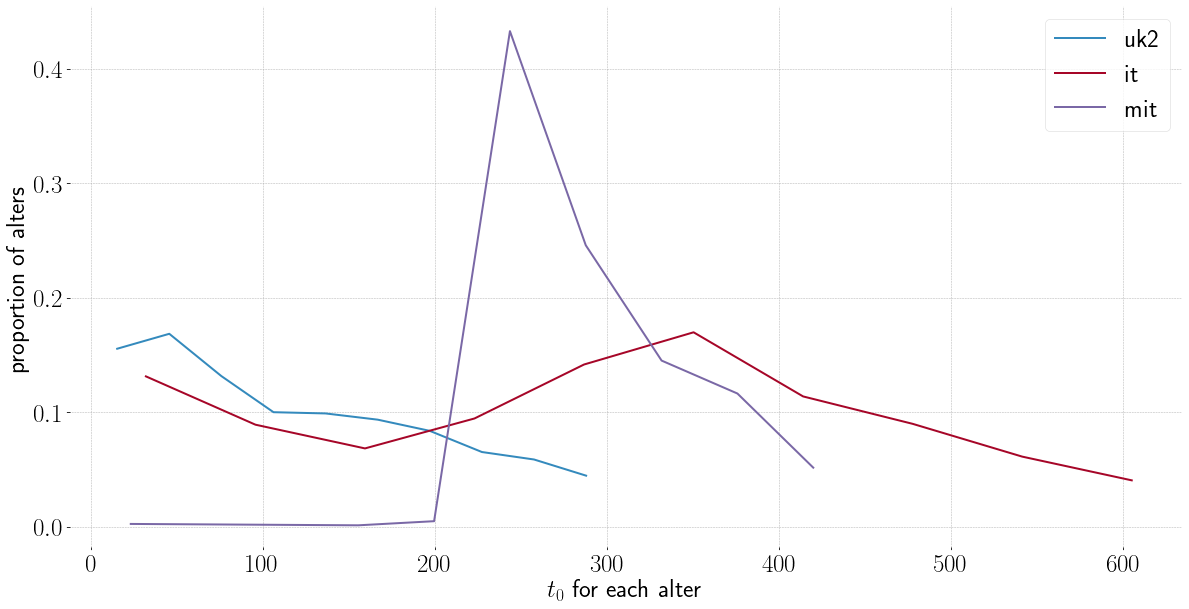

In [116]:
plt.xlabel(r"$t_0$ for each alter")
plt.ylabel("proportion of alters")
for c in ['uk2', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    last = df.groupby('ea')[['uclock']].min()
    H = pc.histogram(last['uclock'], 10, log=False)
    plt.plot(H['label'], H['pmf'], label=c)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/B.pdf", dpi=150)

In [117]:
vis3 = {}
for c in ['uk2', 'it', 'mit']:
    vis3[c] = []
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'lf'], df2.at[i, 'to'])
        vis3[c].append(tup)
    vis3[c].sort()

In [118]:
vis3['uk2'].index(vis3['uk2'][0])

0

In [119]:
for i in range(1, 7):
    print(i, (i - 1) % 2)

1 0
2 1
3 0
4 1
5 0
6 1


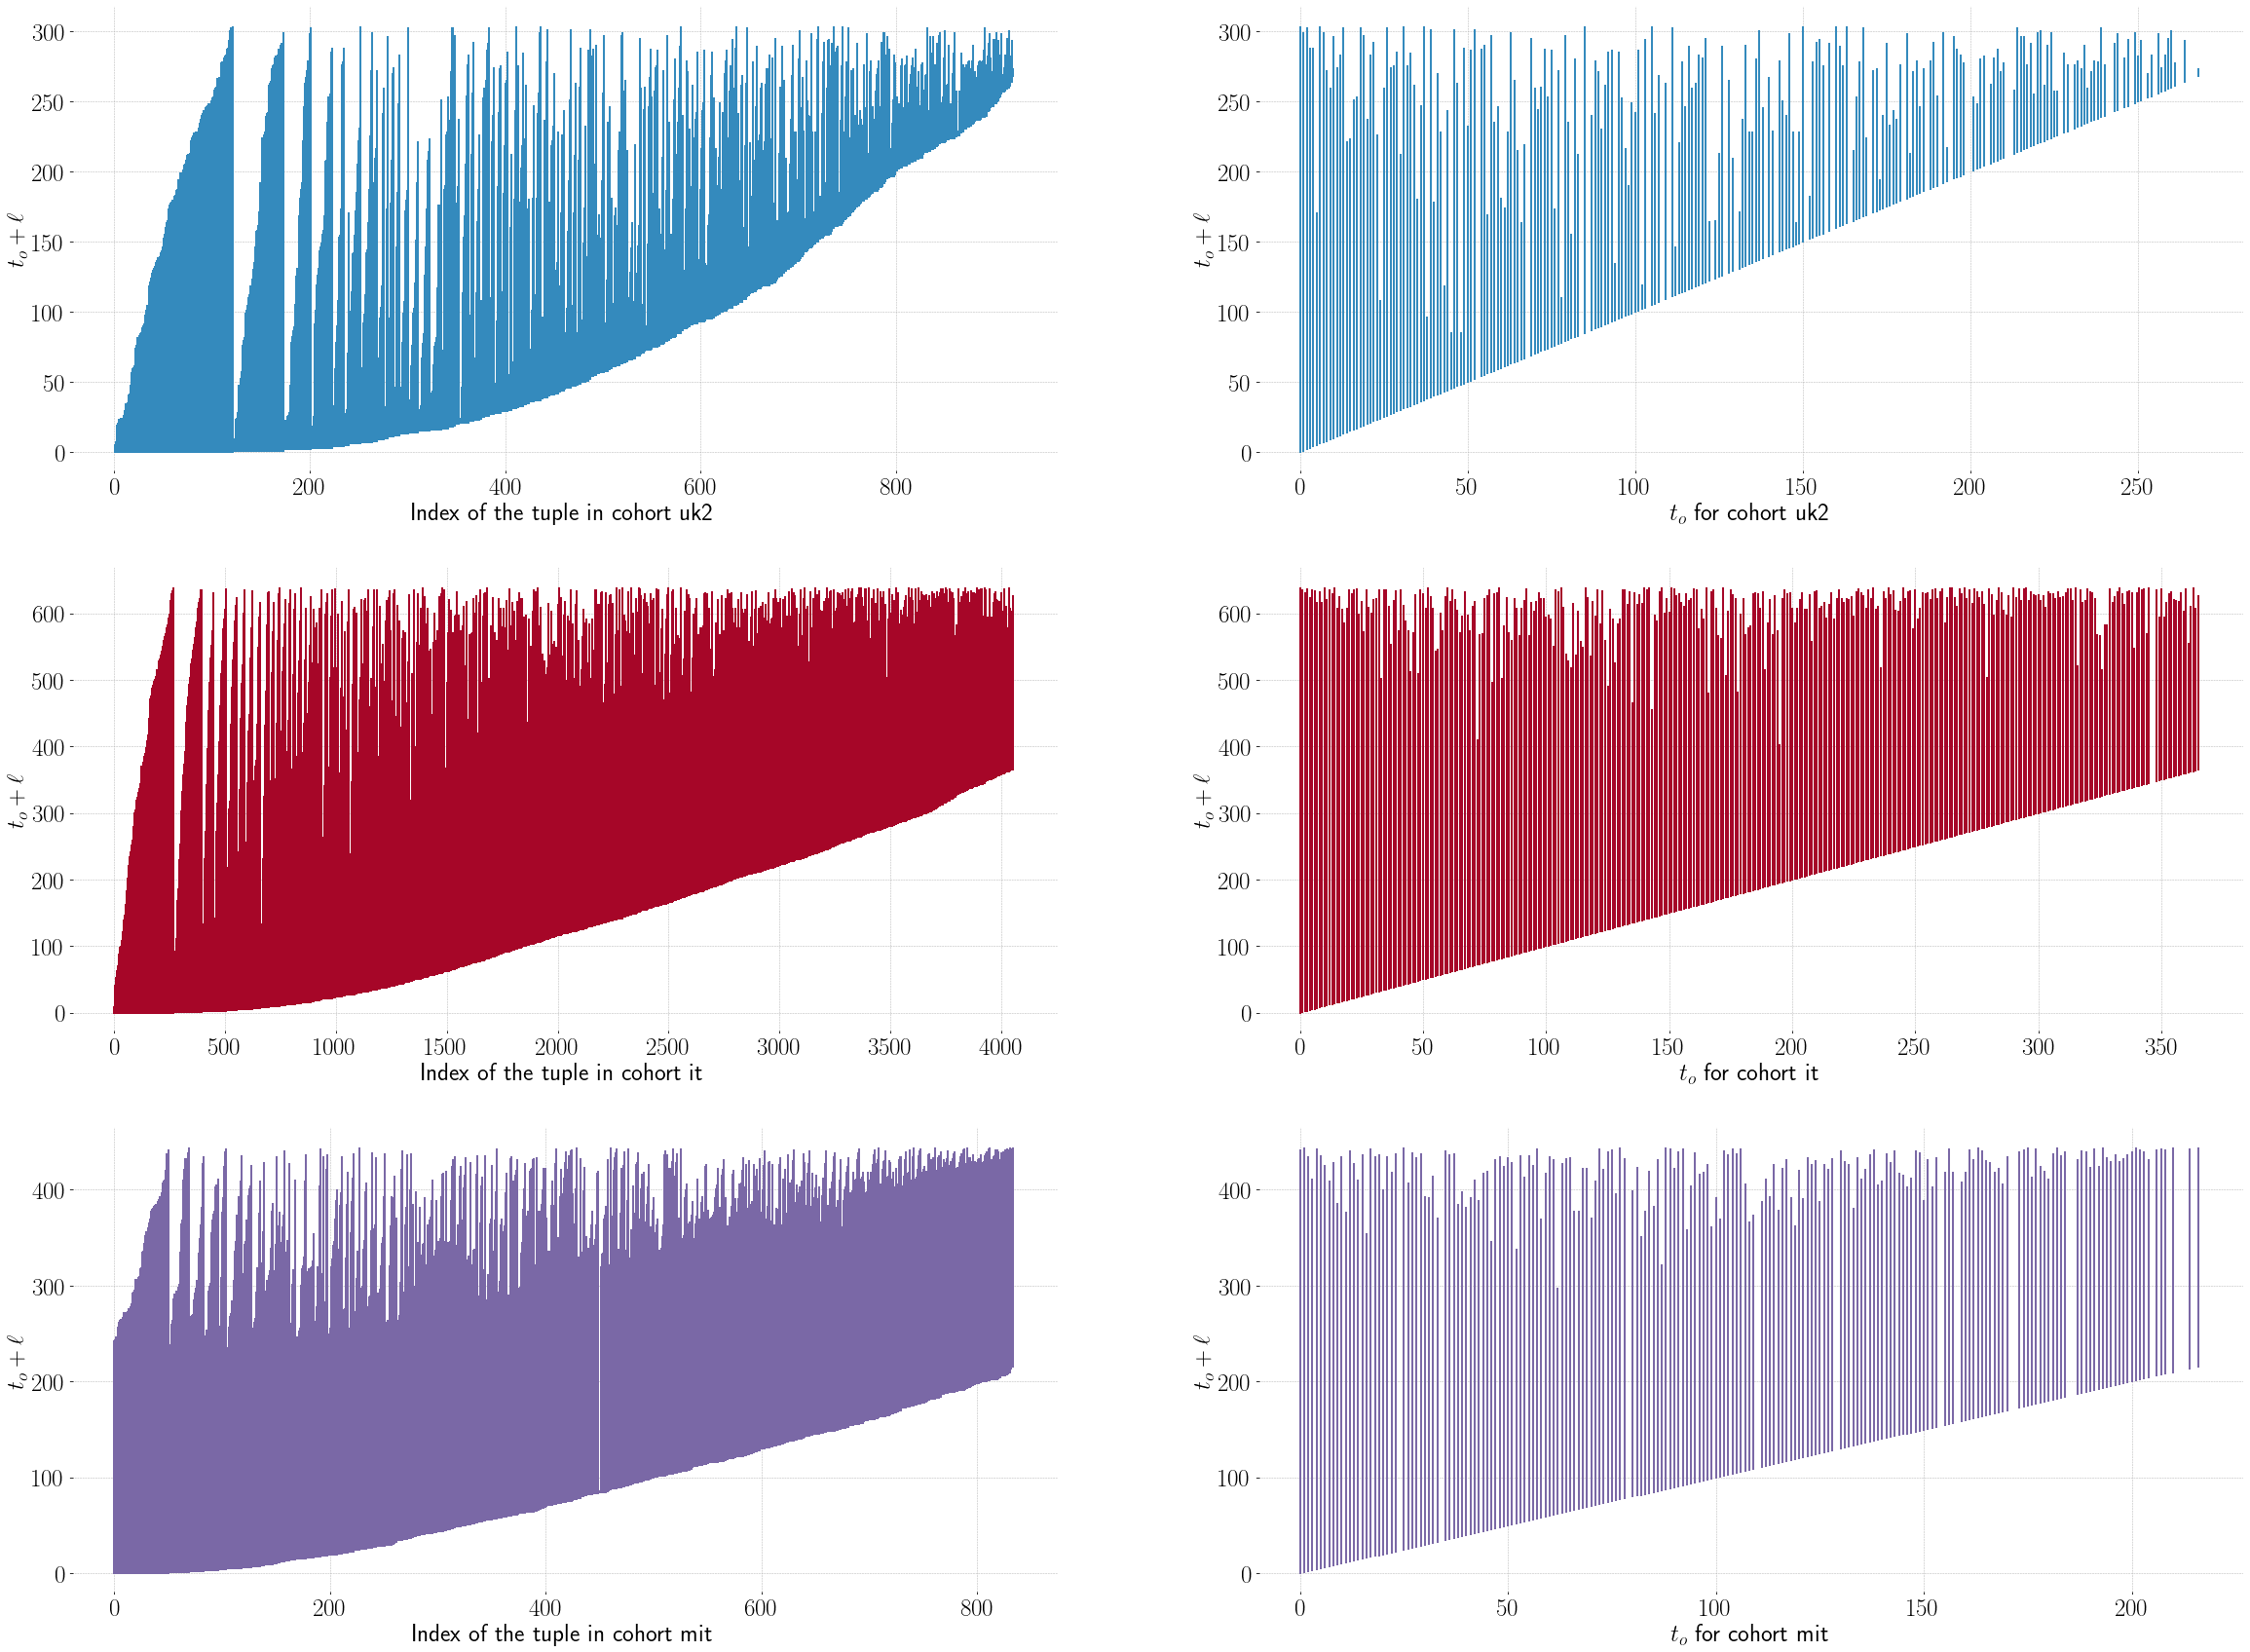

In [120]:
plt.figure(figsize=(20*2, 10*3))
p = 1
for c in ['uk2', 'uk2', 'it', 'it', 'mit', 'mit']:
    plt.subplot(3,2,p)
    if (p - 1) % 2 == 0:
        plt.xlabel(f"Index of the tuple in cohort {c}")
        plt.ylabel(r"$t_o + \ell$")
        for i in range(len(vis3[c])):
            x = [i, i]
            y = [vis3[c][i][0], vis3[c][i][0] + vis3[c][i][1]]
            if i == 0:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
            else:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    else:
        plt.xlabel(fr"$t_o$ for cohort {c}")
        plt.ylabel(r"$t_o + \ell$")
        for i in range(len(vis3[c])):
            x = [vis3[c][i][0], vis3[c][i][0]]
            y = [vis3[c][i][0], vis3[c][i][0] + vis3[c][i][1]]
            if i == 0:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
            else:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1
# plt.savefig("/home/vsvh/Desktop/C.pdf", dpi=300)

In [121]:
vis4 = {}
for c in ['uk2', 'it', 'mit']:
    vis4[c] = []
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis4[c].append(tup)
    vis4[c].sort()

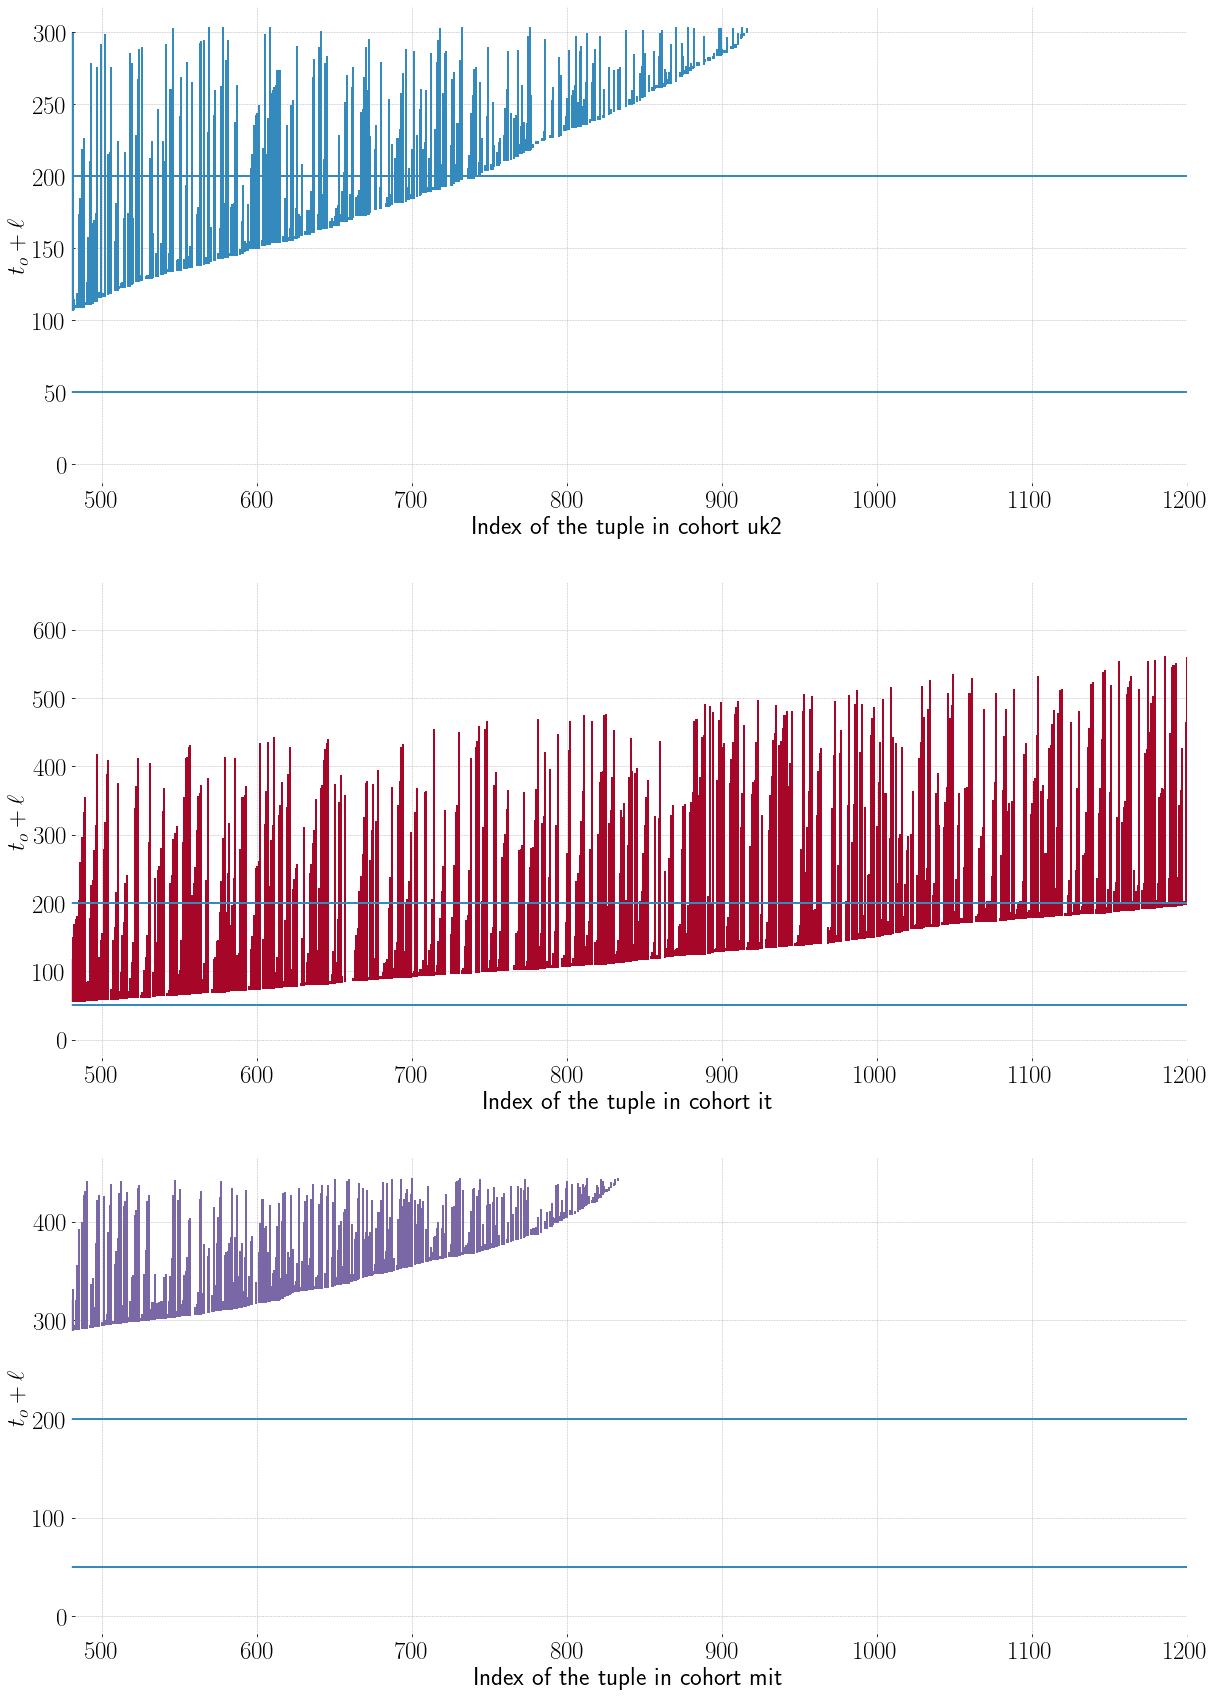

In [122]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis4.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Index of the tuple in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    plt.xlim(480, 1200)
    for i in range(len(vis4[c])):
        x = [i, i]
        y = [vis4[c][i][0], vis4[c][i][0] + vis4[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    plt.axhline(50)
    plt.axhline(200)
    p += 1
# plt.savefig("/home/vsvh/Desktop/D.pdf", dpi=300)

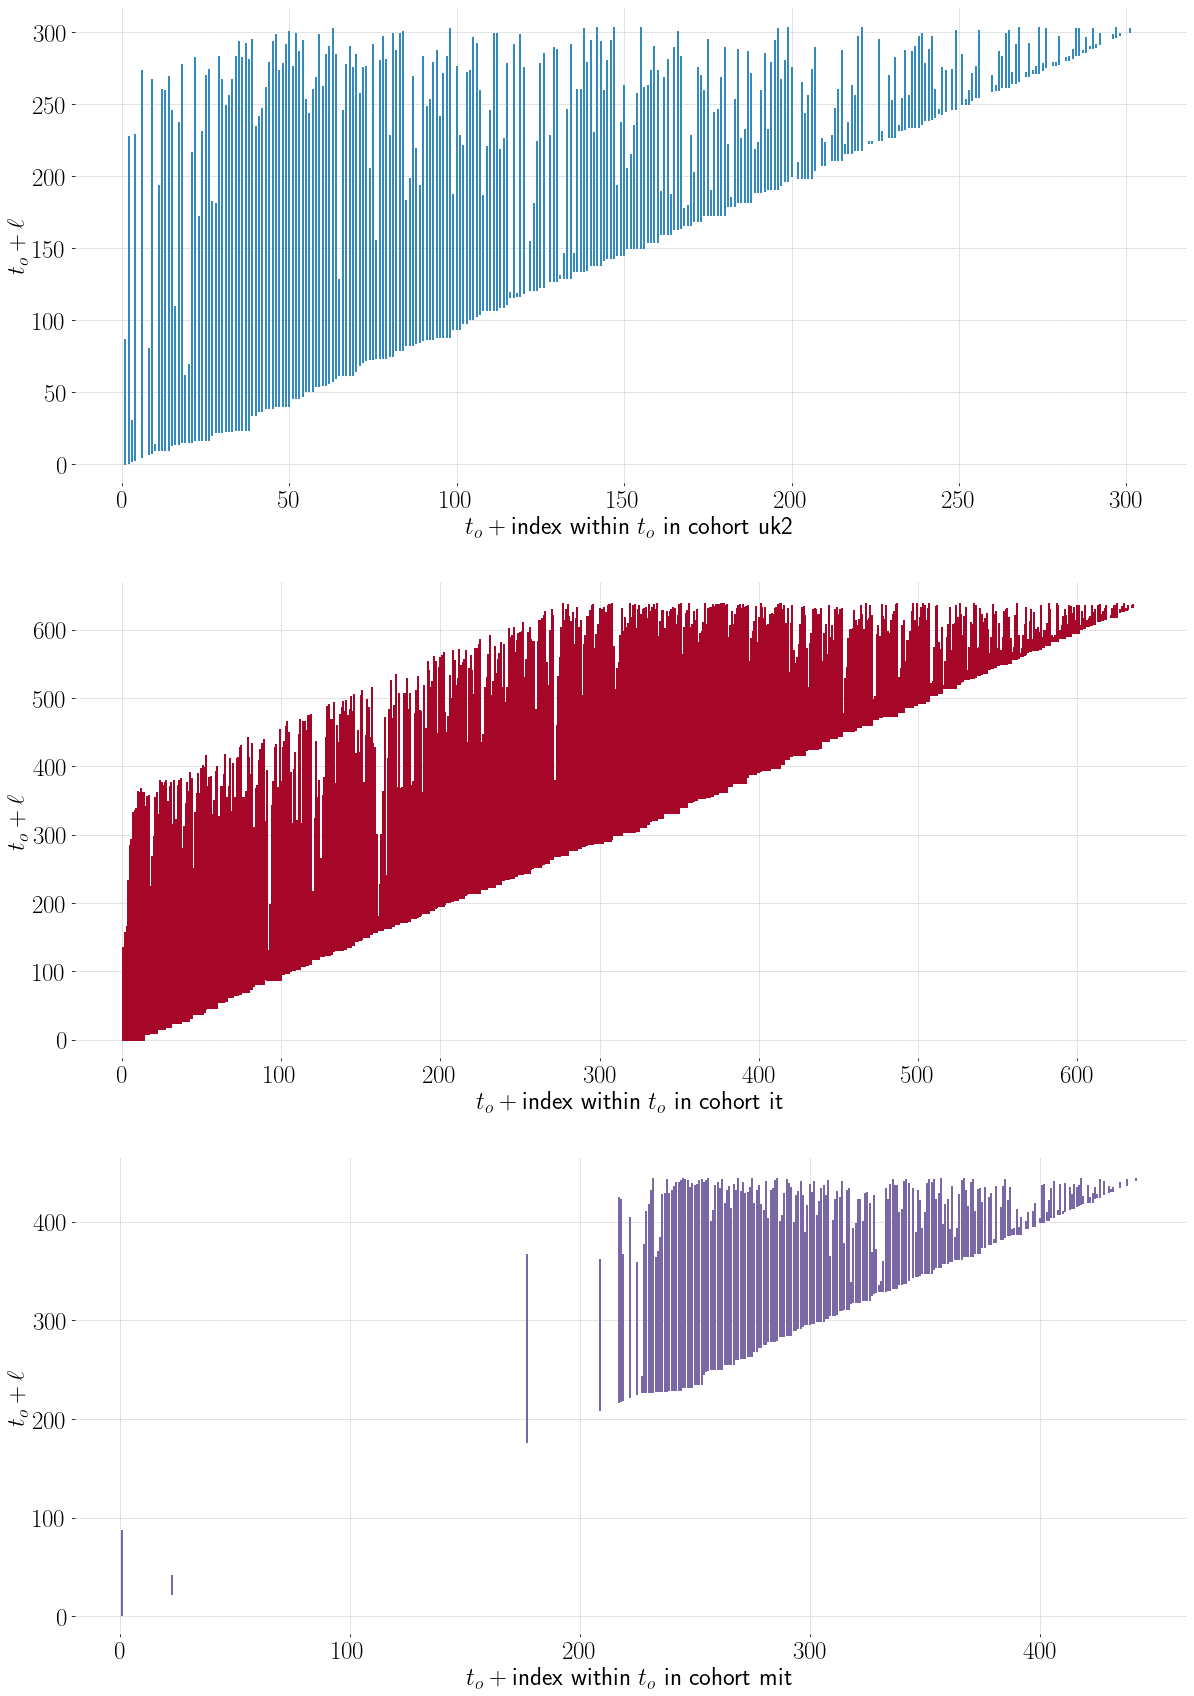

In [123]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis4.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr"$t_o + \text{{index within }} t_o$ in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    allto = []
    idx = 0
    for i in range(len(vis4[c])):
        if vis4[c][i][0] not in allto:
            allto.append(vis4[c][i][0])
            idx = 0
        x = [vis4[c][i][0] + idx, vis4[c][i][0] + idx]
        y = [vis4[c][i][0], vis4[c][i][0] + vis4[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
        idx += 1
    p += 1
# plt.savefig("/home/vsvh/Desktop/E.pdf", dpi=300)

In [124]:
def sort_check(l):
    x=l[0]
    dim=len(x)
    status=[]
    for s in range(dim):
        status.append(x[s])
    for elem in l:
        test=True
        for s in range(-1,-dim-1,-1):
            if elem[s]<status[s] and test:
                test=False
            if elem[s]>status[s] and (not test):
                test=True
        if (not test):
            print("Fail")
            return -1
        status=elem
        return 0

In [125]:
for s in range(-1, -2-1, -1):
    print(s)

-1
-2


In [126]:
for c in ['uk2', 'it', 'mit']:
    Y = [(vis4[c][i][0], vis4[c][i][0] + vis4[c][i][1]) for i in range(len(vis4[c]))]
    print(c, sort_check(Y))

uk2 0
it 0
mit 0


In [127]:
vis5 = {}
for c in ['uk2', 'it', 'mit']:
    # vis5[c] = []
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'ell'}, axis='columns')
    df2 = df2.sort_values(by=['to', 'ell'])
    df3 = pd.DataFrame()
    for t0 in df2['to'].unique():
        df4 = df2.loc[df2['to'] == t0]
        df4 = df4.sort_values(by='ell')
        df4['tmp'] = 1
        df4['tmp'] = df4['tmp'].cumsum()
        df4['tmp'] -= 1
        df4['toindex'] = df4['to'] + df4['tmp']
        df4['x'] = df4['toindex'].map(lambda i: (i, i))
        df4['idx'] = df4.index
        df4['y'] = df4['idx'].map(lambda idx: (df4.at[idx, 'to'], df4.at[idx, 'to'] + df4.at[idx, 'ell']))
        df3 = df3.append(df4)
    vis5[c] = df3

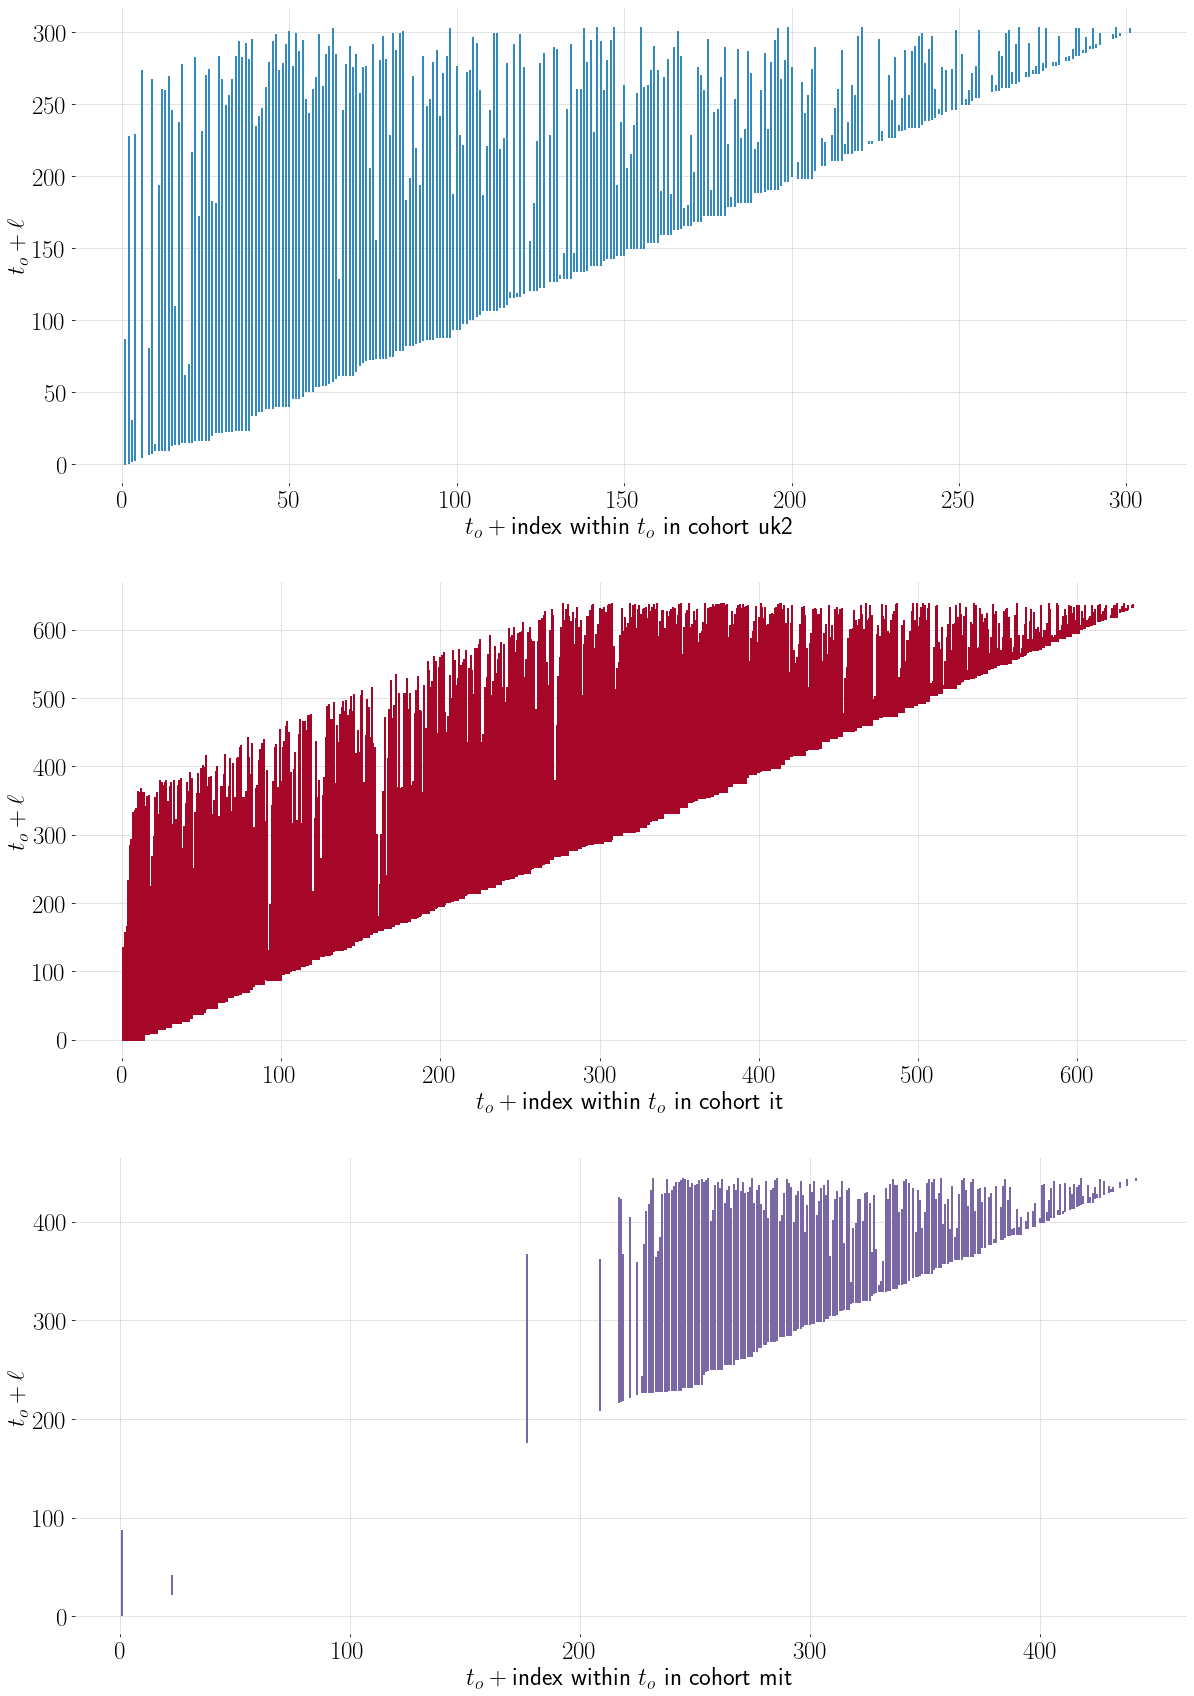

In [128]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis5.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr"$t_o + \text{{index within }} t_o$ in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    for i in vis5[c].index:
        x = vis5[c].at[i, 'x']
        y = vis5[c].at[i, 'y']
        if i == list(vis5[c].index)[0]:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1
# plt.savefig("/home/vsvh/Desktop/E.pdf", dpi=300)

In [129]:
vis5['it']

to  ell  tmp  toindex           x  \
ea                                                                            
(28, a6cf567cab75e3ed2dad4c0316ecf329)     0    0    0        0      (0, 0)   
(96, 91488939edc0279b7f3a0decedbe1de2)     0   16    1        1      (1, 1)   
(82, 34d1b61dffc641d516f1fb8a4df1d652)     0   70    2        2      (2, 2)   
(82, 8e763f155f7332ee6bfc61a1c2bcae4e)     0  134    3        3      (3, 3)   
(87, a5eb01ed9030ba628272d9bb25b9fe3a)     0  146    4        4      (4, 4)   
...                                      ...  ...  ...      ...         ...   
(194, 3d6bb9139ca548e3a9418e1e3bbd7a8a)  633    3    2      635  (635, 635)   
(197, 96bdfd123c813931c8a3a8666f1ba41a)  634    1    0      634  (634, 634)   
(196, b612b1ae827ab32dde274d1d256d7257)  635    0    0      635  (635, 635)   
(223, e1c4f6ae0756db1f0ce125d22e420298)  636    0    0      636  (636, 636)   
(236, 172340141bb562a36f5d7b562a7e614d)  637    0    0      637  (637, 637)   

                                                                             idx  \
ea                                                                                 
(28, a6cf567cab75e3ed2dad4c0316ecf329)    (28, a6cf567cab75e3ed2dad4c0316ecf329)   
(96, 91488939edc0279b7f3a0decedbe1de2)    (96, 91488939edc0279b7f3a0decedbe1de2)   
(82, 34d1b61dffc641d516f1fb8a4df1d652)    (82, 34d1b61dffc641d516f1fb8a4df1d652)   
(82, 8e763f155f7332ee6bfc61a1c2bcae4e)    (82, 8e763f155f7332ee6bfc61a1c2bcae4e)   
(87, a5eb01ed9030ba628272d9bb25b9fe3a)    (87, a5eb01ed9030ba628272d9bb25b9fe3a)   
...                                                                          ...   
(194, 3d6bb9139ca548e3a9418e1e3bbd7a8a)  (194, 3d6bb9139ca548e3a9418e1e3bbd7a8a)   
(197, 96bdfd123c813931c8a3a8666f1ba41a)  (197, 96bdfd123c813931c8a3a8666f1ba41a)   
(196, b612b1ae827ab32dde274d1d256d7257)  (196, b612b1ae827ab32dde274d1d256d7257)   
(223, e1c4f6ae0756db1f0ce125d22e420298)  (223, e1c4f6ae0756db1f0ce125d22e420298)   
(236, 172340141bb562a36f5d7b562a7e614d)  (236, 172340141bb562a36f5d7b562a7e614d)   

                                                  y  
ea                                                   
(28, a6cf567cab75e3ed2dad4c0316ecf329)       (0, 0)  
(96, 91488939edc0279b7f3a0decedbe1de2)      (0, 16)  
(82, 34d1b61dffc641d516f1fb8a4df1d652)      (0, 70)  
(82, 8e763f155f7332ee6bfc61a1c2bcae4e)     (0, 134)  
(87, a5eb01ed9030ba628272d9bb25b9fe3a)     (0, 146)  
...                                             ...  
(194, 3d6bb9139ca548e3a9418e1e3bbd7a8a)  (633, 636)  
(197, 96bdfd123c813931c8a3a8666f1ba41a)  (634, 635)  
(196, b612b1ae827ab32dde274d1d256d7257)  (635, 635)  
(223, e1c4f6ae0756db1f0ce125d22e420298)  (636, 636)  
(236, 172340141bb562a36f5d7b562a7e614d)  (637, 637)  

[4052 rows x 7 columns]

In [130]:
df3 = df3.append(df4)
df3

to  ell  tmp  toindex  \
ea                                                                           
(sp10-01-13, b802df1b89a5739fea33e74a6aa7209e3e...    1   85    0        1   
(sp10-01-13, 8cc41910cabd25b001e5ba28a41fd7072c...   23   18    0       23   
(sp10-01-13, e9cb8509fe4b245cfa440f21b59aa5f3ff...  177  189    0      177   
(sp10-01-33, 75c1d1360b3cad258544defdda1048d84b...  209  152    0      209   
(fa10-01-26, 9bbb01b25d296786be353956df4836e907...  217  207    0      217   
...                                                 ...  ...  ...      ...   
(fa10-01-63, d196fd5a2e794dc59fc6366661c6d0bbcd...  437    1    1      438   
(fa10-01-37, a0b7bdc2c1030d1dbad808f230bd84fc7c...  438    4    0      438   
(sp10-01-32, da4b9237bacccdf19c0760cab7aec4a835...  441    0    0      441   
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  442    1    0      442   
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  442    1    0      442   

                                                             x  \
ea                                                               
(sp10-01-13, b802df1b89a5739fea33e74a6aa7209e3e...      (1, 1)   
(sp10-01-13, 8cc41910cabd25b001e5ba28a41fd7072c...    (23, 23)   
(sp10-01-13, e9cb8509fe4b245cfa440f21b59aa5f3ff...  (177, 177)   
(sp10-01-33, 75c1d1360b3cad258544defdda1048d84b...  (209, 209)   
(fa10-01-26, 9bbb01b25d296786be353956df4836e907...  (217, 217)   
...                                                        ...   
(fa10-01-63, d196fd5a2e794dc59fc6366661c6d0bbcd...  (438, 438)   
(fa10-01-37, a0b7bdc2c1030d1dbad808f230bd84fc7c...  (438, 438)   
(sp10-01-32, da4b9237bacccdf19c0760cab7aec4a835...  (441, 441)   
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  (442, 442)   
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  (442, 442)   

                                                                                                  idx  \
ea                                                                                                      
(sp10-01-13, b802df1b89a5739fea33e74a6aa7209e3e...  (sp10-01-13, b802df1b89a5739fea33e74a6aa7209e3...   
(sp10-01-13, 8cc41910cabd25b001e5ba28a41fd7072c...  (sp10-01-13, 8cc41910cabd25b001e5ba28a41fd7072...   
(sp10-01-13, e9cb8509fe4b245cfa440f21b59aa5f3ff...  (sp10-01-13, e9cb8509fe4b245cfa440f21b59aa5f3f...   
(sp10-01-33, 75c1d1360b3cad258544defdda1048d84b...  (sp10-01-33, 75c1d1360b3cad258544defdda1048d84...   
(fa10-01-26, 9bbb01b25d296786be353956df4836e907...  (fa10-01-26, 9bbb01b25d296786be353956df4836e90...   
...                                                                                               ...   
(fa10-01-63, d196fd5a2e794dc59fc6366661c6d0bbcd...  (fa10-01-63, d196fd5a2e794dc59fc6366661c6d0bbc...   
(fa10-01-37, a0b7bdc2c1030d1dbad808f230bd84fc7c...  (fa10-01-37, a0b7bdc2c1030d1dbad808f230bd84fc7...   
(sp10-01-32, da4b9237bacccdf19c0760cab7aec4a835...  (sp10-01-32, da4b9237bacccdf19c0760cab7aec4a83...   
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  (fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba55...   
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  (fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba55...   

                                                             y  
ea                                                              
(sp10-01-13, b802df1b89a5739fea33e74a6aa7209e3e...     (1, 86)  
(sp10-01-13, 8cc41910cabd25b001e5ba28a41fd7072c...    (23, 41)  
(sp10-01-13, e9cb8509fe4b245cfa440f21b59aa5f3ff...  (177, 366)  
(sp10-01-33, 75c1d1360b3cad258544defdda1048d84b...  (209, 361)  
(fa10-01-26, 9bbb01b25d296786be353956df4836e907...  (217, 424)  
...                                                        ...  
(fa10-01-63, d196fd5a2e794dc59fc6366661c6d0bbcd...  (437, 438)  
(fa10-01-37, a0b7bdc2c1030d1dbad808f230bd84fc7c...  (438, 442)  
(sp10-01-32, da4b9237bacccdf19c0760cab7aec4a835...  (441, 441)  
(fa10-01-05, c4dd1c8a9e39de0fa14a5e7612034ba559...  (442, 443)  
(fa10-01-05, c4dd1c8a9e39de0fa14a

## No filters

In [131]:
vis6 = {}
for c in ['uk2', 'it', 'mit']:
    vis6[c] = []
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis6[c].append(tup)
    vis6[c].sort()

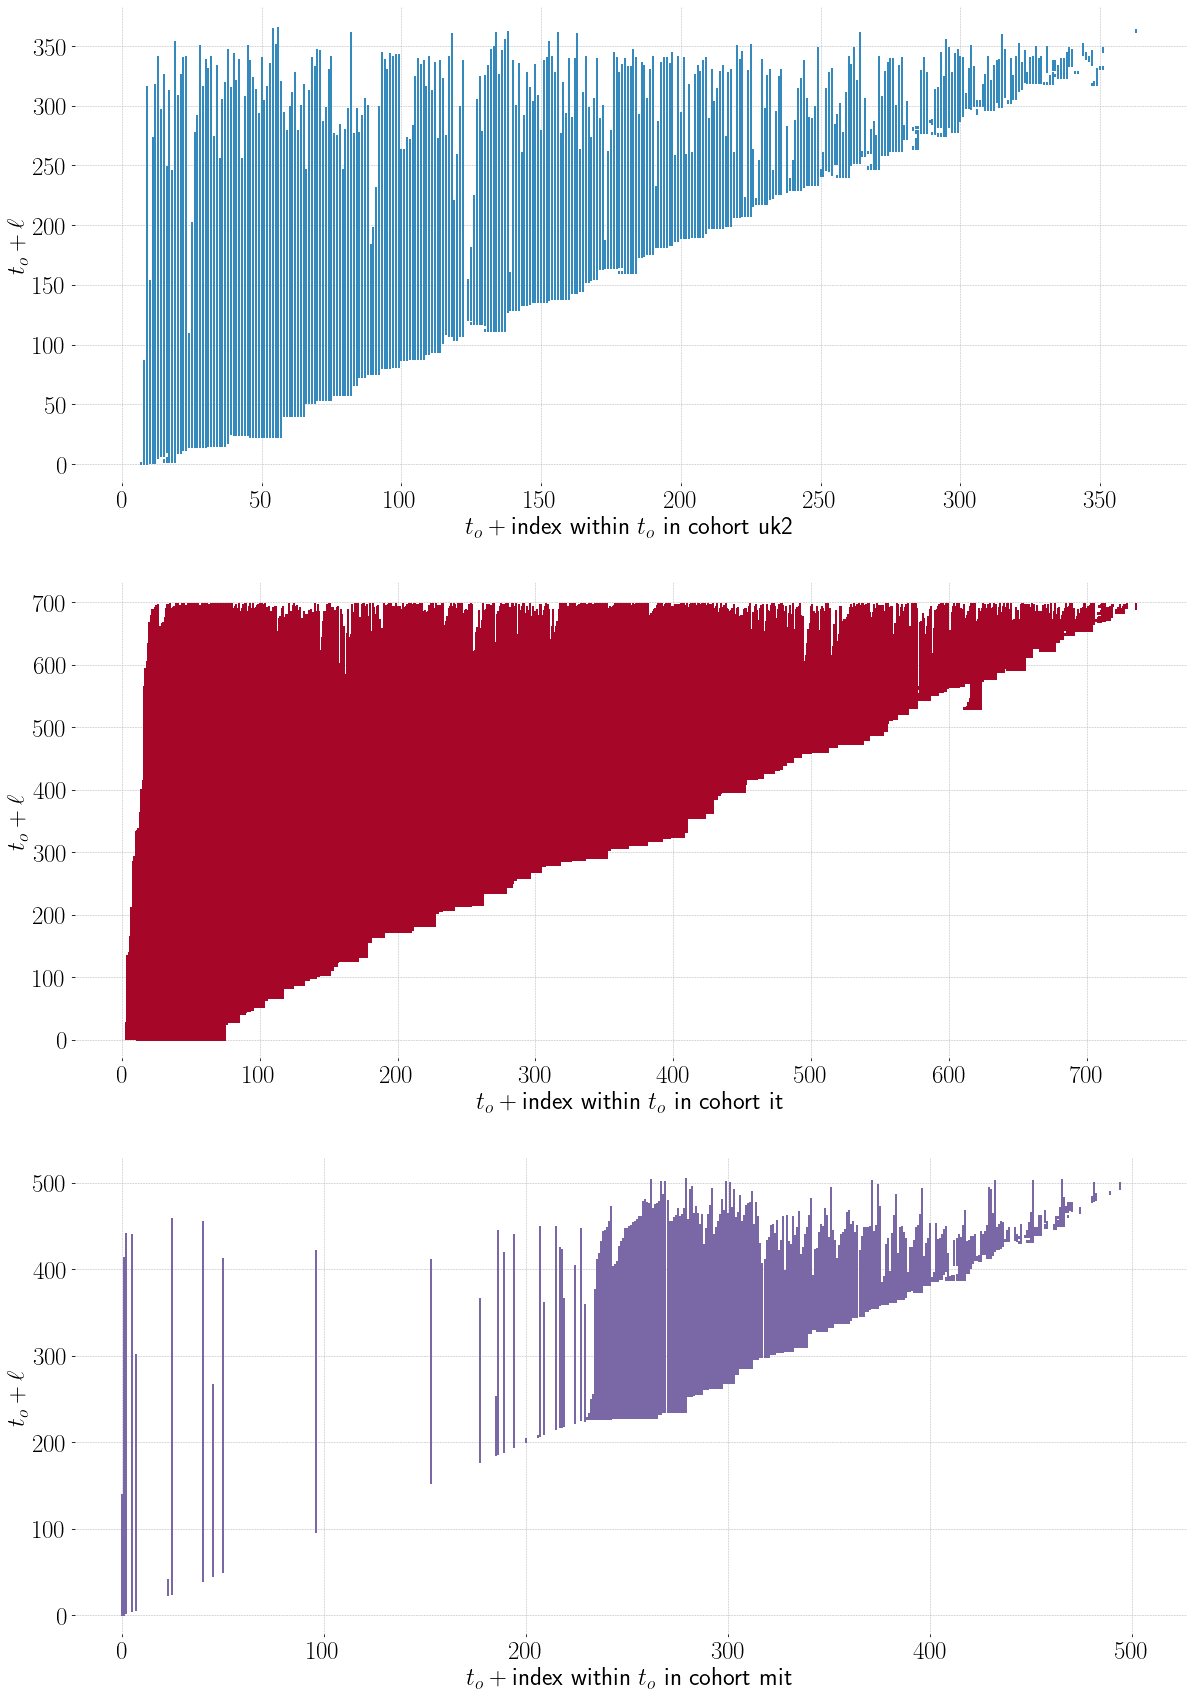

In [132]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis6.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr"$t_o + \text{{index within }} t_o$ in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    allto = []
    idx = 0
    for i in range(len(vis6[c])):
        if vis6[c][i][0] not in allto:
            allto.append(vis6[c][i][0])
            idx = 0
        x = [vis6[c][i][0] + idx, vis6[c][i][0] + idx]
        y = [vis6[c][i][0], vis6[c][i][0] + vis6[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
        idx += 1
    p += 1

In [133]:
vis7 = {}
for c in ['uk2', 'it', 'mit']:
    vis7[c] = []
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis7[c].append(tup)
    vis7[c].sort()

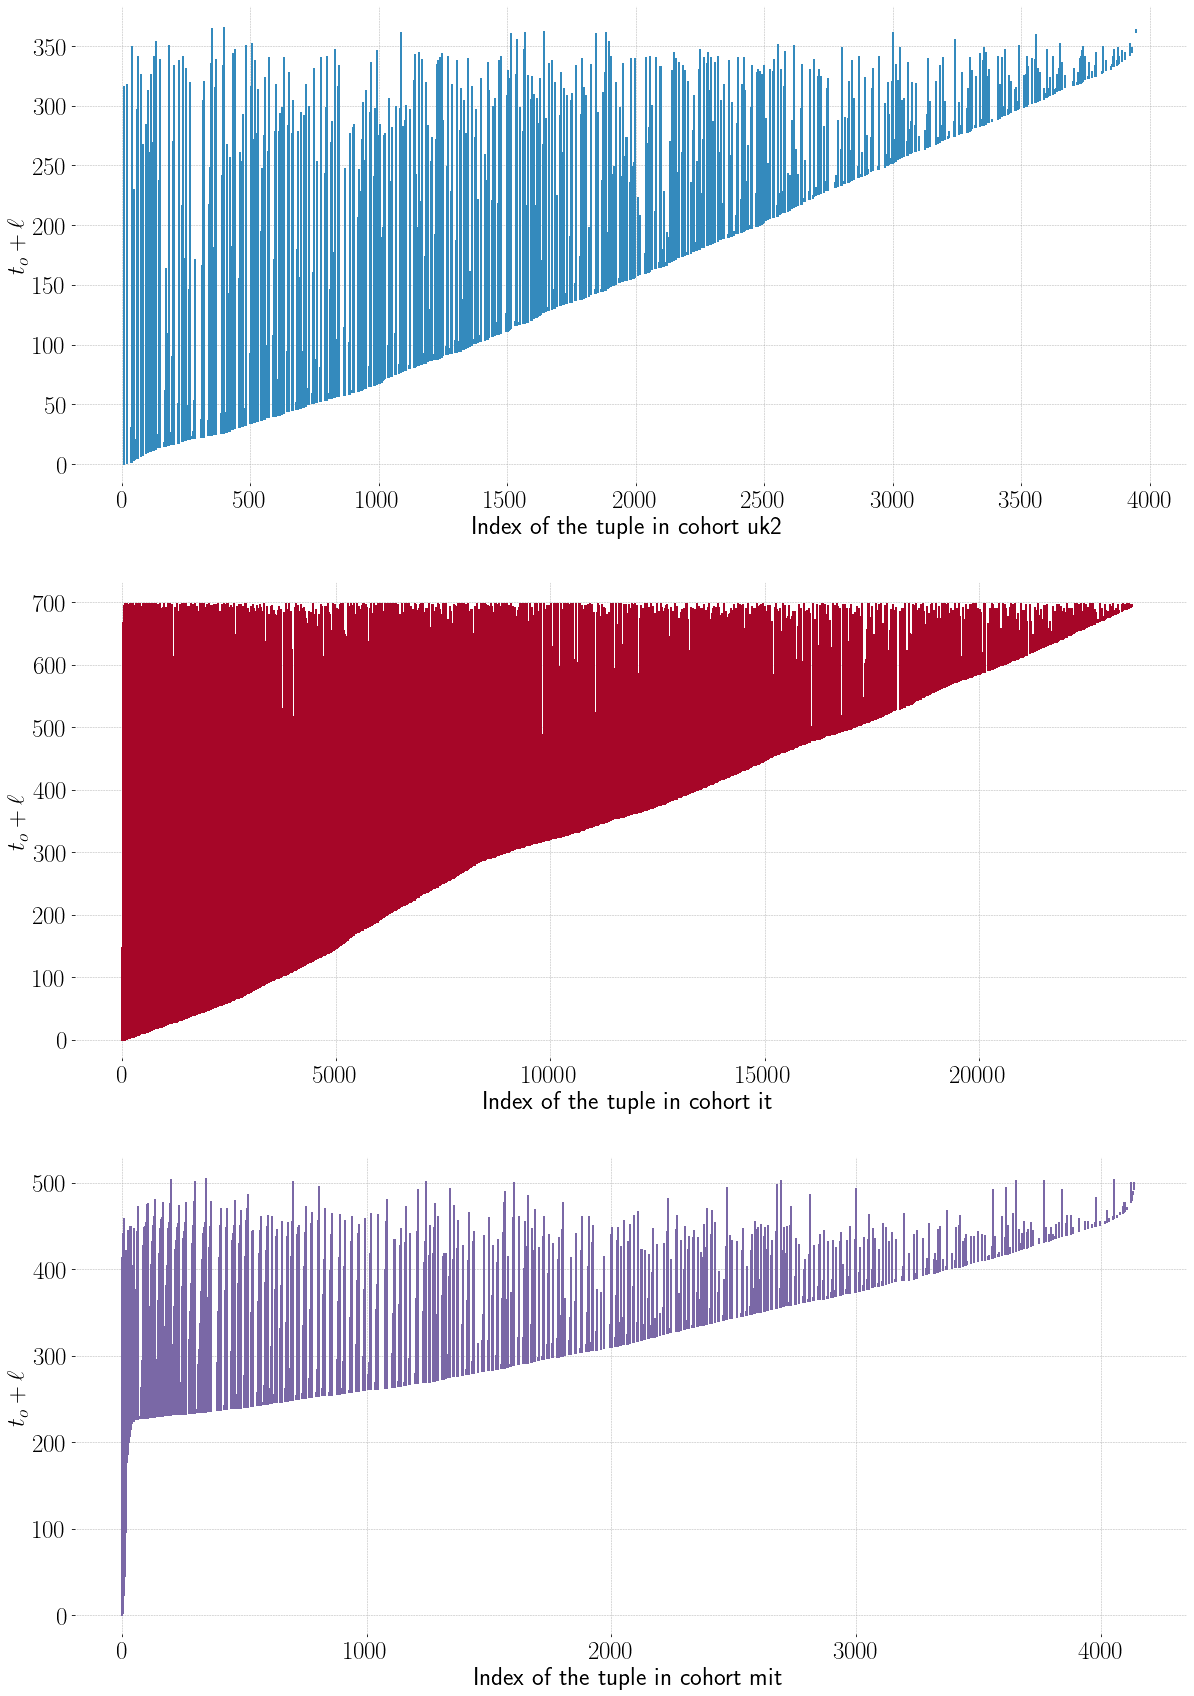

In [134]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis7.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Index of the tuple in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    for i in range(len(vis7[c])):
        x = [i, i]
        y = [vis7[c][i][0], vis7[c][i][0] + vis7[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1
# plt.savefig("/home/vsvh/Desktop/Dnofilters.pdf", dpi=300)

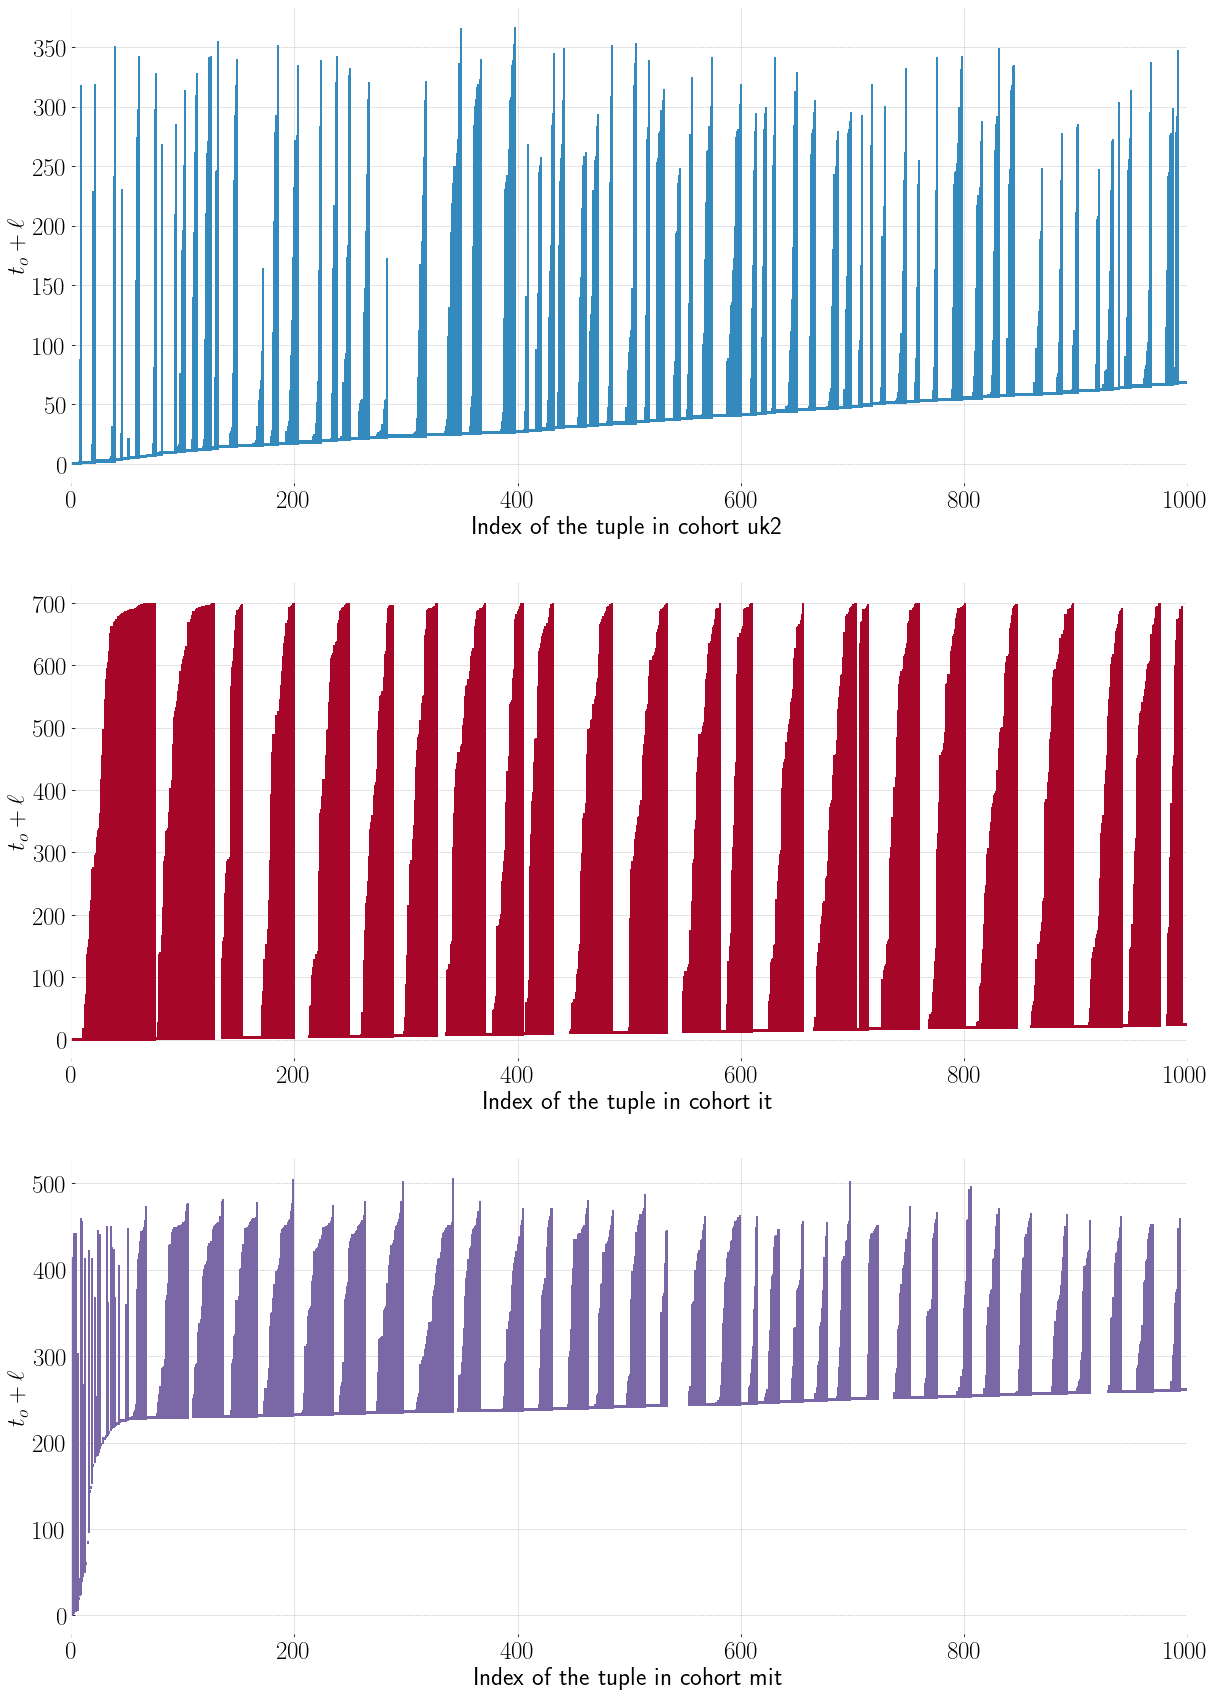

In [135]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis7.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Index of the tuple in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    plt.xlim(0,1000)
    # plt.ylim(0,100)
    for i in range(len(vis7[c])):
        x = [i, i]
        y = [vis7[c][i][0], vis7[c][i][0] + vis7[c][i][1] + 1]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1

In [136]:
vis7 = {}
for c in ['uk2', 'it', 'mit']:
    vis7[c] = []
    df = unfiltered[c].copy(deep=True)
    
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis7[c].append(tup)
    vis7[c].sort()

## only Italy

and $50 \leq t_o \leq 200$

In [137]:
fwL = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 60)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)

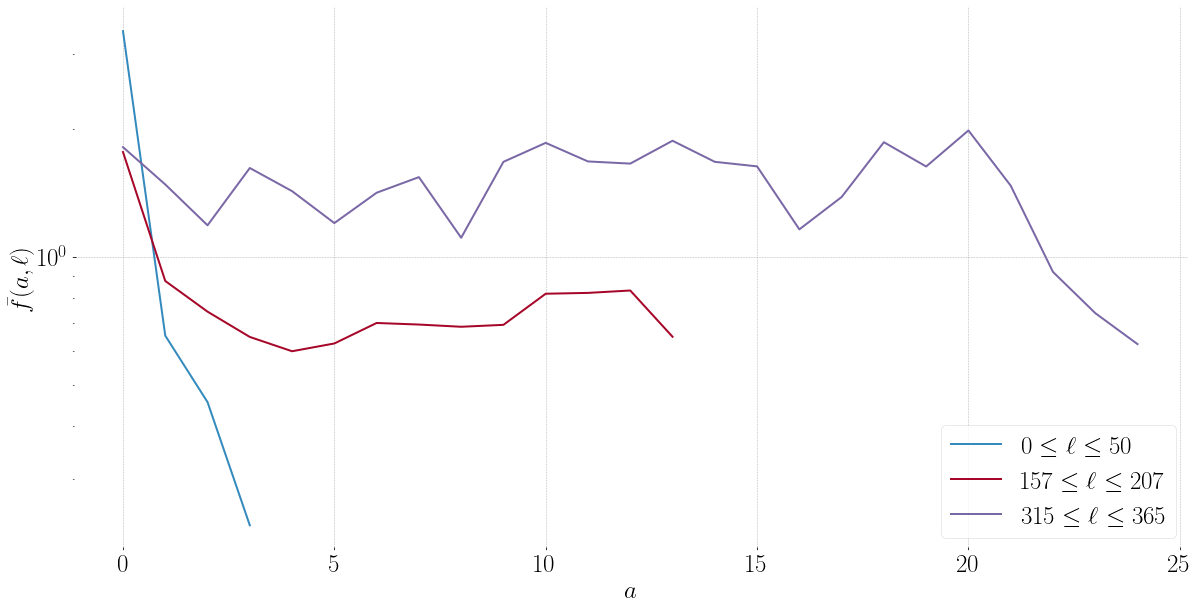

In [138]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot(fwL[i]['f'].index, fwL[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

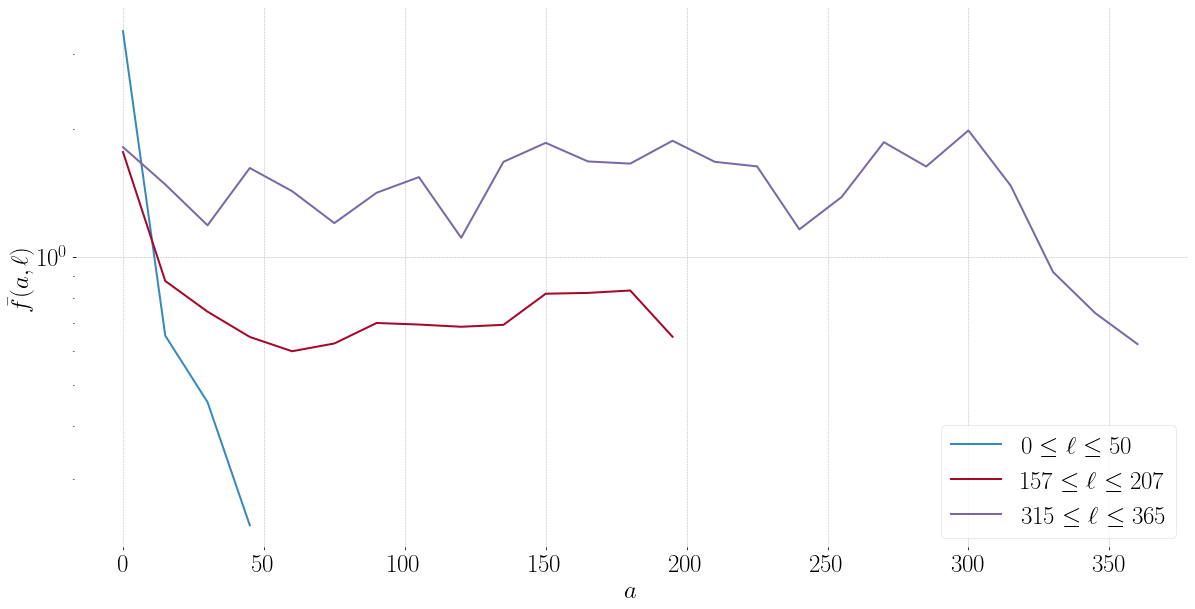

In [139]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL[i]['f'].index], fwL[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [140]:
pc.get_b_slopes(fwL[1]['f'])

[[2, 11], [0.7027427282727337, 0.7027427282727337]]

In [141]:
fwL2 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 0) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL2[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)

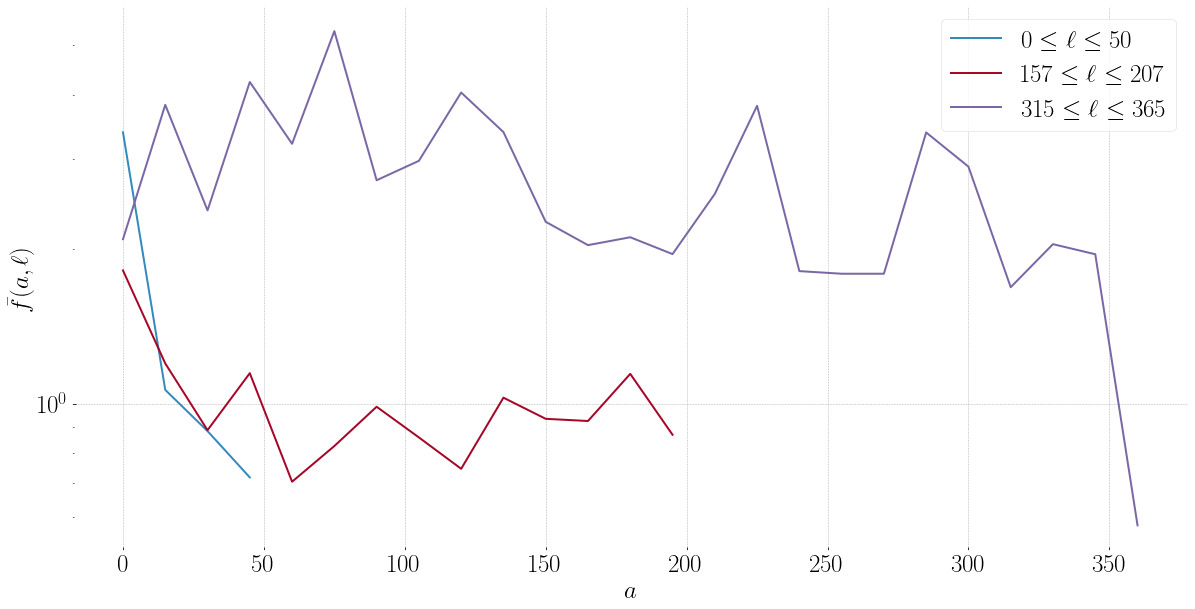

In [142]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL2[i]['f'].index], fwL2[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [143]:
fwL3 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 20) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL3[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)

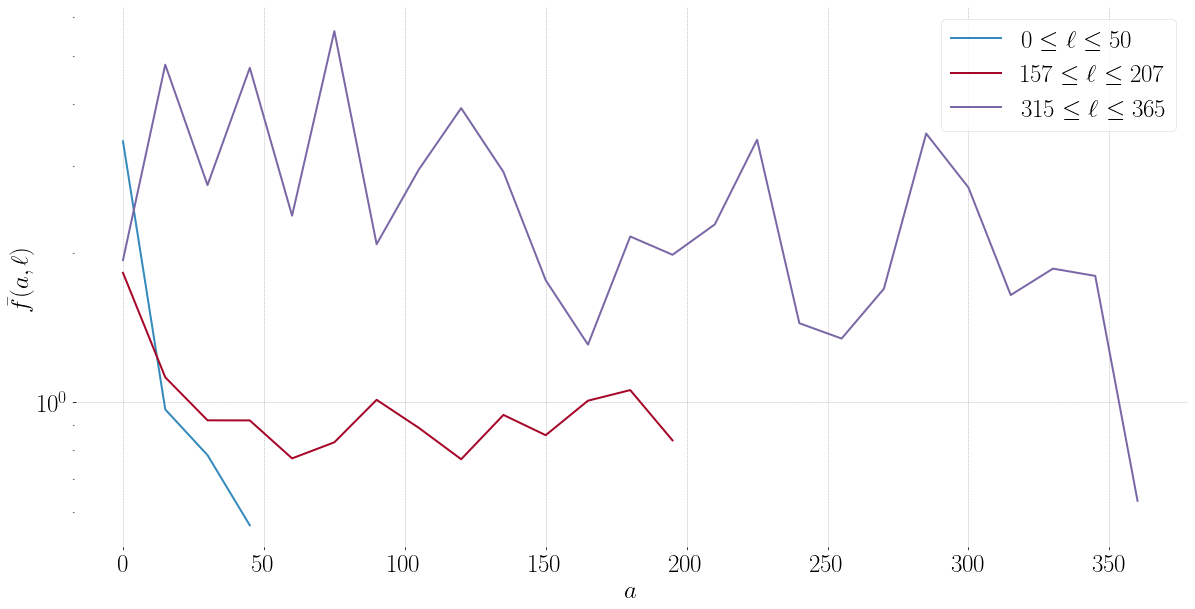

In [144]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL3[i]['f'].index], fwL3[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

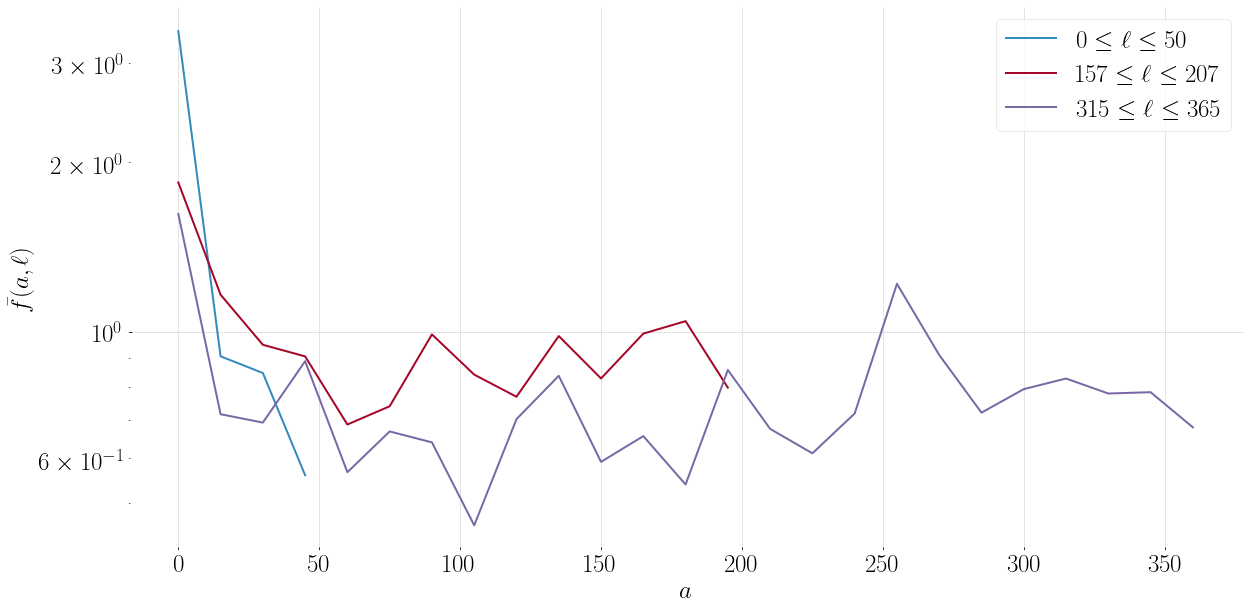

In [145]:
fwL4 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 30) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL4[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)
    
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL4[i]['f'].index], fwL4[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

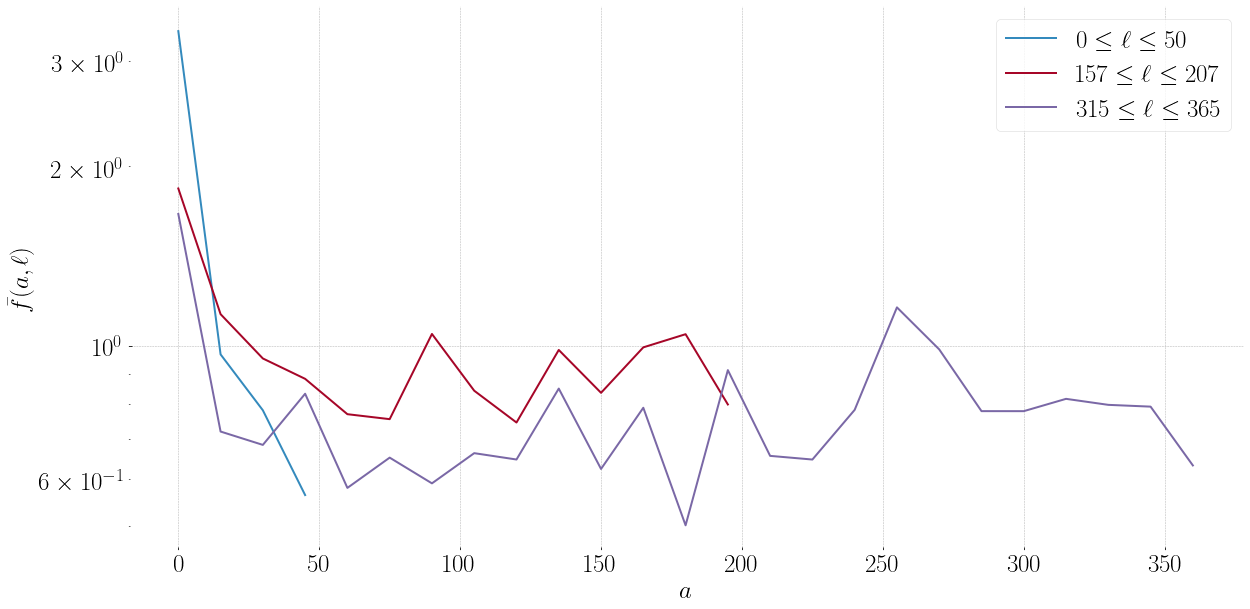

In [146]:
fwL5 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 21) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL5[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)
    
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL5[i]['f'].index], fwL5[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [147]:
min(unfiltered['it2']['time']) - min(unfiltered['it1']['time'])

Timedelta('333 days 16:02:01')

In [148]:
egos = unfiltered['it'].groupby('ego')[['uclock']].min()

In [149]:
e1 = egos.loc[egos['uclock'] <= 50]
len(e1) / len(egos)

0.4930555555555556

In [150]:
e2 = egos.loc[(egos['uclock'] > 200) & (egos['uclock'] <= 300)]
len(e2) / len(egos)

0.2152777777777778

## Italian new sample
To make sure we use the most accurate definition of $a$ and $\ell$

In [334]:
# No Filter
df = unfiltered['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
print(len(df['ea'].unique()))
# L
lf = df.groupby('ea')[['aclock']].max()
keep = lf.loc[lf['aclock'] <= 365]
df = df[df['ea'].isin(keep.index)]
print(len(df['ea'].unique()))
# Delta t to the left (by ego)
t0i = df.groupby('ego')['uclock'].min()
t0x = df.groupby('ea')[['uclock']].min()
t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
keep = t0x.loc[t0x['dif'] > 33]
df = df[df['ea'].isin(keep.index)]
print(len(df['ea'].unique()))
# # Delta t to the right (by ego)
# T0i = df.groupby('ego')['uclock'].max()
# T = max(df['uclock'])
# keep = []
# for ea in df['ea'].unique():
#     tmp = df.loc[df['ea'] == ea]
#     tmp = tmp.loc[tmp['uclock'] >= T0i[ea[0]] - 60]
#     if len(tmp) == 0:
#         keep.append(ea)
# df = df[df['ea'].isin(keep)]
# print(len(df['ea'].unique()))
# ncalls = df.groupby('ea')[['time']].count()
# keep = ncalls.loc[ncalls['time'] >= 3]
# df = df[df['ea'].isin(keep.index)]
# print(len(df['ea'].unique()))
# Delta t to the right
df = pc.apply_filters(df, 60)
df['ea'] = list(zip(df['ego'], df['alter']))
print(len(df['ea'].unique()))

23674
21064
18513
3083


In [190]:
a = calls['it'].copy(deep=True)
a['ea'] = list(zip(a['ego'], a['alter']))
print(len(a['ea'].unique()))

4052


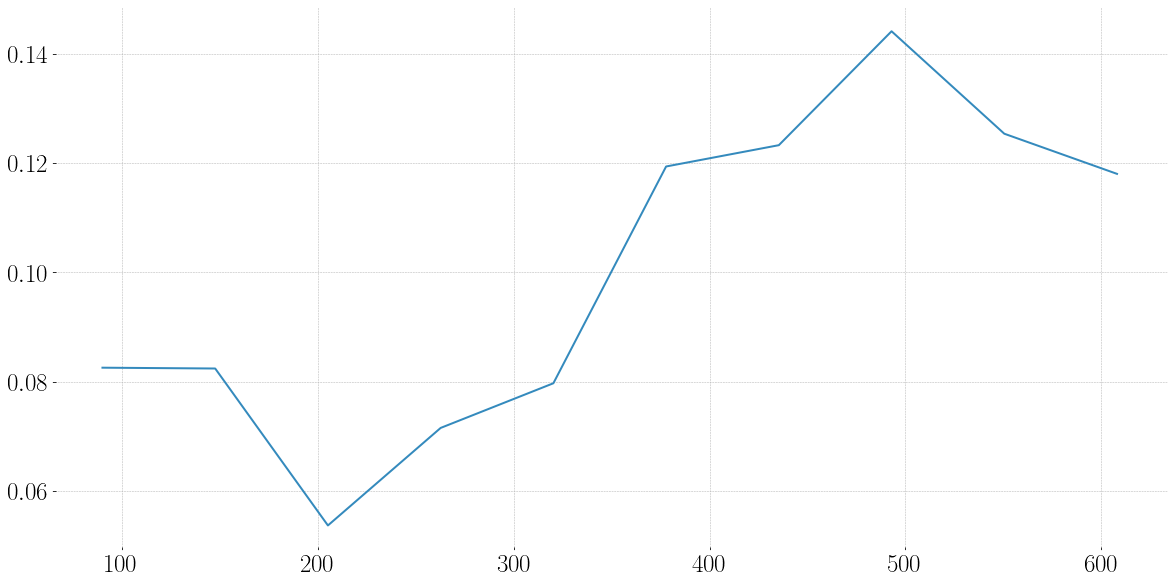

In [179]:
last = df.groupby('ea')[['uclock']].min()
H = pc.histogram(last['uclock'], 10, log=False)
plt.plot(H['label'], H['pmf'], label=c)

In [183]:
max(last['uclock'])

637

In [181]:
max(unfiltered['it']['uclock'])

698

In [184]:
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [258]:
# limits['it'] = [(0, 50), (170, 220), (280, 330)]

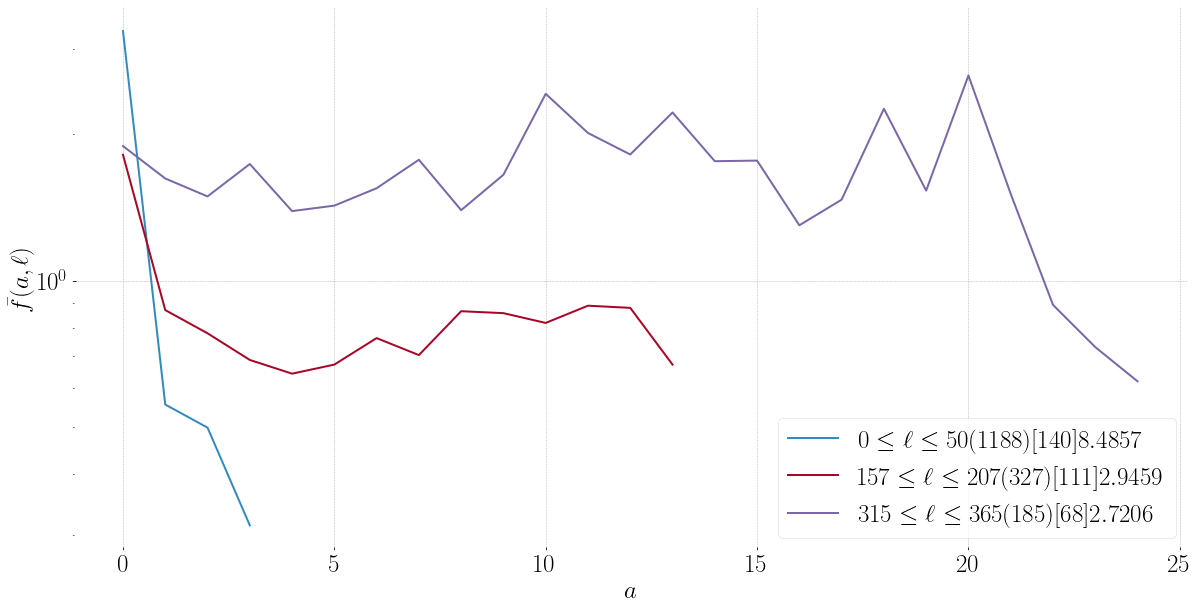

In [335]:
fig1ns = {}
for i in range(3):
    fig1ns[i] = pc.get_fal(df, limits['it'][i][0], limits['it'][i][1], 15, countalters=True)
    
plt.xlabel(r"$a$")
plt.ylabel(r"$\bar{f}(a, \ell)$")
plt.semilogy()
for i in range(3):
    plt.plot(fig1ns[i]['f'].index, fig1ns[i]['f']['f'], 
             label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]} ({fig1ns[i]["nalters"]}) [{fig1ns[i]["egocount"]}] {fig1ns[i]["nalters"] / fig1ns[i]["egocount"]:.4f}$')
plt.legend()

## Italian Loop

In [339]:
t0 = dt.datetime.now()
itloop = {}
for i in range(3):
    itloop[i] = {}
for to in range(30, 61):
    df = unfiltered['it'].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= 365]
    df = df[df['ea'].isin(keep.index)]
    t0i = df.groupby('ego')['uclock'].min()
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > to]
    df = df[df['ea'].isin(keep.index)]
    df = pc.apply_filters(df, 60)
    df['ea'] = list(zip(df['ego'], df['alter']))
    for i in range(3):
        tmp = pc.get_fal(df, limits['it'][i][0], limits['it'][i][1], 15)
        itloop[i][to] = tmp['f']
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:17.615472


In [347]:
itavg = {}
for i in itloop.keys():
    itavg[i] = pd.DataFrame()
    for to in itloop[i].keys():
        df = itloop[i][to]
        df.columns = [f'f{to}']
        itavg[i] = itavg[i].merge(df, left_index=True, right_index=True, how='outer')
    itavg[i]['f'] = itavg[i].mean(axis=1)

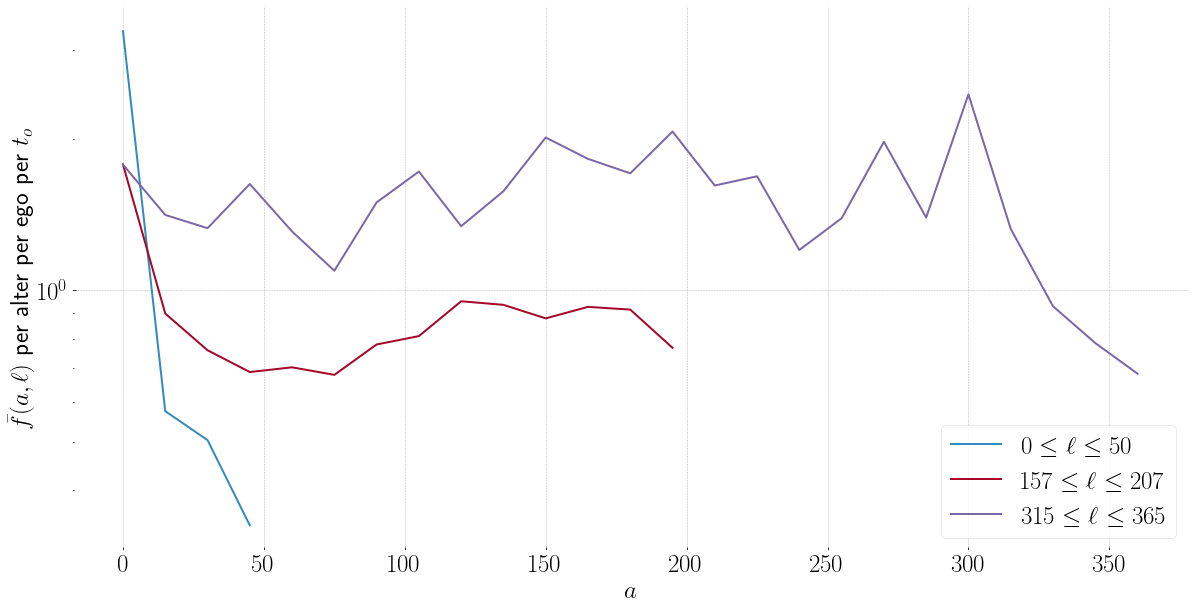

In [352]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$ per alter per ego per $t_o$')
plt.semilogy()
for i in range(3):
    plt.plot([x * 15 for x in itavg[i].index], itavg[i]['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()
# plt.savefig("/Users/vsvh/Desktop/A.pdf", dpi=150)

# Calls only limited by $\mathcal{L}$

In [151]:
callsb = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    callsb[c] = df

In [152]:
for c in ['uk2', 'it', 'mit']:
    T = max(callsb[c]['uclock'])
    df = callsb[c].copy(deep=True)
    T0i = df.groupby('ego')['uclock'].min()
    df['ea'] = list(zip(df['ego'], df['alter']))
    tmp = df.groupby('ea')[['uclock']].min()
    tmp['difdays'] = tmp.index.map(lambda i: tmp.at[i, 'uclock'] - T0i[i[0]])
    tmp = tmp.loc[tmp['difdays'] <= 60]
    dfl = df[df['ea'].isin(tmp.index)]
    setl = set(tmp.index)
    tmp = df.loc[df['uclock'] > T - 60]
    dfr = df[df['ea'].isin(tmp['ea'].unique())]
    setr = set(tmp['ea'].unique())
    print(c, len(setl.intersection(setr)) / (len(df['ea'].unique())))
    print(c, 'left but not right', (len(setl) - len(setl.intersection(setr))) / (len(df['ea'].unique())))
    print(c, 'right but not left', (len(setr) - len(setl.intersection(setr))) / (len(df['ea'].unique())))
    print(c, f'Left {len(dfl["ea"].unique()) / len(df["ea"].unique()):.4f}({len(dfl) / len(df):.4f})', f'Right {len(dfr["ea"].unique()) / len(df["ea"].unique()):.4f}({len(dfr) / len(df):.4f})')
    print(c, len(df['ea'].unique()))

uk2 0.0018036588508116465
uk2 left but not right 0.2285493429528472
uk2 right but not left 0.16001030662200463
uk2 Left 0.2304(0.3380) Right 0.1618(0.3684)
uk2 3881
it 0.019179642992783897
it left but not right 0.17418344094189137
it right but not left 0.14047664261298898
it Left 0.1934(0.4471) Right 0.1597(0.3102)
it 21064
mit 0.0379030273197145
mit left but not right 0.3512183115924194
mit right but not left 0.08466650258429732
mit Left 0.3891(0.6788) Right 0.1226(0.3146)
mit 4063


In [153]:
print('left', (0.17418344094189137 * 21064 + 0.3512183115924194 * 4063)/(21064 + 4063))
print('right', (0.14047664261298898 * 21064 + 0.08466650258429732 * 4063) / (21064 + 4063))

left 0.20280972658892824
right 0.1314522227086401


# $t_0$ by cohort and by $\ell$

In [154]:
Hto = {}
for c in ['uk2', 'it', 'mit']:
    Hto[c] = {}
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    for i in range(3):
        keep = lf.loc[(lf['ell'] >= limits[c][i][0]) & (lf['ell'] <= limits[c][i][1])]
        df2 = df[df['ea'].isin(keep.index)]
        to = df2.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
        Hto[c][i] = pc.histogram(to['to'], 15, log=False)

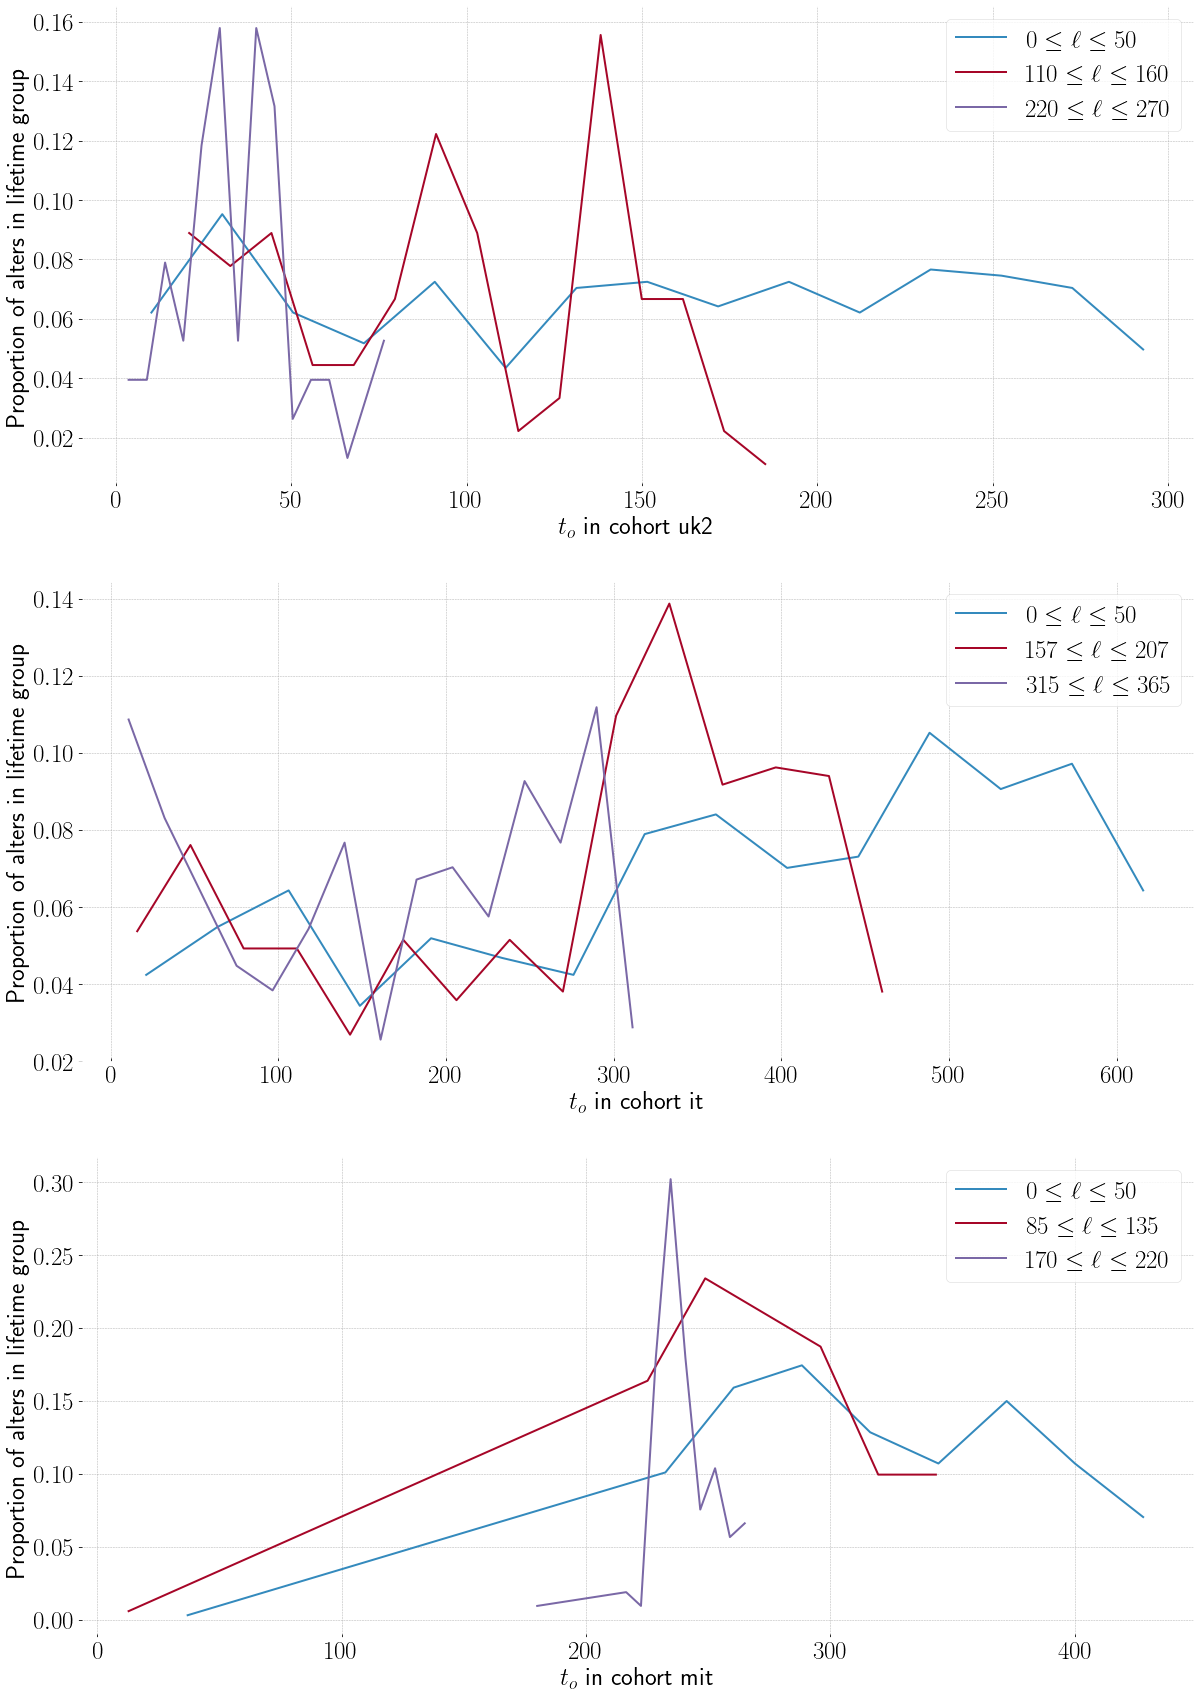

In [155]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in Hto.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr'$t_o$ in cohort {c}')
    plt.ylabel('Proportion of alters in lifetime group')
    for i in range(3):
        plt.plot(Hto[c][i]['label'], Hto[c][i]['pmf'], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
    plt.legend()
    p += 1

In [156]:
fwL = {}
for c in ['uk2', 'it', 'mit']:
    fwL[c] = {}
    for i in range(3):
        fwL[c][i] = pc.get_fal(callsb[c], limits[c][i][0], limits[c][i][1], 15)

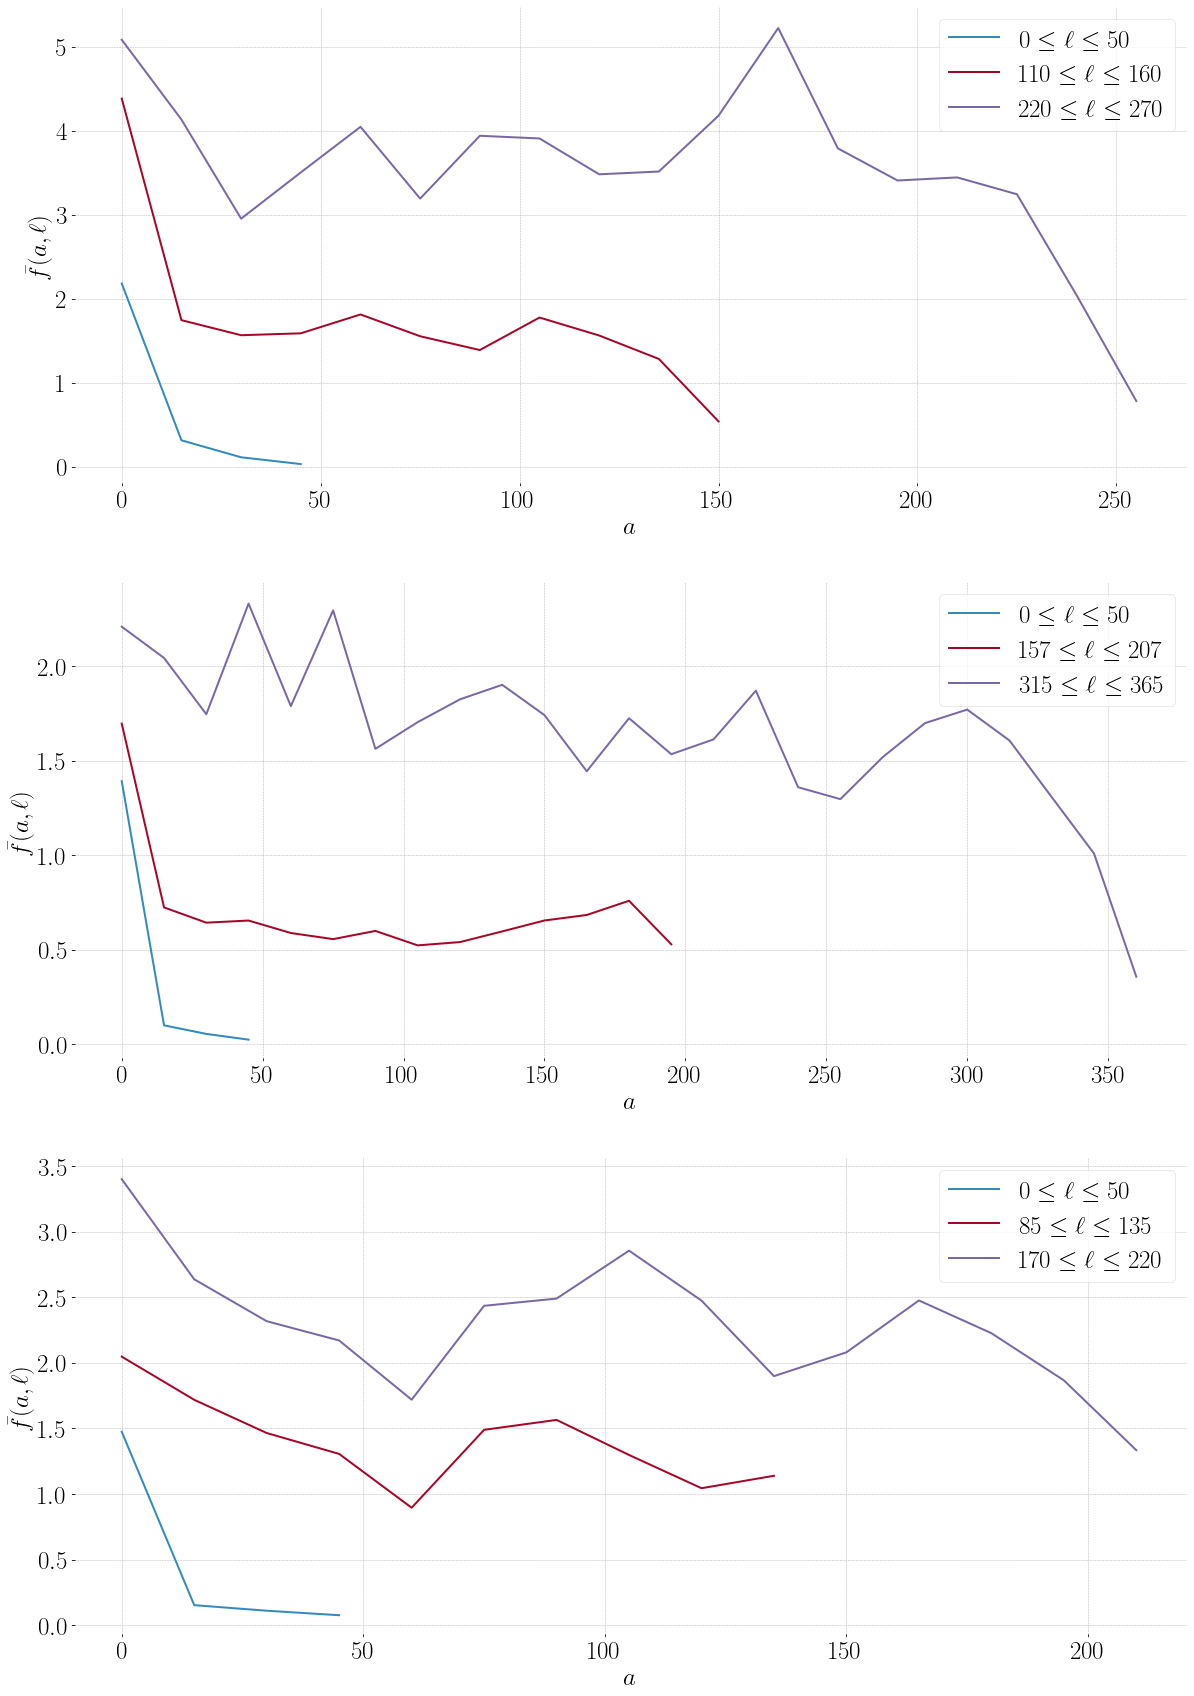

In [157]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in fwL.keys():
    plt.subplot(3,1,p)
    plt.xlabel(r"$a$")
    plt.ylabel(r"$\bar{f}(a, \ell)$")
    for i in range(3):
        plt.plot([x * 15 for x in fwL[c][i]['f'].index], fwL[c][i]['f']['f'], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
    plt.legend()
    p += 1

# Proportion of phone calls used after filters

In [158]:
# t0 = dt.datetime.now()
# tmp = {}
# for c in ['uk2', 'it', 'mit']:
#     tmp[c] = pc.lives_dictionary(unfiltered[c])
    
# counts = {}
# for c in ['uk2', 'it', 'mit']:
#     alters = 0
#     ncalls = 0
#     a = 0
#     cc = 0
#     counts[c] = {}
#     for i in range(0, 301, 10):
#         tmpc = pc.apply_filters(unfiltered[c], i)
#         cdf = tmpc.loc[tmpc['aclock'] <= 300]
#         tmpl = pc.lives_dictionary(cdf)
#         tmpdff = pc.get_f(cdf, 'all', 15, 10)
#         for ego in tmp[c].keys():
#             for alter in tmp[c][ego].keys():
#                 vol = tmp[c][ego][alter]['nij']
#                 alters += 1
#                 ncalls += vol
#                 if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
#                     a += 1
#                     vol = tmpl[ego][alter]['nij']
#                     cc += vol
#             counts[c][i] = (a / alters, cc / ncalls)
#     counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))
    
# print(f'This block took {dt.datetime.now() - t0}')

In [159]:
for c in ['uk2', 'it', 'mit']:
    full = unfiltered[c].copy(deep=True)
    full['ea'] = list(zip(full['ego'], full['alter']))
    altf = len(full['ea'].unique())
    callsf = len(full)
    sample = calls[c].copy(deep=True)
    sample['ea'] = list(zip(sample['ego'], sample['alter']))
    alts = len(sample['ea'].unique())
    callss = len(sample)
    print(f'{c}: \t Alters: {alts/altf:.4f} \t Calls: {callss/callsf:.4f}')

uk2: 	 Alters: 0.2330 	 Calls: 0.4113
it: 	 Alters: 0.1712 	 Calls: 0.1695
mit: 	 Alters: 0.2012 	 Calls: 0.3579


## count pairs of ego alters

In [160]:
for c in ['uk2', 'it', 'mit', 'all']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ego'].unique()), len(df['ea'].unique()))

uk2 30 920
it 143 4052
mit 120 834
all 293 5806


In [161]:
for c in ['uk', 'it', 'mit']:
    print(c, min(unfiltered[c]['time']), max(unfiltered[c]['time']), max(unfiltered[c]['time']) - min(unfiltered[c]['time']))

uk 2007-03-05 13:17:00 2008-08-31 20:13:00 545 days 06:56:00
it 2013-02-01 08:03:16 2014-12-31 23:46:21 698 days 15:43:05
mit 2010-02-27 17:05:20 2011-07-16 19:33:13 504 days 02:27:53


In [162]:
for c in ['uk', 'it', 'mit']:
    print(min(unfiltered[c]['uclock']))

0
0
0


In [163]:
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

# Mutual Information

In [164]:
miall = []
for c in ['uk2', 'it', 'mit', 'all']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    

In [165]:
def get_month2(calls, lives):
    result = pd.DataFrame()
    idx = 0
    for ego in dff.keys():
        for alter in dff[ego].keys():
            df = dff[ego][alter].loc[(dff[ego][alter]['alpha'] >= 2) & (dff[ego][alter]['alpha'] <= 3)]
            if (len(df) > 0) and (ego in lives.keys()):
                result.at[idx, 'ego'] = ego
                result.at[idx, 'alter'] = alter
                result.at[idx, 'g'] = sum(df['f'])
                result.at[idx, 'lambda'] = lives[ego][alter]['ell']
                idx += 1
    return result

In [166]:
miall = []
for i in ['uk', 'uk2', 'it', 'mit', 'all']:
    miall.append(get_month2(dffsurv[i], lives['all']))

NameError: name 'dffsurv' is not defined

In [ ]:
import sklearn.metrics as sk
miplot = []
for i in miall:
    miplot.append(sk.mutual_info_score(i['g'], i['lambda']))
for i in range(len(miplot)):
    print(['uk', 'uk2', 'it', 'mit', 'all'][i],"\t", miplot[i],"\t", miplot[i]*1.44)

In [ ]:
entropies = []
for i in miall:
    X = stats.entropy([xx / sum(i["g"]) for xx in i['g']])
    Y = stats.entropy([yy / sum(i['lambda']) for yy in i['lambda']])
    entropies.append(np.mean([X, Y]))
    print(X, Y, np.mean([X, Y]))

In [ ]:
for i in range(len(miplot)):
    print(['uk', 'uk2', 'mit', 'it', 'all'][i],"\t", miplot[i],"\t", miplot[i] / entropies[i])

# Finding $\mathcal{L}$

Currently, without redefining the sample, the number of ego alter pairs used is

In [ ]:
# for c in dffcomb.keys():
#     pairs = 0
#     for ego in dffcomb[c].keys():
#         for alter in dffcomb[c][ego].keys():
#             pairs += 1
#     print(c, pairs)

Now, for Italy

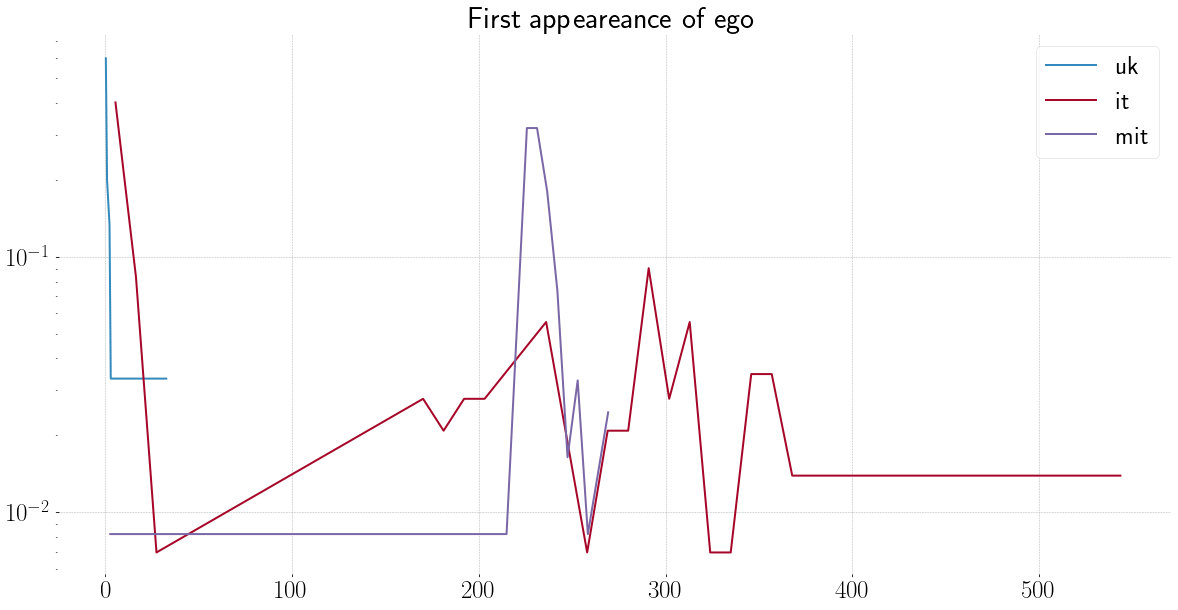

In [167]:
Hfap = {}
for c in ['uk', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    fap = df.groupby('ego')[['uclock']].min()
    Hfap[c] = pc.histogram(fap['uclock'], 50, log=False)
plt.title('First appeareance of ego')    
plt.semilogy()
for c in Hfap.keys():
    plt.plot(Hfap[c]['label'], Hfap[c]['pmf'], label=c)
plt.legend()

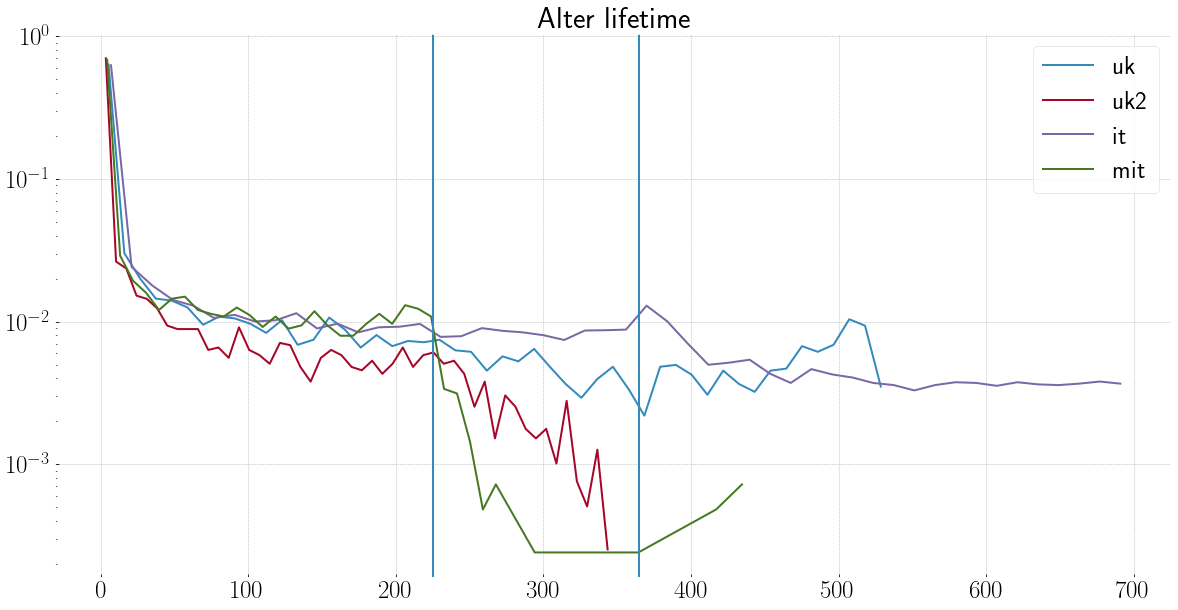

In [168]:
Hlf = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    Hlf[c] = pc.histogram(lf['aclock'], 50, log=False)
plt.title(r"Alter lifetime")
plt.semilogy()
# plt.xlim(-0.5, 365)
for c in Hlf.keys():
    plt.plot(Hlf[c]['label'], Hlf[c]['pmf'], label=c)
plt.axvline(225)
plt.axvline(365)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/vsvh/Desktop/A.pdf'

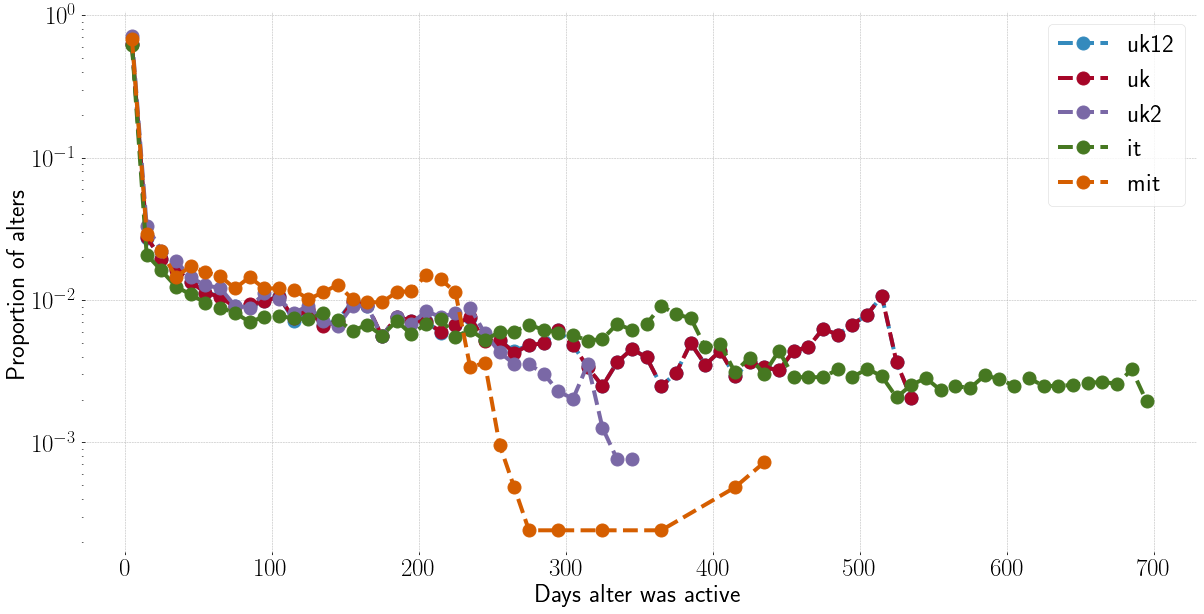

In [169]:
m = 0
tmp = pd.DataFrame()
plt.semilogy()
for c in ['uk12', 'uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    H = {}
    for ea in lf.index:
        ell = lf.at[ea, 'aclock'] // 10
        H[ell] = H.get(ell, 0) + 1
    H = pd.DataFrame.from_dict(H, orient='index').sort_index()
    H[f'x{c}'] = H.index.map(lambda i: (i * 10) + 5)
    H[f'y{c}'] = H[0].div(sum(H[0]))
    H = H.drop(columns=[0])
    plt.ylabel("Proportion of alters")
    plt.xlabel("Days alter was active")
    plt.plot(H[f'x{c}'], H[f'y{c}'], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
plt.legend()
plt.savefig("/home/vsvh/Desktop/A.pdf", dpi=200)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.dat", index=False, header=True, sep="\t")

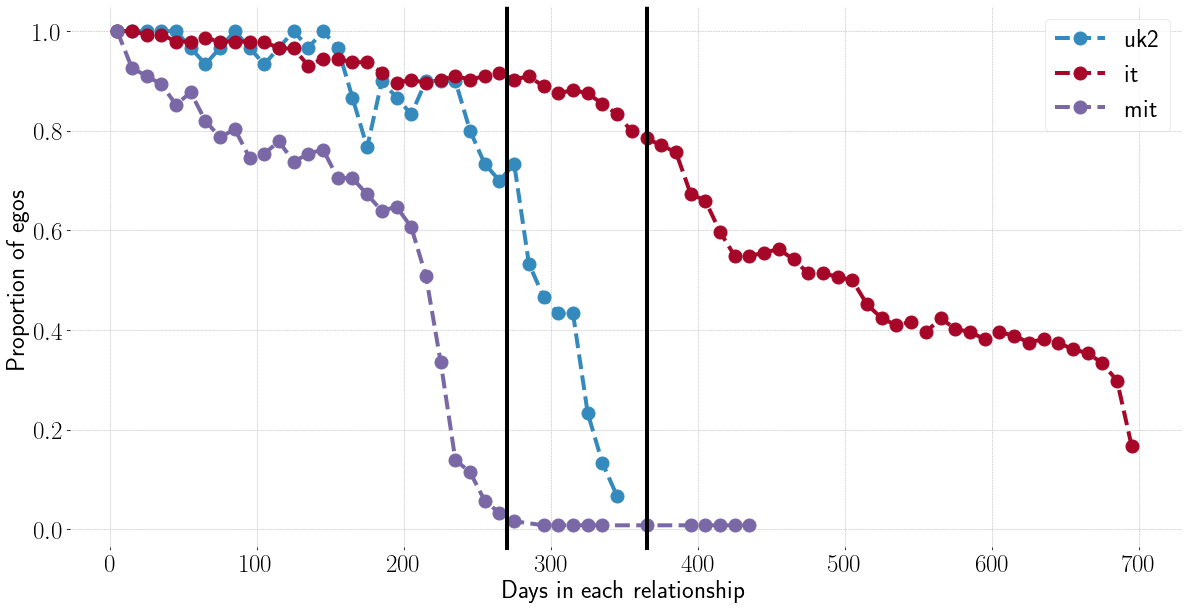

In [170]:
tmp = pd.DataFrame()
m = 0
#plt.semilogy()
for c in ['uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df['10d'] = df['aclock'].map(lambda i: (i // 10) + 0.5)
    nego = df.groupby('10d')[['ego']].nunique()
    n = len(df['ego'].unique())
    # plt.xlim(0, 400)
    plt.ylabel("Proportion of egos")
    nego.index = nego.index * 10
    plt.xlabel("Days in each relationship")
    plt.plot(nego.index, [y / n for y in nego['ego']], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    nego['ego'] /= n
    nego.columns = [f'y{c}']
    tmp = tmp.merge(nego, left_index=True, right_index=True, how='outer')
    plt.axvline(270, c="black", lw=4)
    plt.axvline(365, c="black", lw=4)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/B.pdf", dpi=200)
# tmp = tmp.fillna('nan')
# tmp.index.rename("a", inplace=True)
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.dat", index=True, header=True, sep="\t")

In [171]:
tmp

yuk2       yit      ymit
10d                            
5.0     1.0  1.000000  1.000000
15.0    1.0  1.000000  0.926230
25.0    1.0  0.993056  0.909836
35.0    1.0  0.993056  0.893443
45.0    1.0  0.979167  0.852459
...     ...       ...       ...
655.0   NaN  0.361111       NaN
665.0   NaN  0.354167       NaN
675.0   NaN  0.333333       NaN
685.0   NaN  0.298611       NaN
695.0   NaN  0.166667       NaN

[70 rows x 3 columns]

FileNotFoundError: [Errno 2] No such file or directory: '/home/vsvh/Desktop/C.pdf'

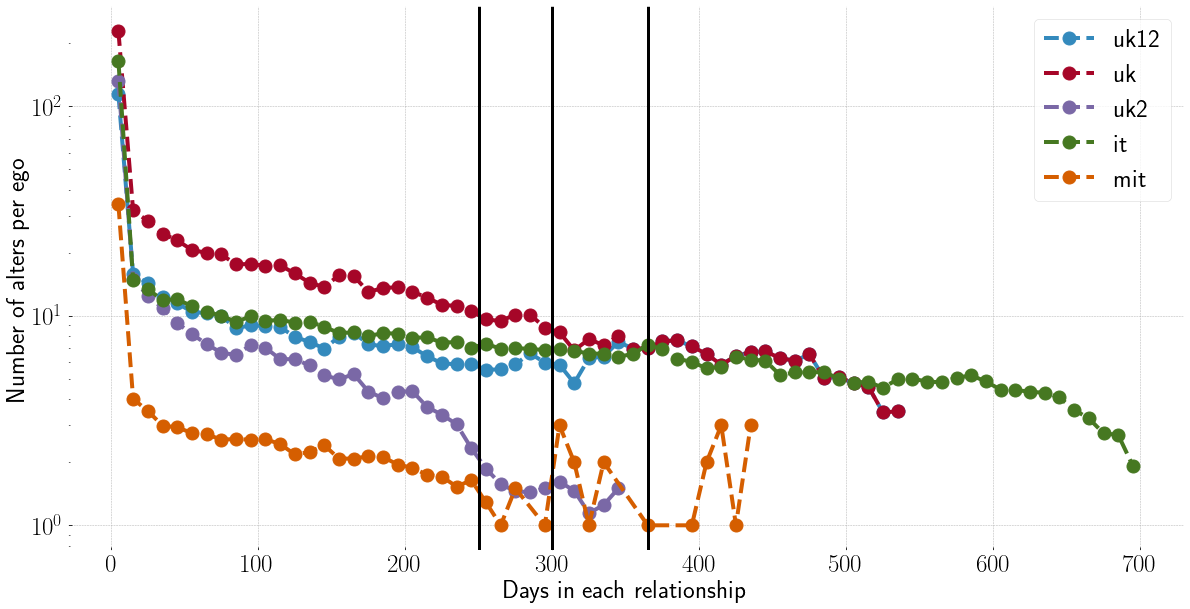

In [172]:
m = 0
plt.semilogy()
for c in ['uk12', 'uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df['10d'] = df['aclock'].map(lambda i: (i // 10) + 0.5)
    nalt = df.groupby('10d')[['ea']].nunique()
    nego = df.groupby('10d')[['ego']].nunique()
    prop = nego.merge(nalt, left_index = True, right_index = True, how='outer')
    prop['prop'] = prop['ea'] / prop['ego']
    plt.ylabel("Number of alters per ego")
    plt.xlabel("Days in each relationship")
    plt.plot([10 * x for x in prop.index], prop['prop'], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    plt.axvline(365, color='black', lw=3)
    plt.axvline(300, color='black', lw=3)
    plt.axvline(250, color='black', lw=3)
plt.legend()
plt.savefig("/home/vsvh/Desktop/C.pdf", dpi=200)

In [ ]:
it = unfiltered['it'].copy(deep=True)
it['ea'] = list(zip(it['ego'], it['alter']))
itlf = it.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
keep = itlf.loc[itlf['ell'] <= 365]
it = it[it['ea'].isin(keep.index)]
it = pc.apply_filters(it, 60)

In [ ]:
it['ea'] = list(zip(it['ego'], it['alter']))
print(len(it['ea'].unique()))
lf = it.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
H = pc.histogram(lf['ell'], 50, log=False)
plt.semilogy()
plt.plot(H['label'], H['pmf'])

In [ ]:
newlim = [(0, 50), (100, 150), (250, 300)]

In [ ]:
new1 = {}
for i in range(3):
    new1[i] = pc.get_fal(it, newlim[i][0], newlim[i][1], 15, countalters=True)

In [ ]:
plt.figure(figsize=(20*2, 10*1))
plt.subplot(121)
plt.title("New sampling")
plt.semilogy()
for i in range(3):
    plt.plot(new1[i]['f'].index, new1[i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()
plt.subplot(122)
plt.title("Sampling from the paper")
plt.semilogy()
for i in range(3):
    plt.plot(fig1['it'][i]['f'].index, fig1['it'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()

In [ ]:
new2 = {}
for i in range(3):
    new2[i] = pc.get_avgfa(dffcomb['uk'], lives['uk'], newlim[i][0], newlim[i][1])

In [ ]:
plt.figure(figsize=(20*2, 10*1))
plt.subplot(121)
plt.title("New sampling")
plt.semilogy()
for i in range(3):
    plt.plot(new2[i].index, new2[i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {newlim[i][1]}$')
plt.legend()
plt.subplot(122)
plt.title("Sampling from the paper")
plt.semilogy()
for i in range(3):
    plt.plot(fig1['uk'][i]['f'].index, fig1['uk'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()

In [ ]:
new3 = {}
for i in range(3):
    new3[i] = pc.get_avgfa(dffcomb['mit'], lives['mit'], newlim[i][0], newlim[i][1])

In [ ]:
plt.figure(figsize=(20*2, 10*1))
plt.subplot(121)
plt.title("New sampling")
plt.semilogy()
for i in range(3):
    plt.plot(new3[i].index, new3[i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {newlim[i][1]}$')
plt.legend()
plt.subplot(122)
plt.title("Sampling from the paper")
plt.semilogy()
for i in range(3):
    plt.plot(fig1['mit'][i]['f'].index, fig1['mit'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()

In [ ]:
egolist = {}
for c in ['it1', 'it2']:
    egolist[c] = [ego[1:] for ego in dffcomb[c].keys()]

intersections = {}
for ego in egolist['it1']:
    if ego in egolist['it2']:
        set1 = {alter for alter in dffcomb['it1'][f'a{ego}'].keys()}
        set2 = {alter for alter in dffcomb['it2'][f'b{ego}'].keys()}
        intersections[ego] = set1.intersection(set2)

In [ ]:
tot = 0
rep = 0
for ego in intersections.keys():
    tot += 1
    if len(intersections[ego]) > 0:
        rep += 1
print(f'Total egos: \t{tot}')
print(f'Egos with repetition: \t{rep} ({(rep/tot) * 100:.2f}%)')

In [ ]:
intersections

In [ ]:
a = unfiltered['it'].loc[(unfiltered['it']['ego'] == 28) & (unfiltered['it']['alter'] == '176577f07de42298c204581415ca579e')]
a

In [ ]:
max(a['uclock']) - min(a['uclock'])

In [ ]:
it.loc[(it['ego'] == 28) & (it['alter'] == '176577f07de42298c204581415ca579e')]

# Testing area

In [ ]:
general_count = 0
uk1_count = 0
for ego in dffcomb['uk'].keys():
    for alter in dffcomb['uk'][ego].keys():
        general_count += 1
        if ego[0] == 'a':
            uk1_count += 1
uk1_count / general_count

In [ ]:
min(unfiltered['it']['time'])

# Global Time

In [ ]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")